In [29]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import re

plt.rcParams['font.family'] = 'AppleGothic'  # macOS

ko2en_dict = {
    '영업일자' : 'date',
    '영업장명_메뉴명' : 'menu',
    '매출수량': 'num'
}
store_id_map = {
    '느티나무': 1,
    '담하': 2, 
    '라그로타': 3,
    '미라시아': 4,
    '연회장':5, 
    '카페테리아': 6,
    '포레스트릿': 7,
    '화담숲주막': 8,
    '화담숲카페': 9 
}
def add_store_id_column(df, mapping_dict):
    # 업장명과 ID 매핑 딕셔너리
    # 정규표현식 패턴 생성
    pattern = '|'.join(re.escape(name) for name in mapping_dict.keys())

    # 업장명 추출
    df['store'] = df['menu'].str.extract(f'({pattern})')

    # ID 매핑
    df['id'] = df['store'].map(store_id_map)

    return df

def rename_dataframe_columns(df, mapping_dict):
    return df.rename(columns=mapping_dict).copy()

train_df = pd.read_csv('./train/train.csv')
train_df = rename_dataframe_columns(train_df, ko2en_dict)
train_df = add_store_id_column(train_df, store_id_map)


def visualize(df, store_id, mode='single'):
    # 날짜 형식 변환
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['weekday'] >= 5

    # 메뉴별 그룹핑
    grouped = df.groupby('menu')

    # 전체 y축 스케일 계산 (모드 상관없이 항상 계산)
    y_min = df['num'].min()
    y_max = df['num'].max()

    if mode == 'single':
        # 모든 메뉴를 한 그래프에 그리기
        plt.figure(figsize=(30, 20))

        # 주말 영역 음영 표시
        for _, row in df.iterrows():
            if row['is_weekend']:
                plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='lightgray', alpha=0.3)

        for menu_name, group in grouped:
            plt.plot(group['date'], group['num'], label=menu_name)

        plt.title(f'Store ID {store_id} - 메뉴별 매출 추이')
        plt.xlabel('날짜')
        plt.ylabel('메뉴별 판매 수량')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.ylim(y_min, y_max)  # y축 고정
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    

    elif mode == 'split':
        for menu_name, group in grouped:
            fig = plt.figure(figsize=(18, 10))
            gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 0])  # 오른쪽 위 bar 차트 추가

            # ▶️ 메인 그래프 (왼쪽 큰 영역)
            ax_main = fig.add_subplot(gs[:, 0])

            # 주말 음영 표시
            for _, row in group.iterrows():
                if row['is_weekend']:
                    ax_main.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='lightgray', alpha=0.3)

            # 매출 그래프
            ax_main.plot(group['date'], group['num'], marker='o')
            ax_main.set_title(f'Store ID {store_id} - 메뉴: {menu_name}')
            ax_main.set_xlabel('날짜')
            ax_main.set_ylabel('판매 수량')
            ax_main.tick_params(axis='x', rotation=45)
            ax_main.grid(True)
            ax_main.set_ylim(y_min, y_max)

            # ▶️ 요일별 비율 계산
            weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
            weekday_counts = [0] * 7
            for _, row in group.iterrows():
                weekday_counts[row['weekday']] += row['num']
            total = sum(weekday_counts)
            weekday_ratios = [count / total for count in weekday_counts]

            # ▶️ 오른쪽 상단 서브플롯
            ax_bar = fig.add_subplot(gs[0, 1])
            colors = ['gray'] * 4 + ['lightblue'] + ['tomato', 'tomato']  # 주말 강조
            ax_bar.bar(weekday_names, weekday_ratios, color=colors)
            ax_bar.set_title('요일별 비율', fontsize=10)
            ax_bar.set_ylim(0, max(weekday_ratios) * 1.2)
            ax_bar.tick_params(axis='x', labelrotation=45)
            ax_bar.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
            ax_bar.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
            plt.subplots_adjust(right=0.85)

            plt.tight_layout()
            plt.show()

    else:
        raise ValueError("mode는 'single' 또는 'split'만 가능합니다.")

def visualization_of_stores(df, id_list, mode='single'):
    for num in id_list:
        temp = df[df['id'] == num].copy()
        visualize(temp, num, mode=mode)



date                menu  num store  id
0  2023-01-01  느티나무 셀프BBQ_1인 수저세트    0  느티나무   1
1  2023-01-02  느티나무 셀프BBQ_1인 수저세트    0  느티나무   1
2  2023-01-03  느티나무 셀프BBQ_1인 수저세트    0  느티나무   1
3  2023-01-04  느티나무 셀프BBQ_1인 수저세트    0  느티나무   1
4  2023-01-05  느티나무 셀프BBQ_1인 수저세트    0  느티나무   1

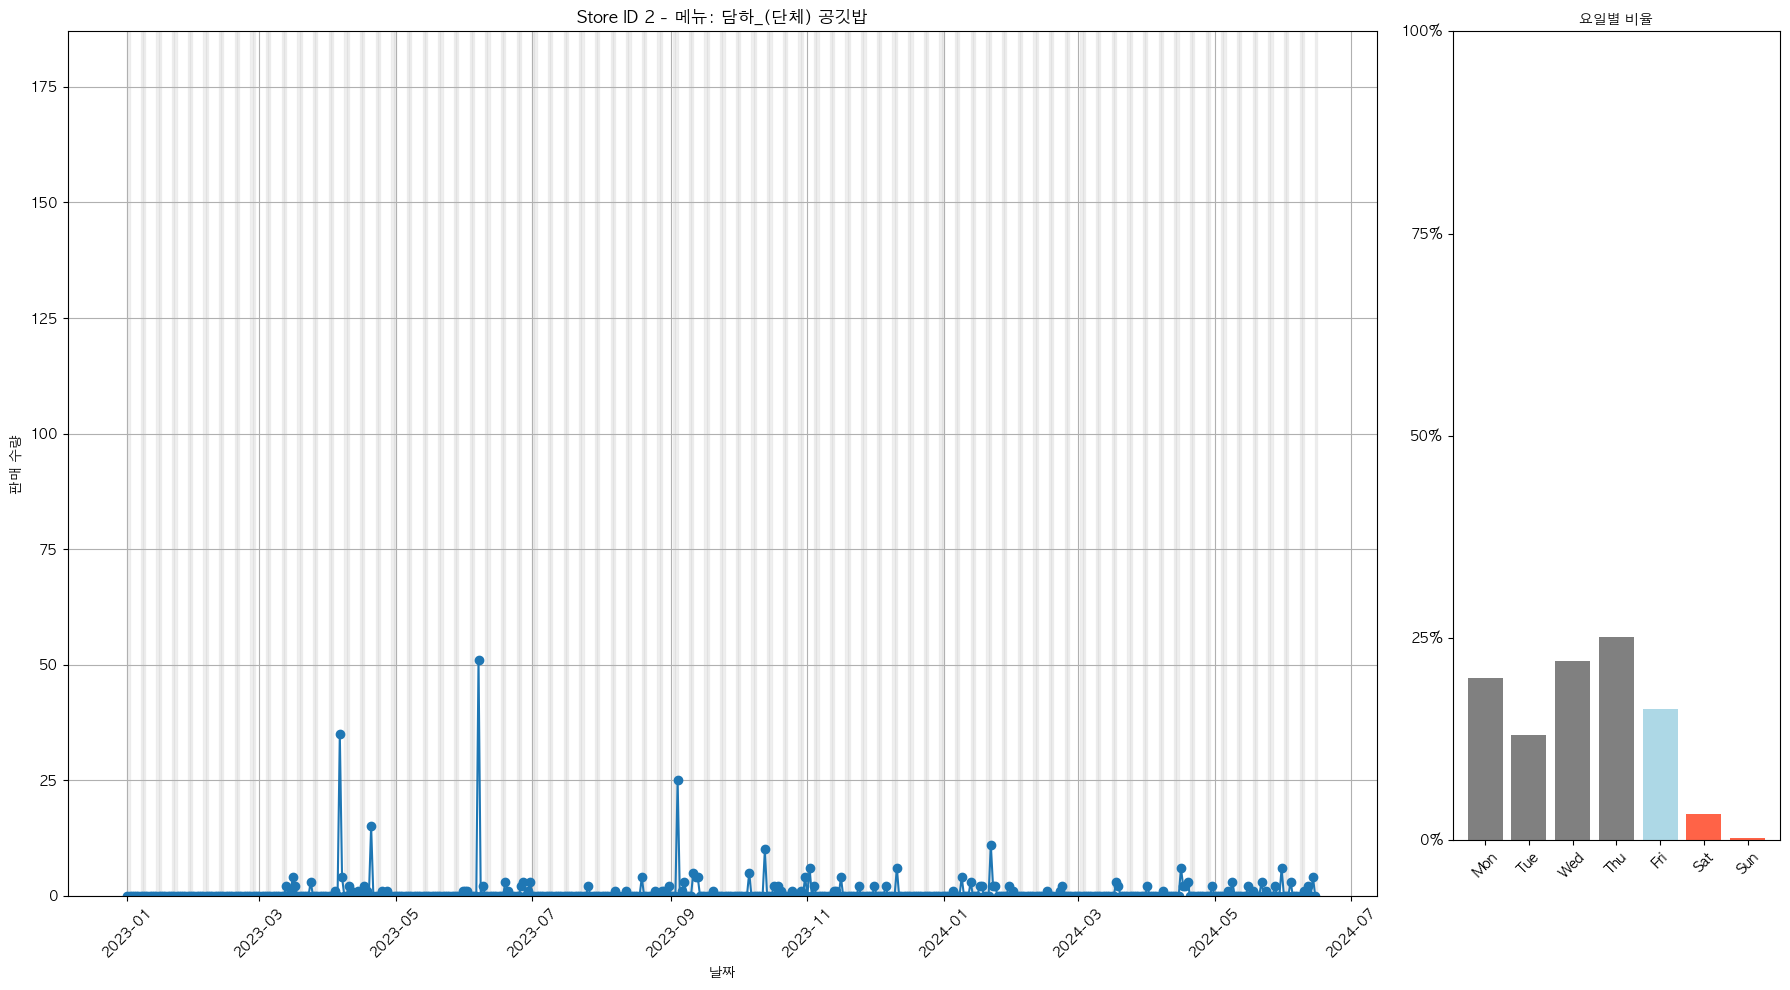

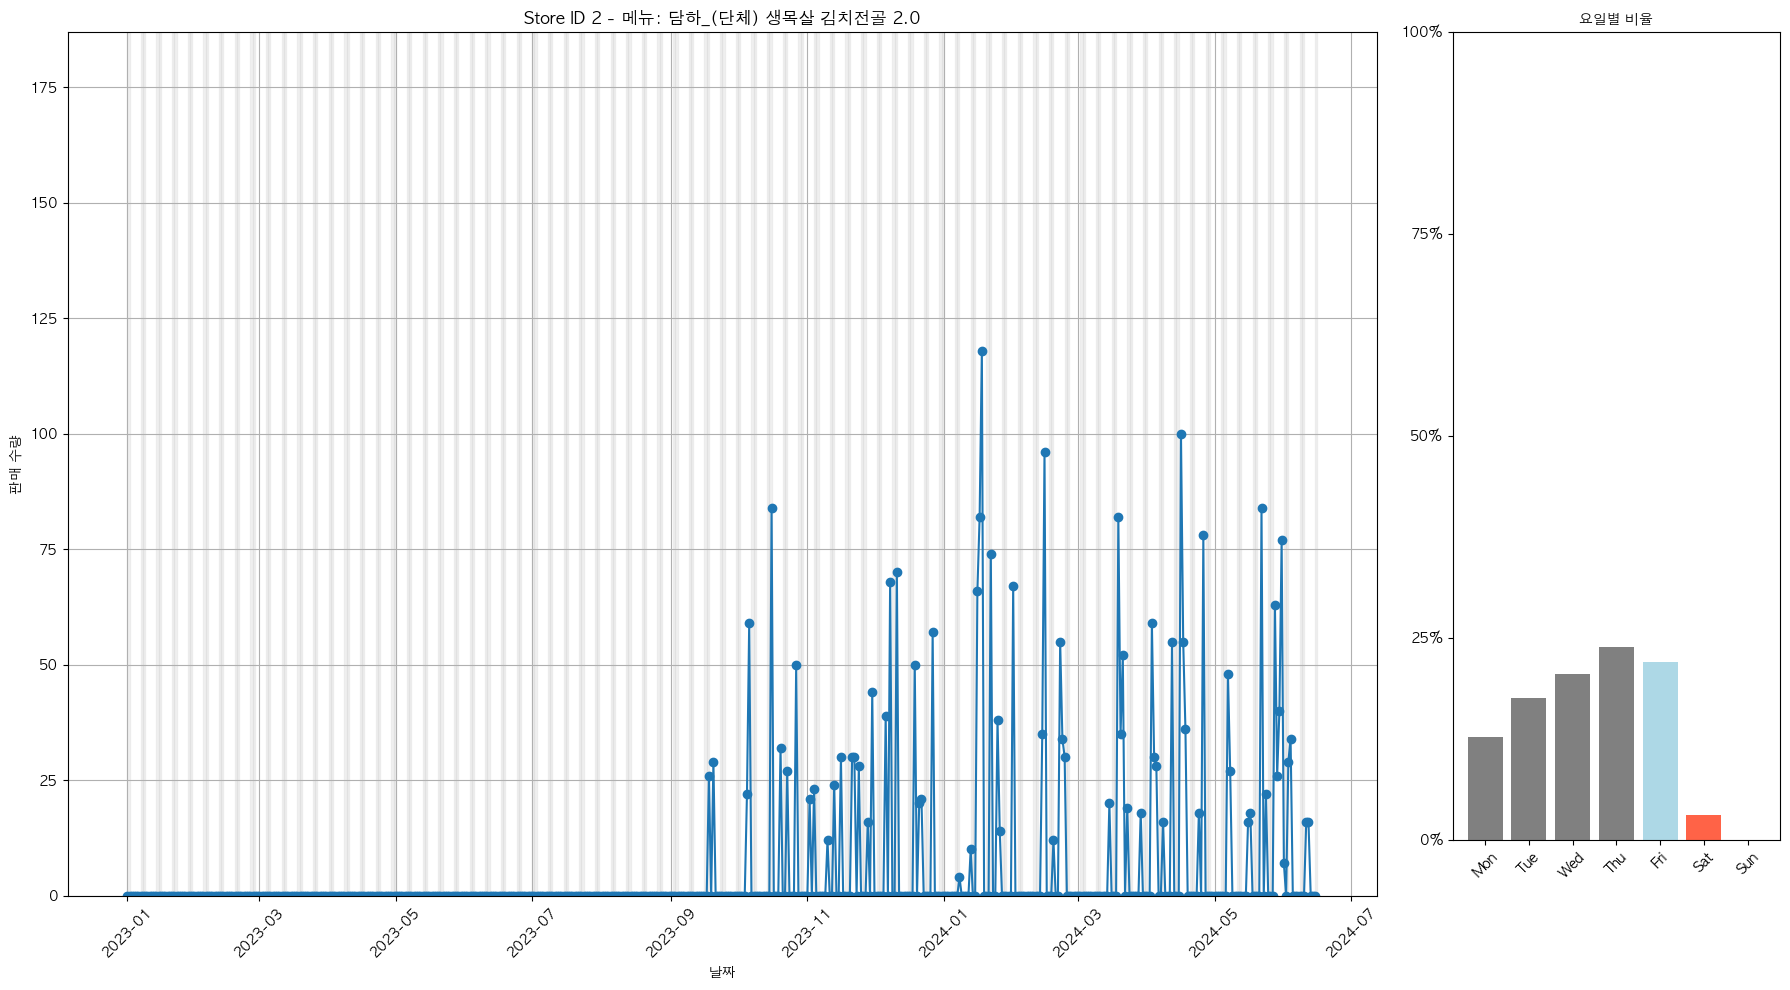

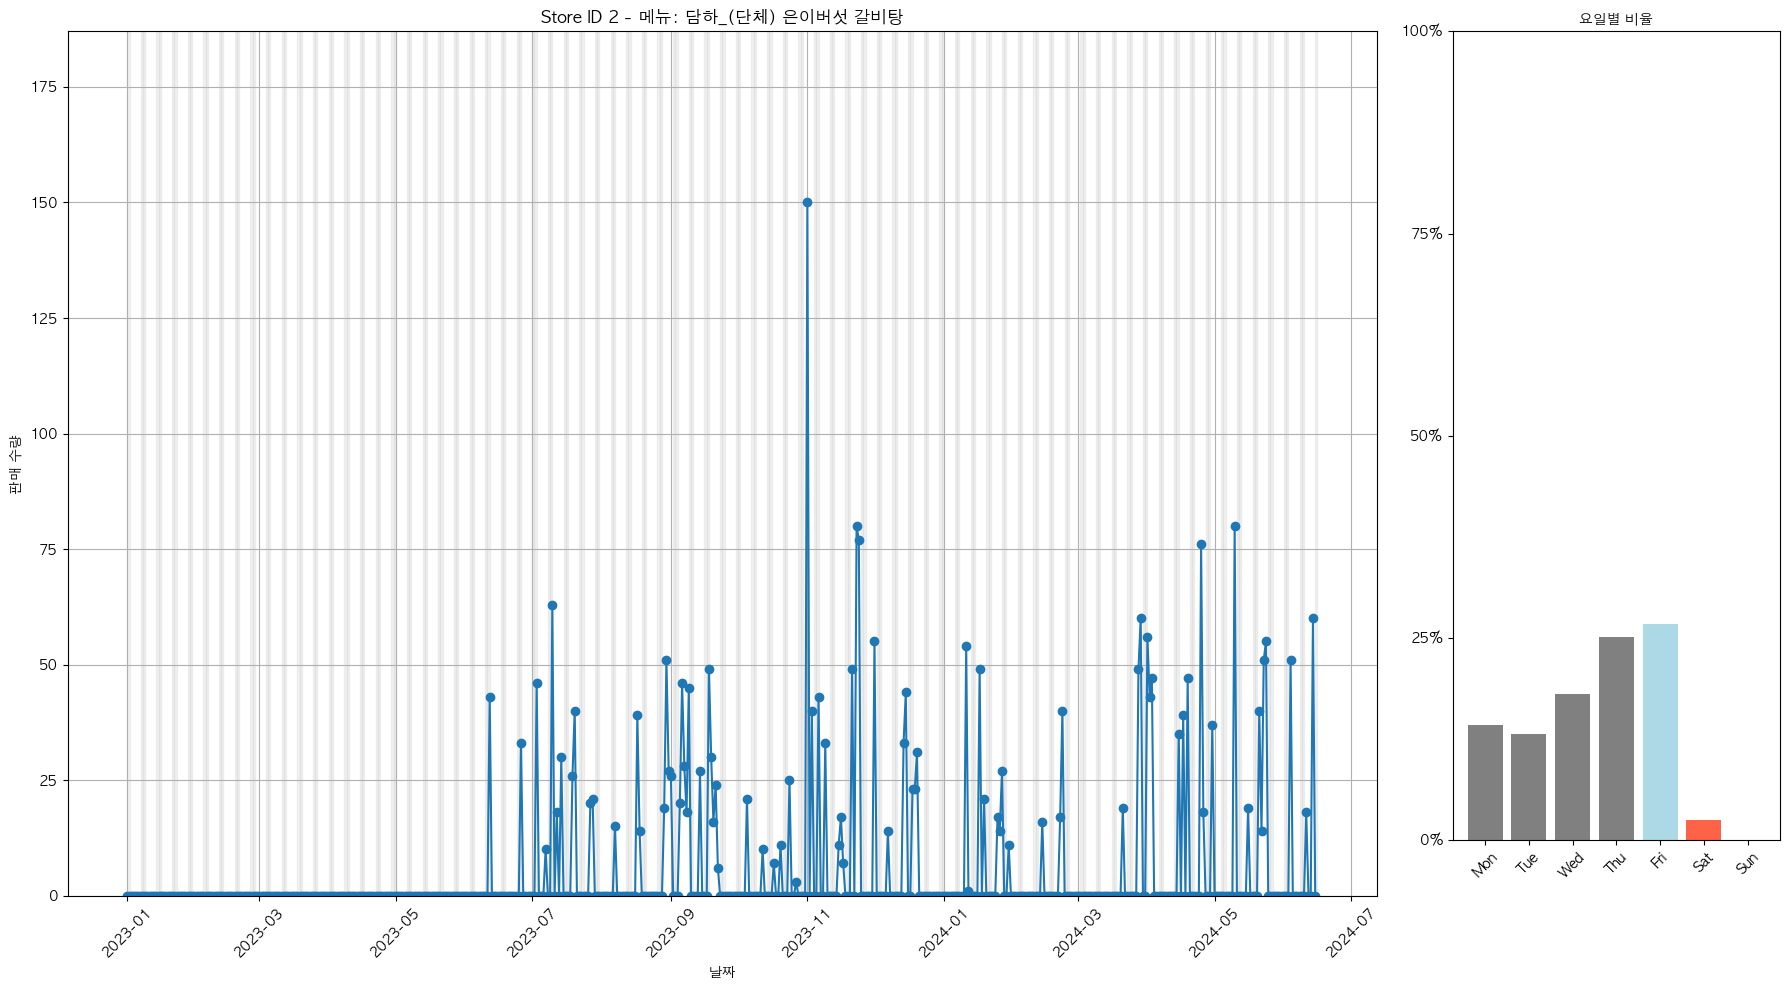

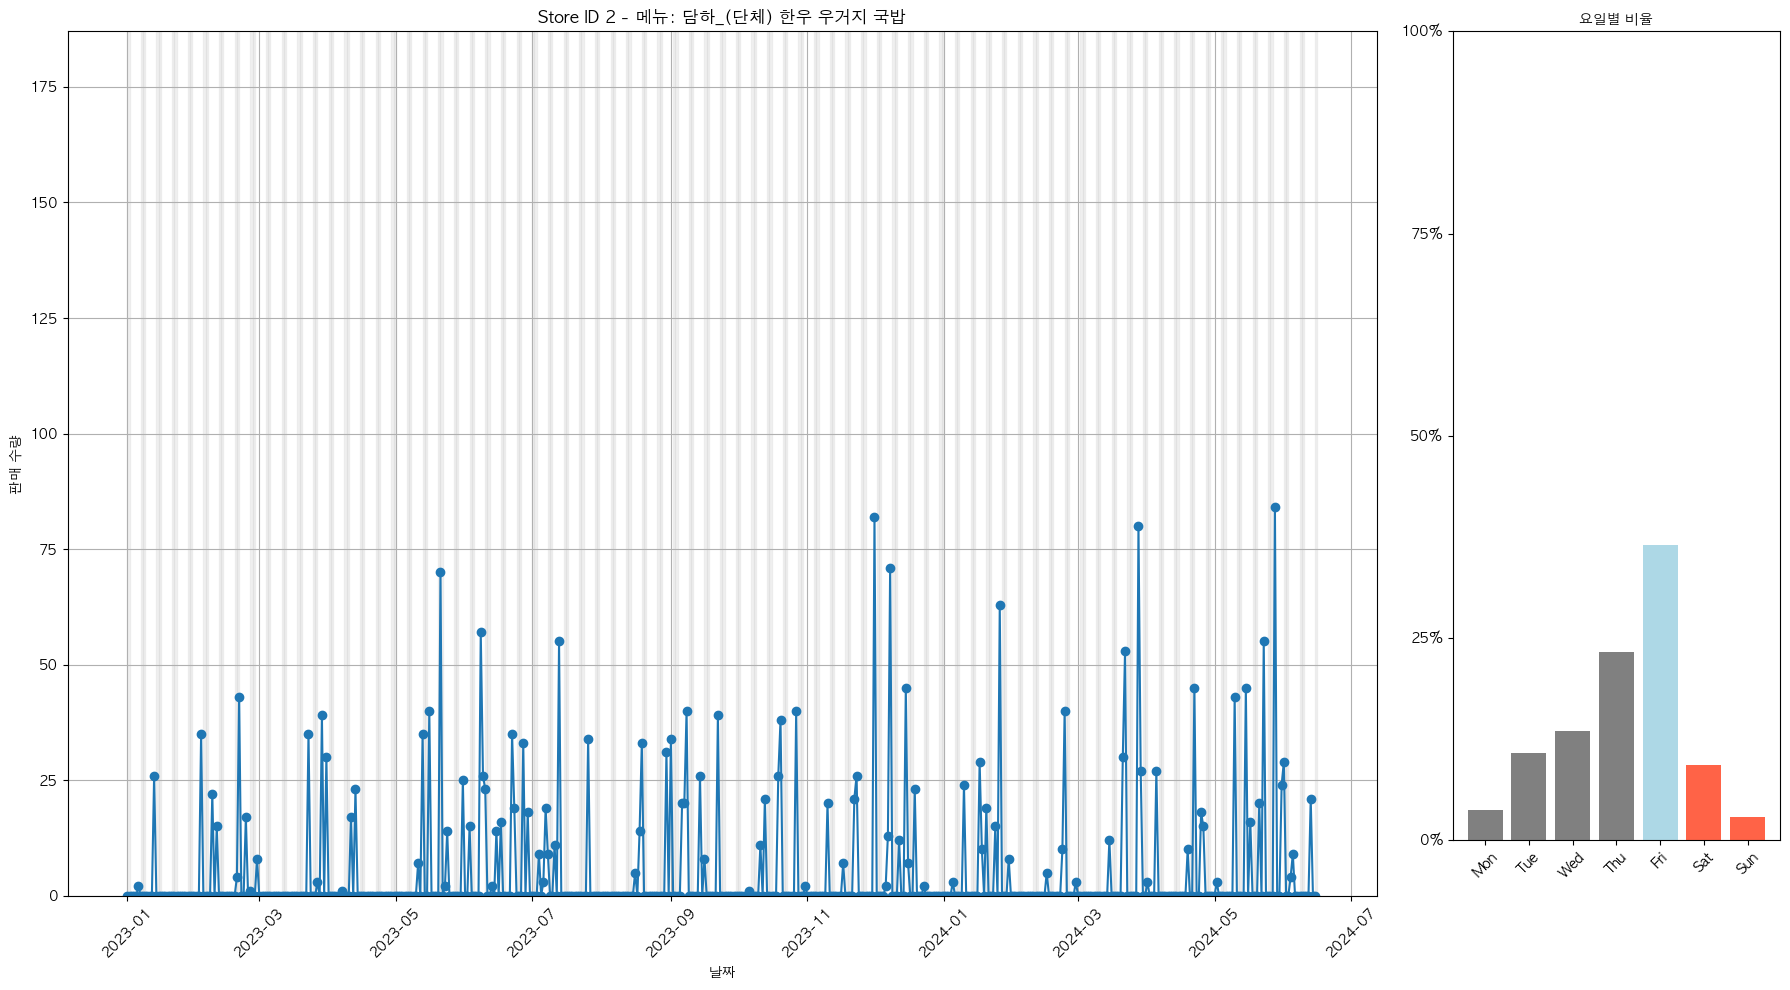

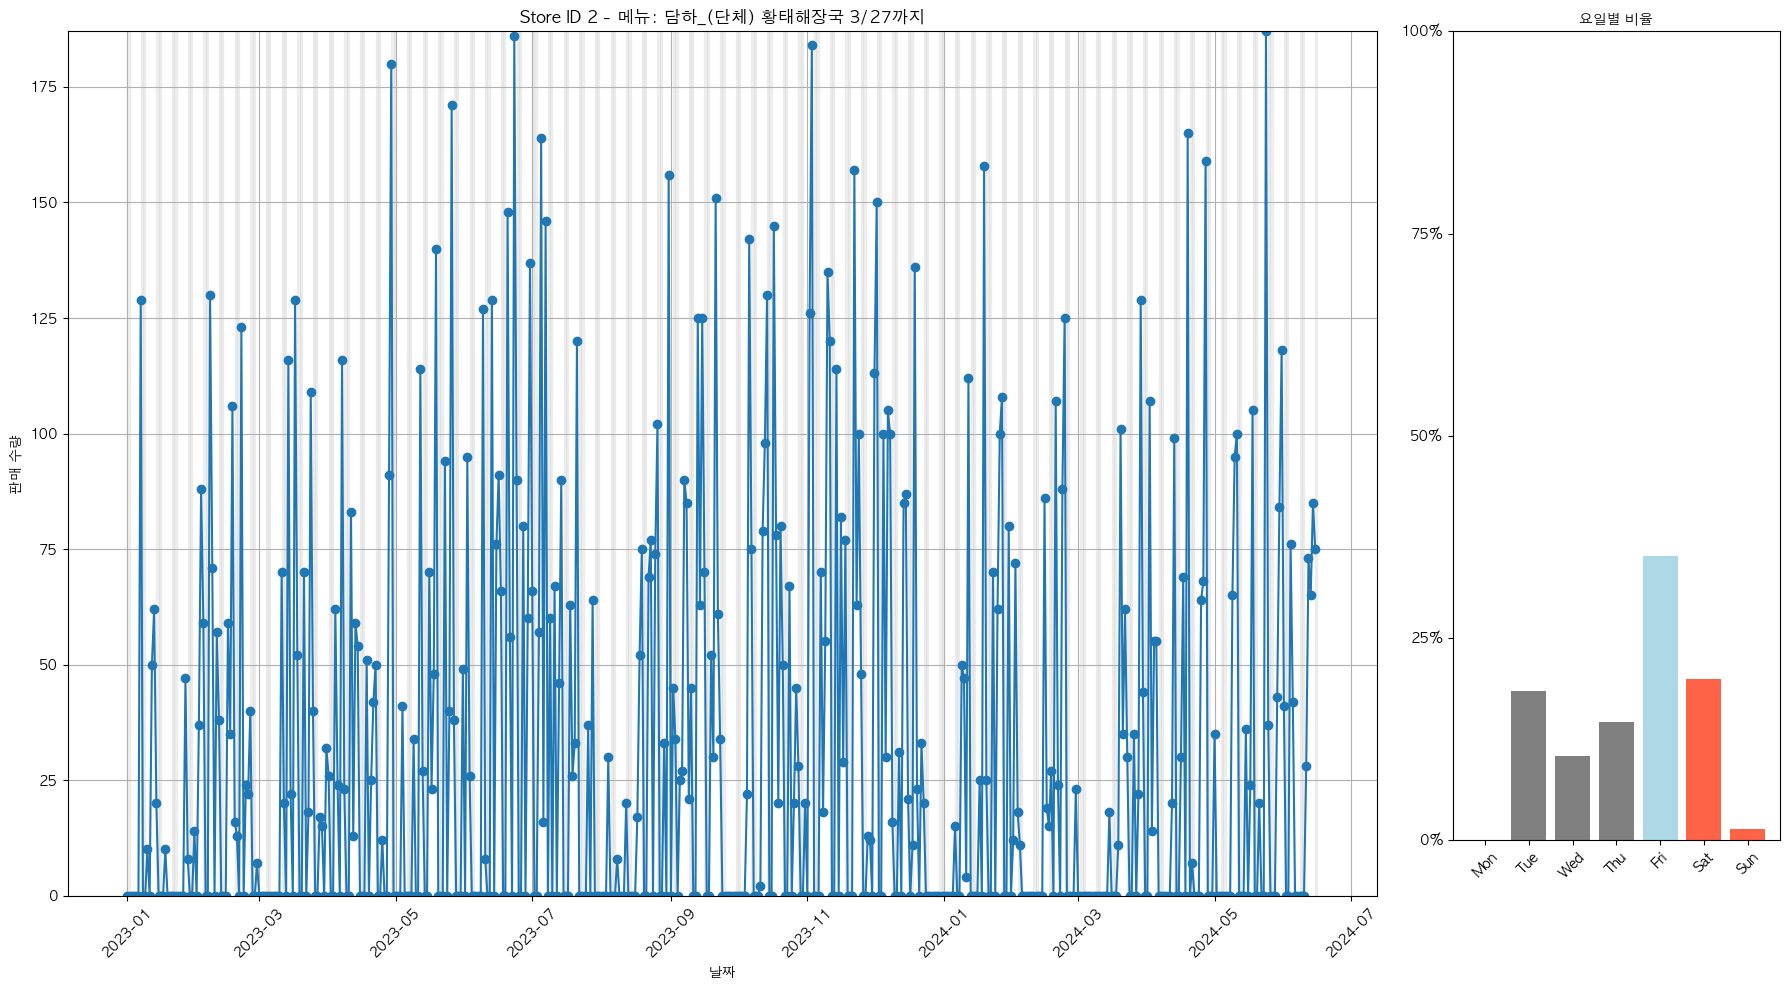

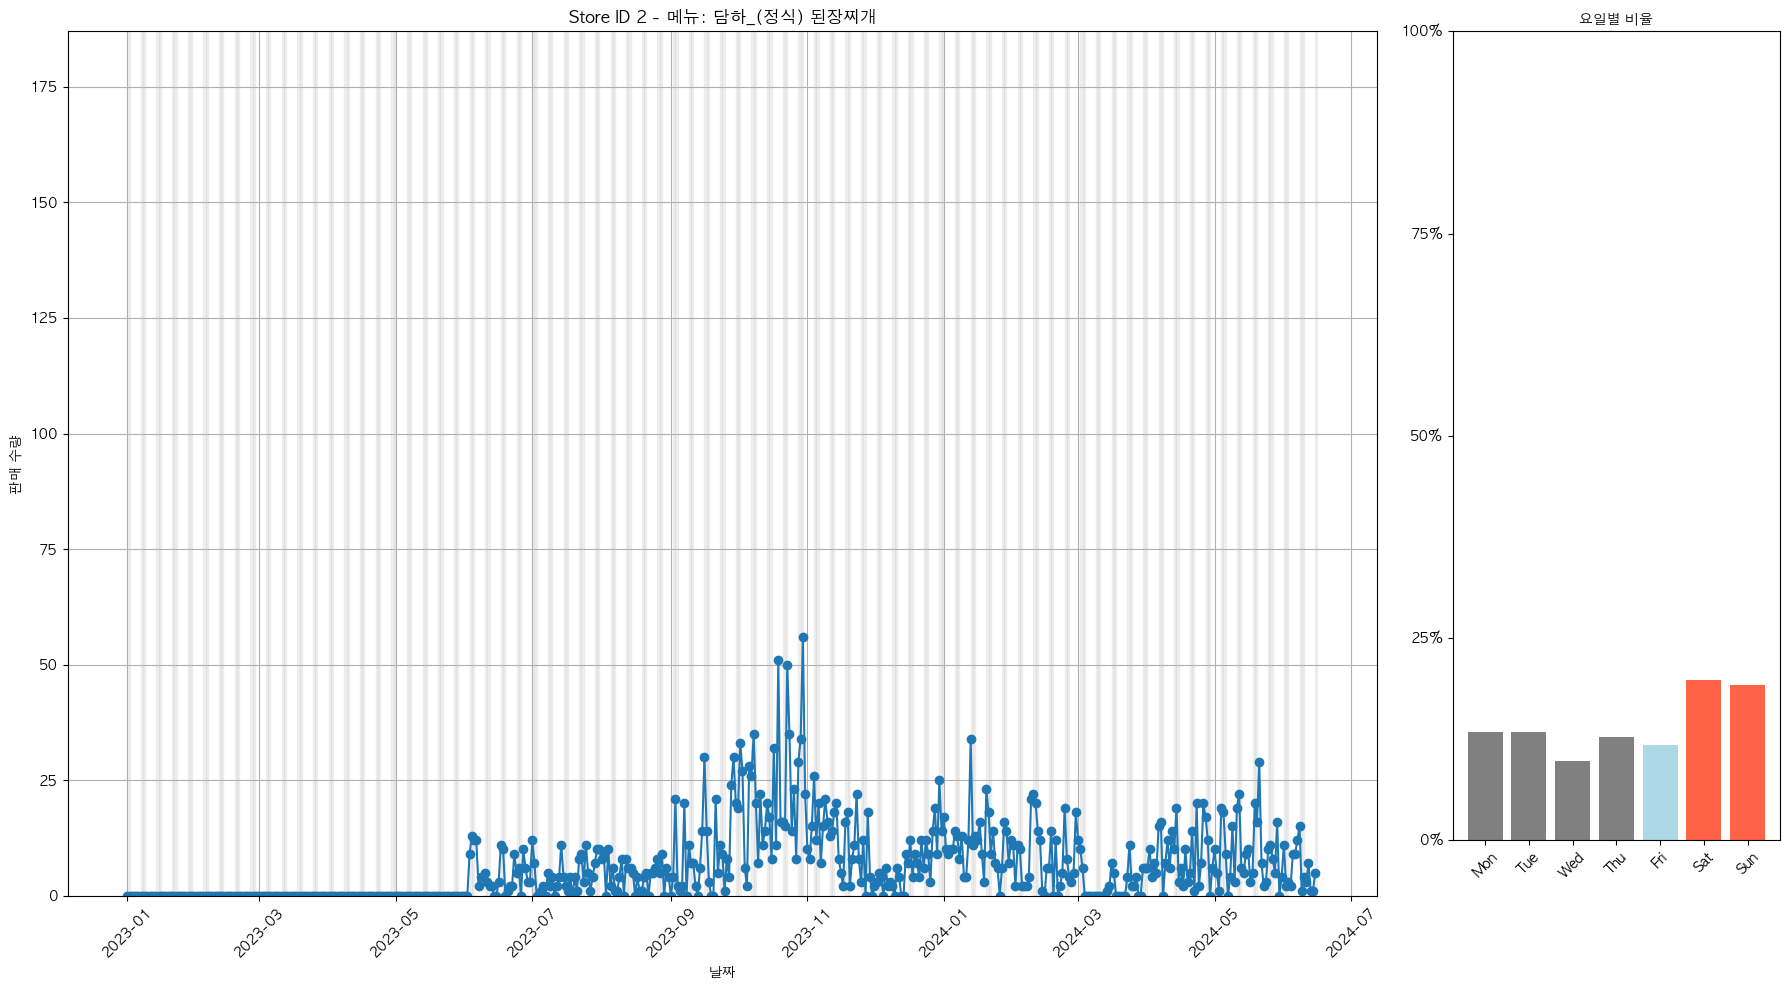

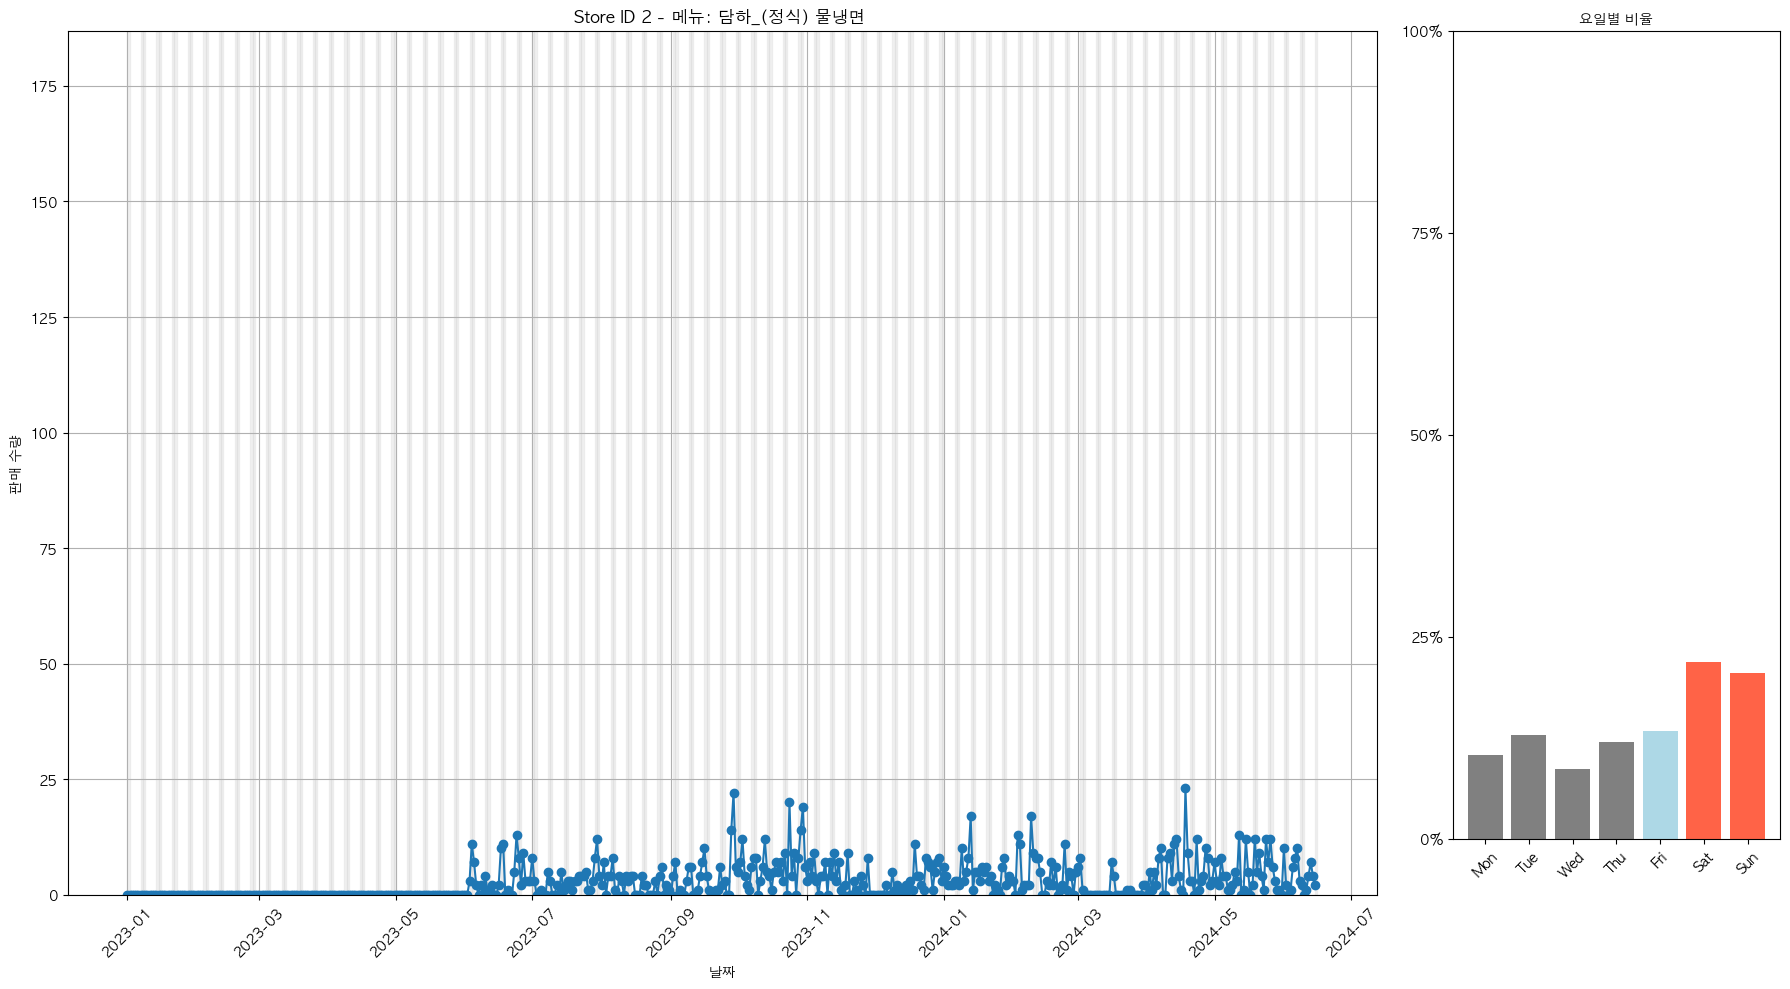

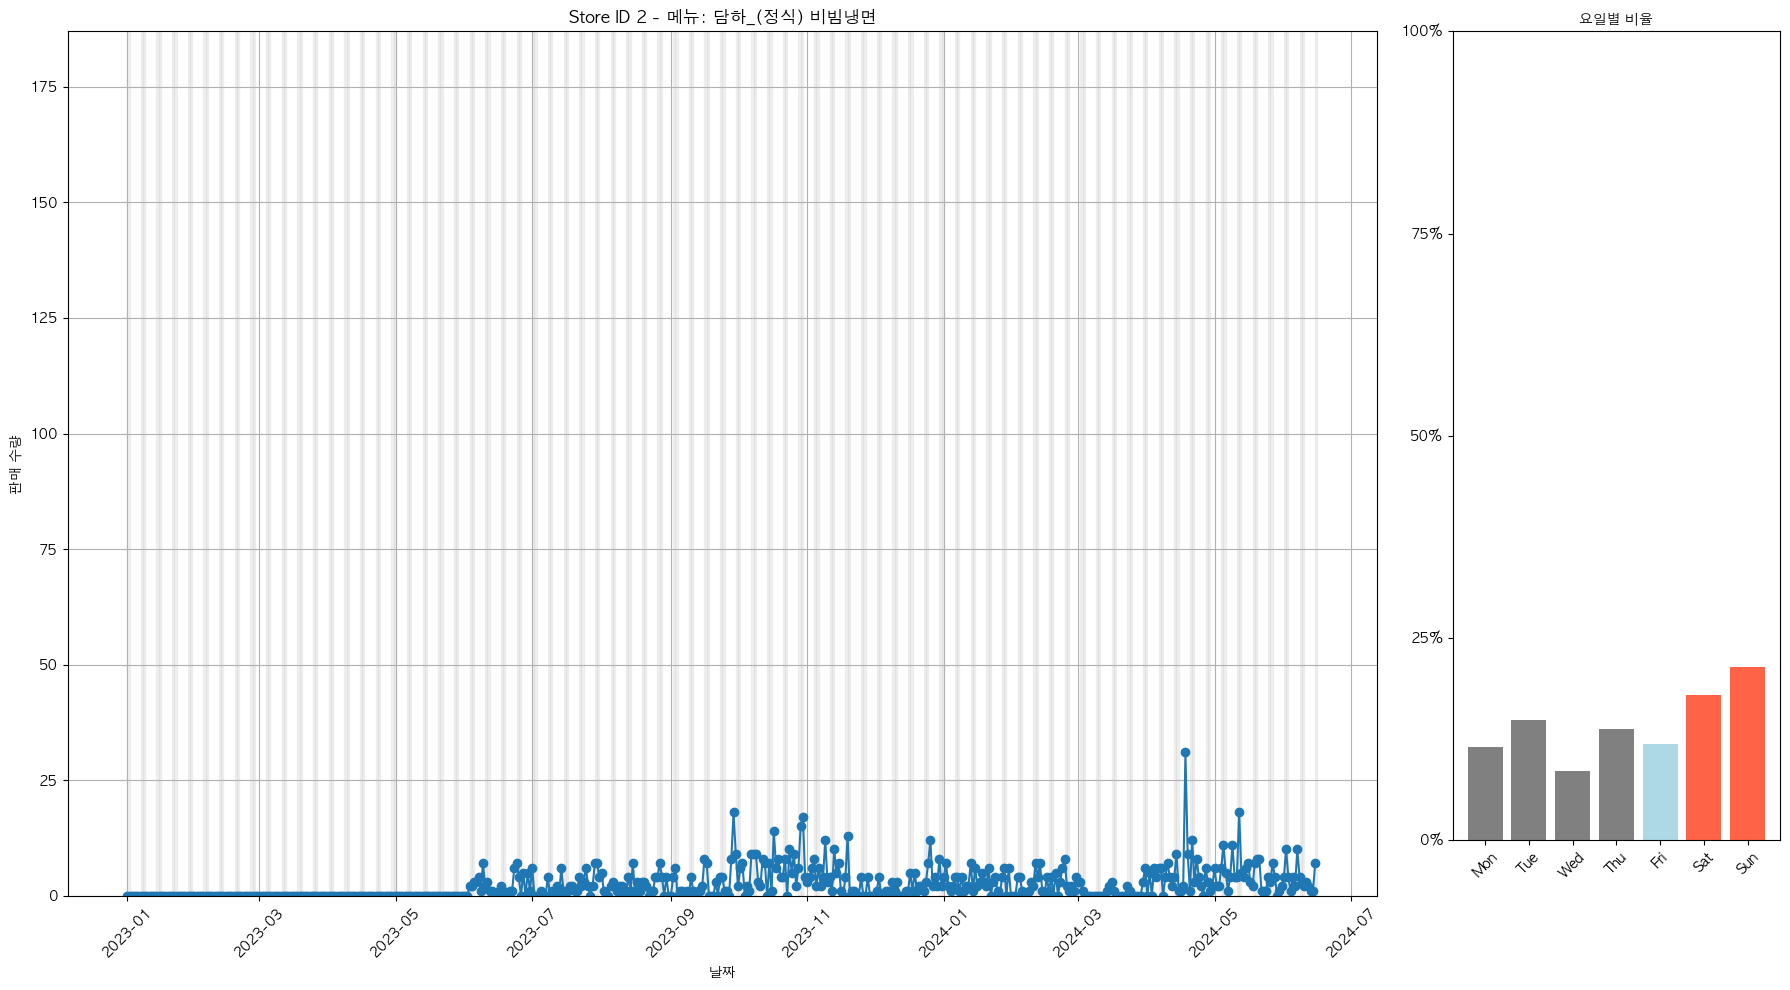

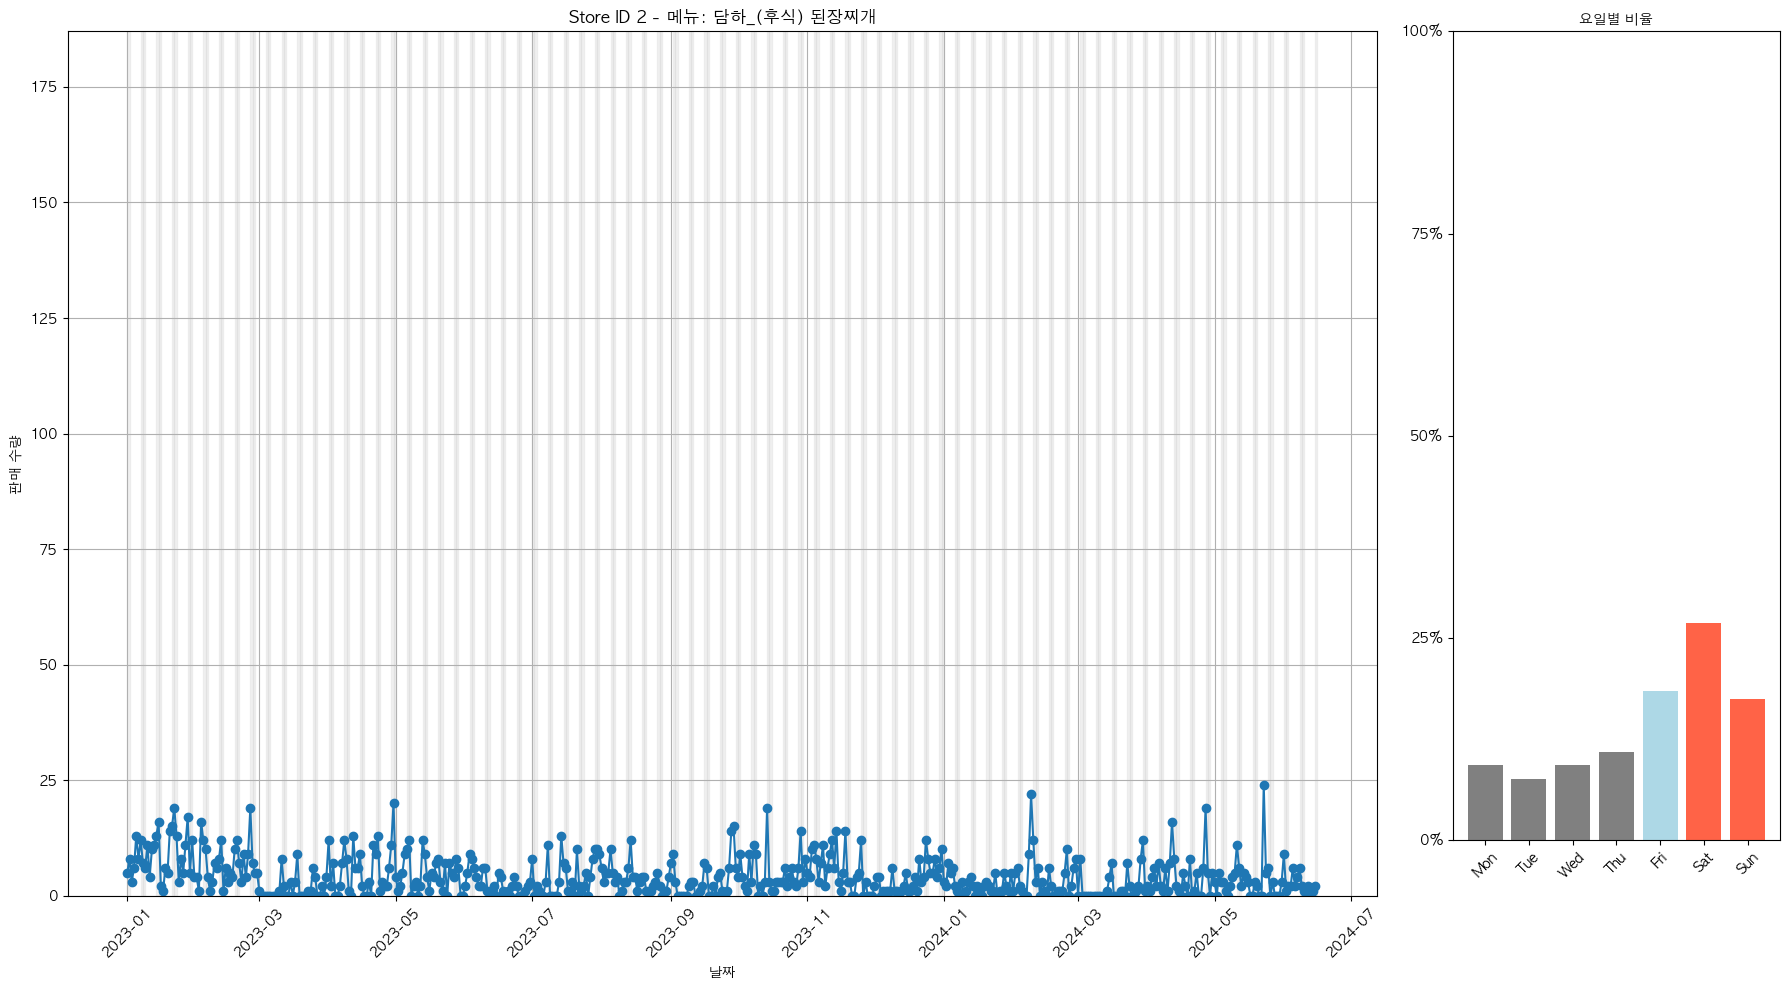

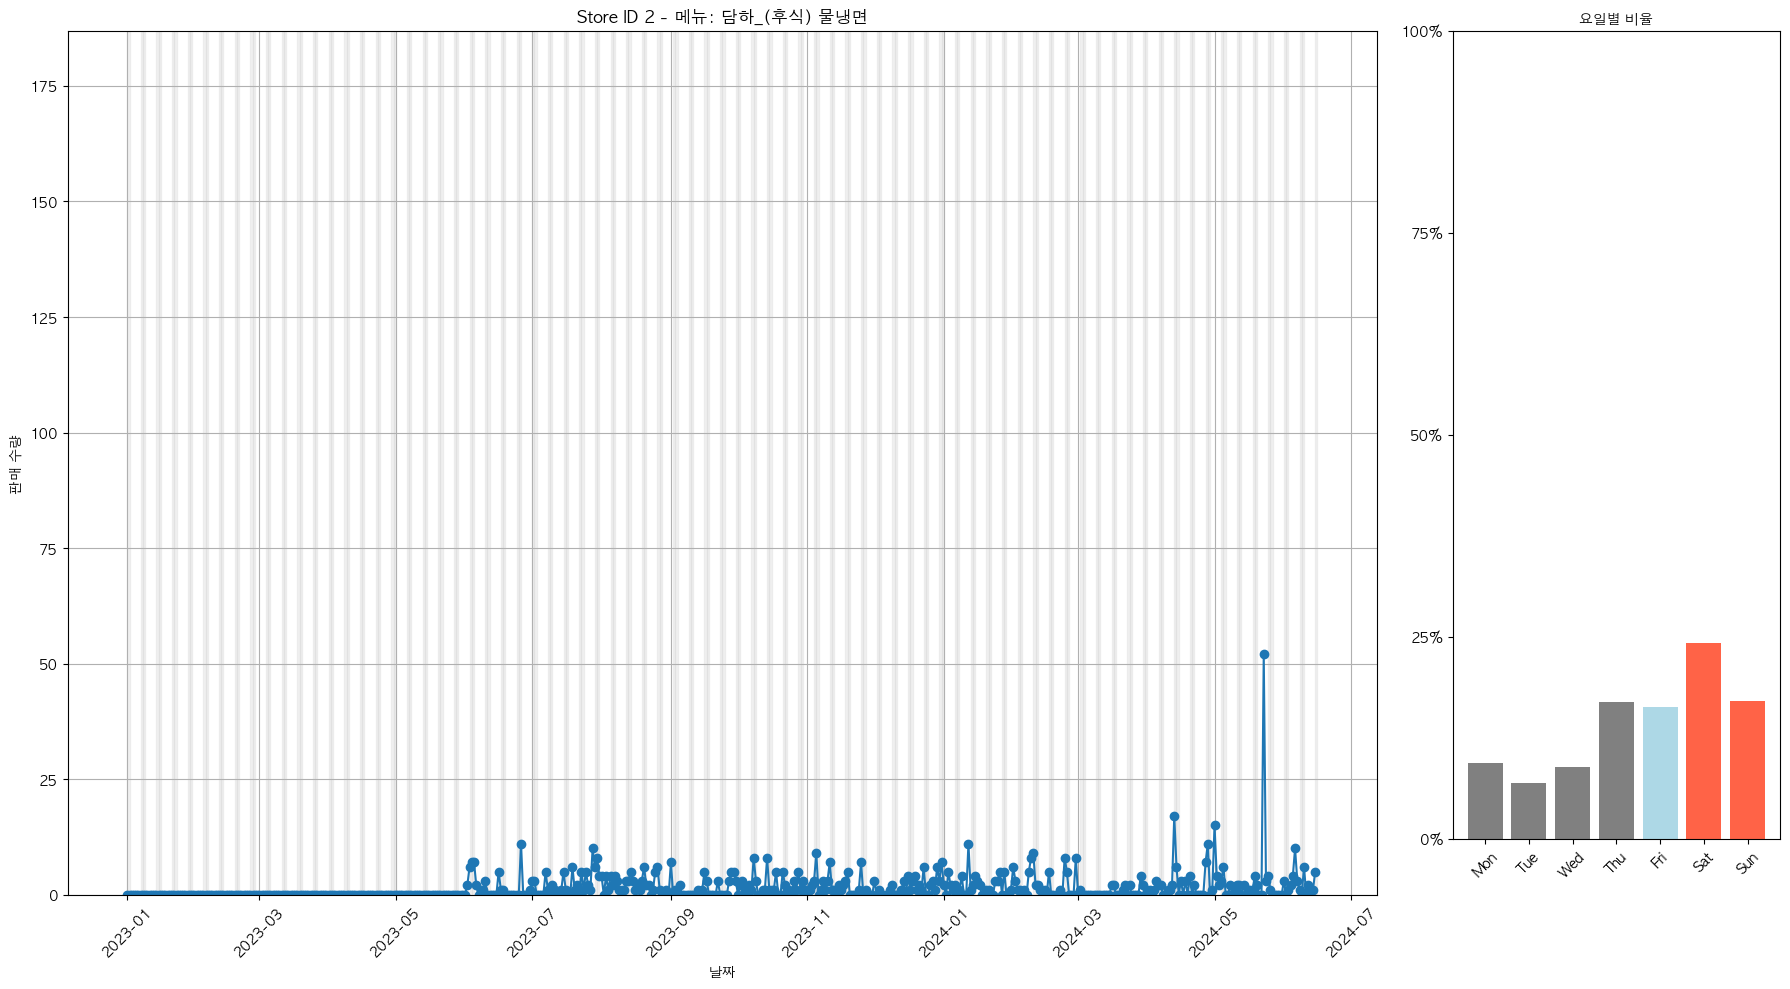

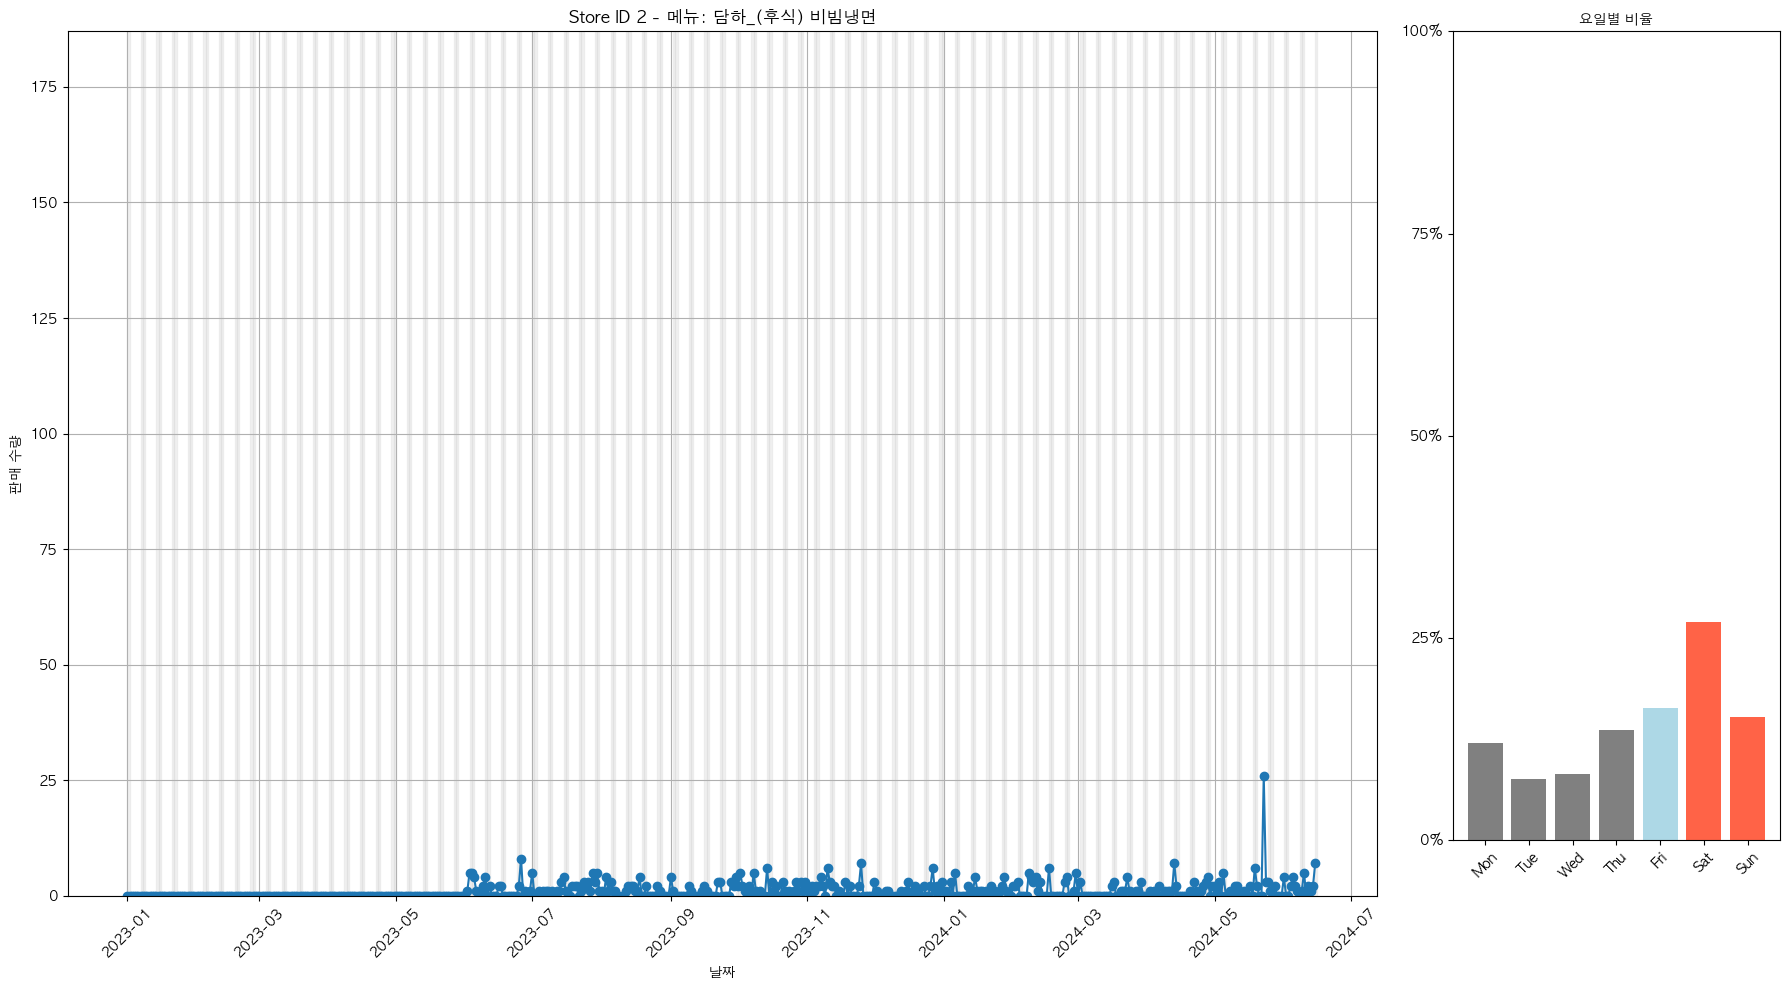

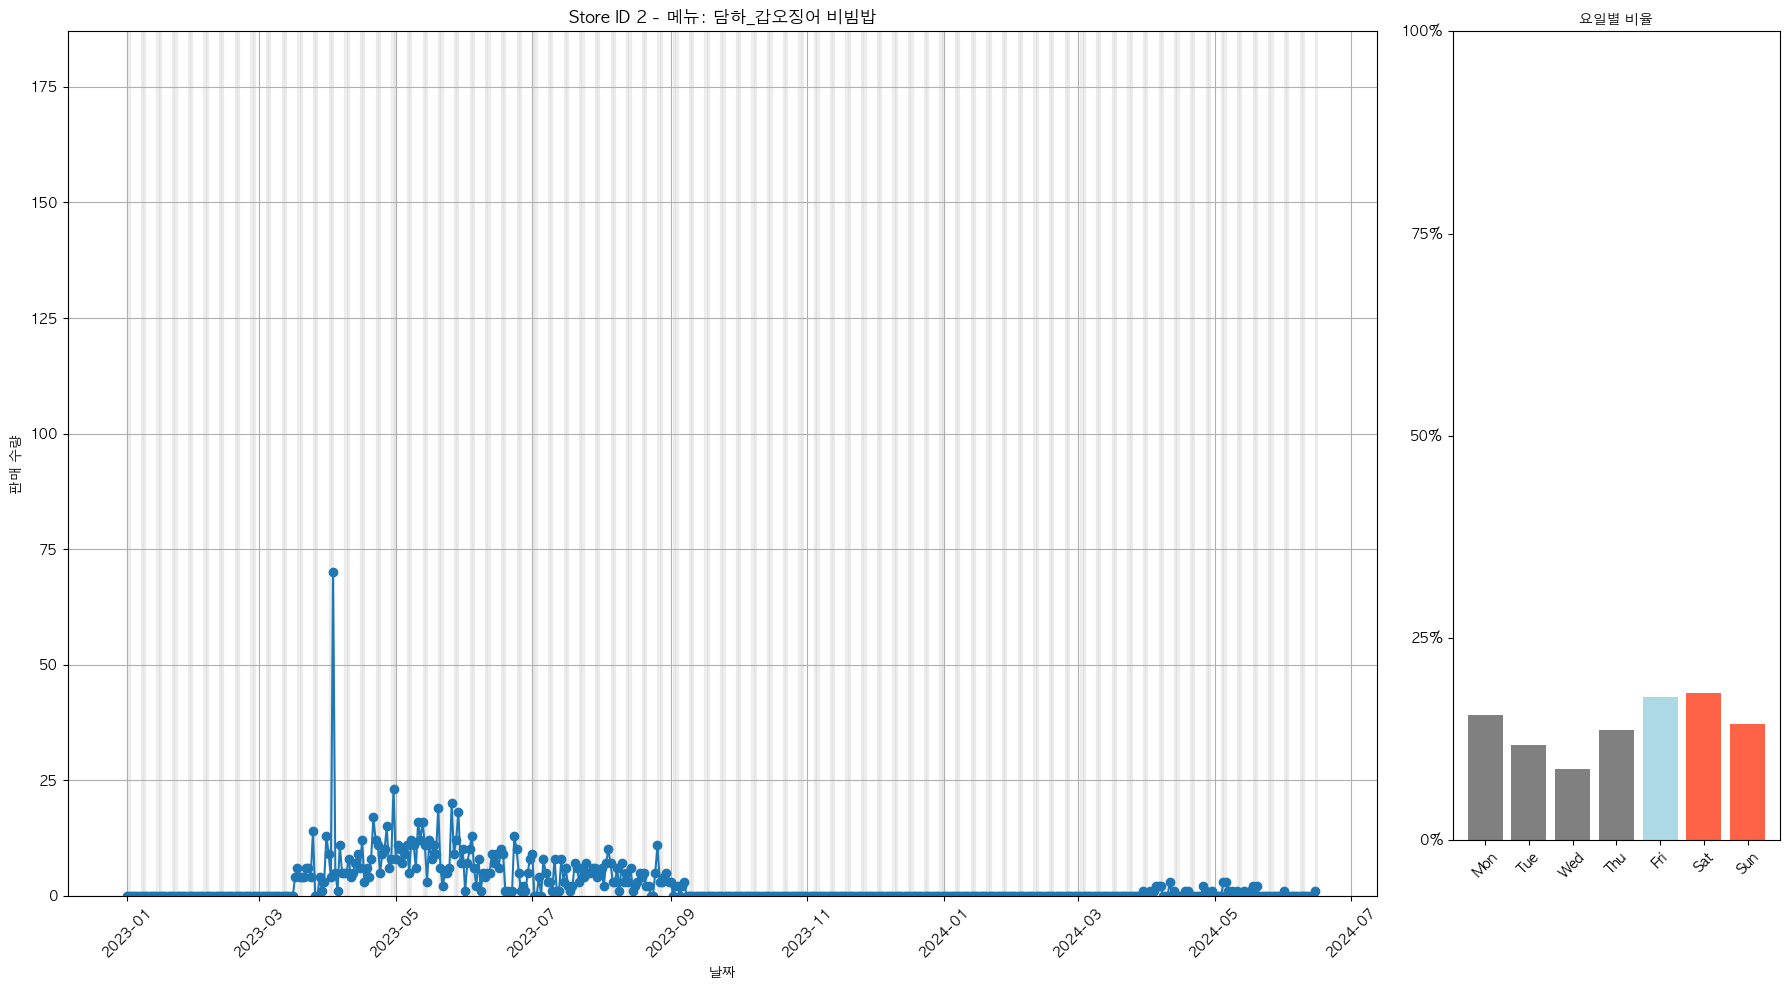

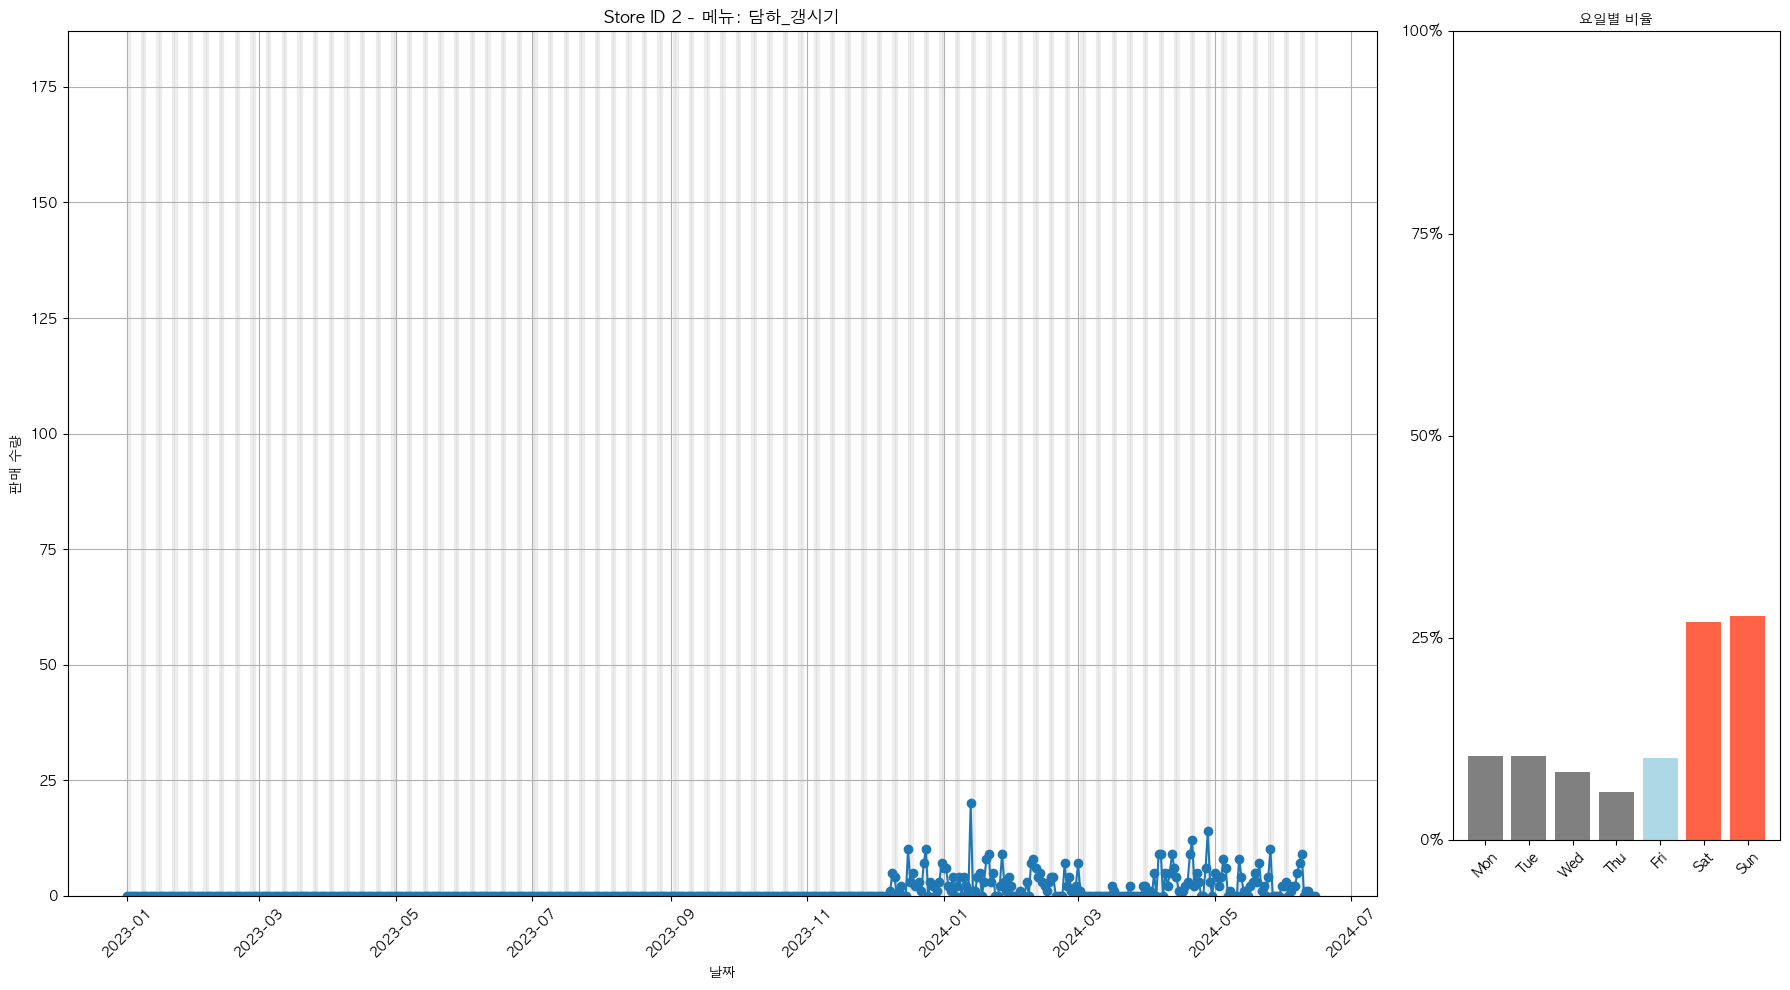

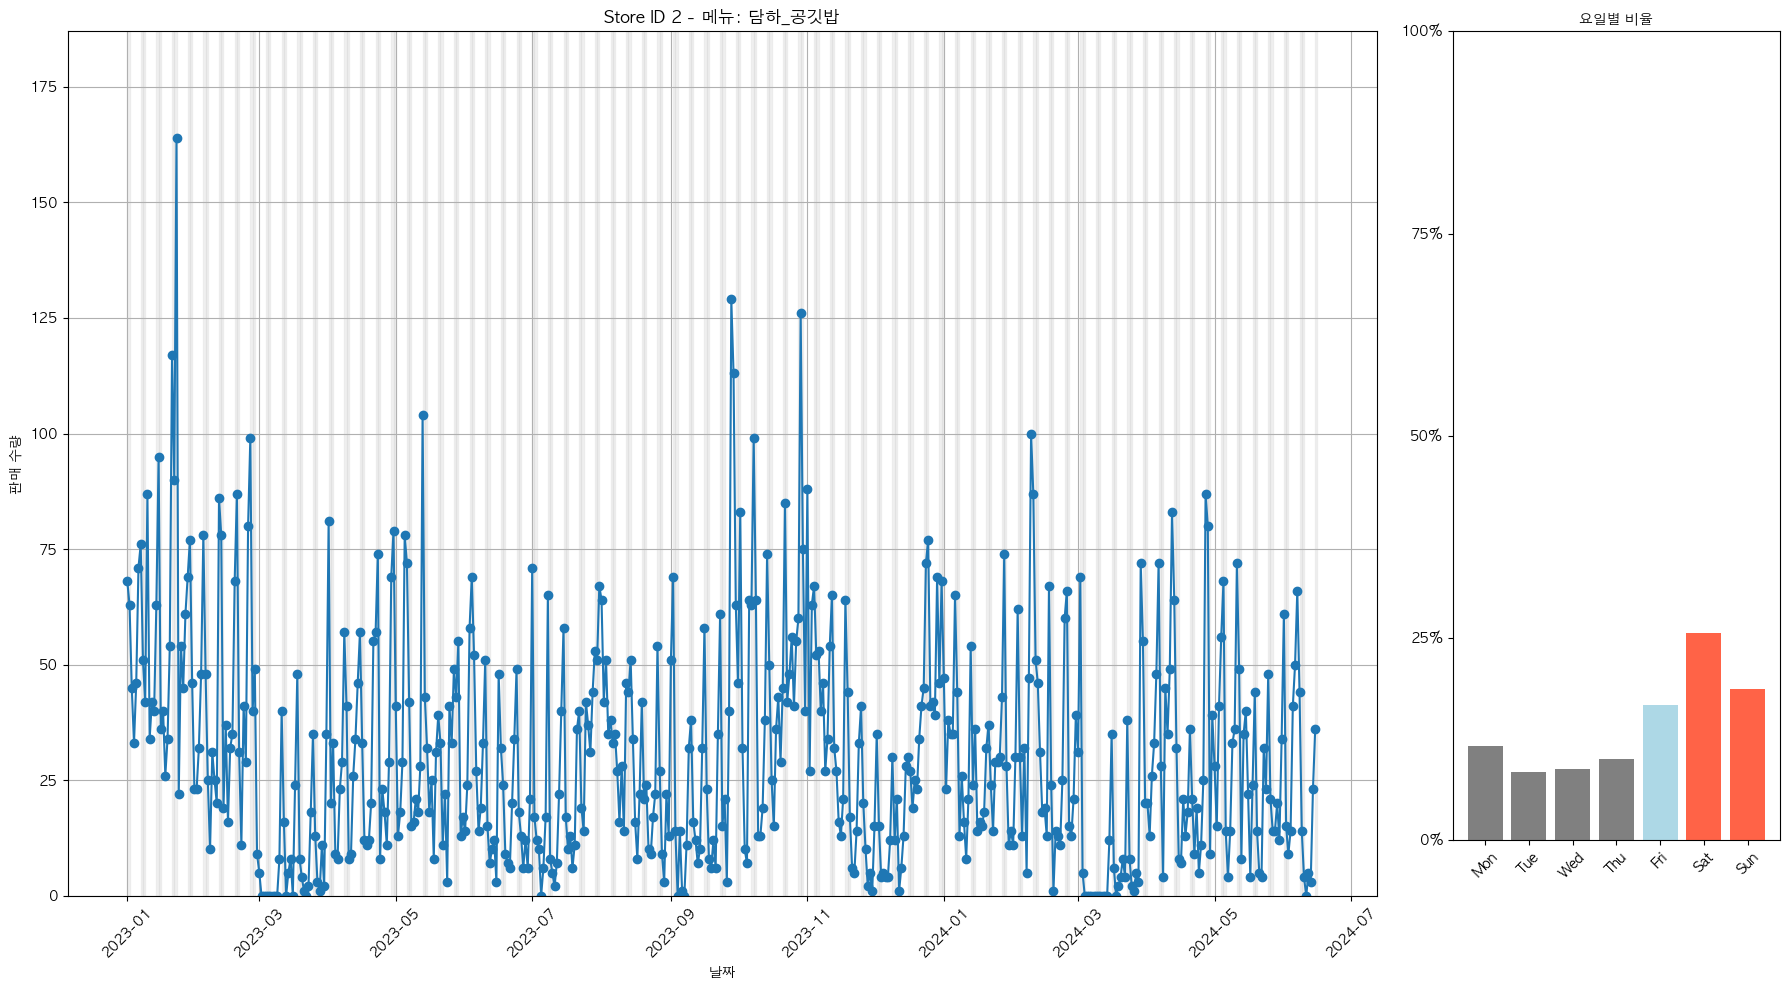

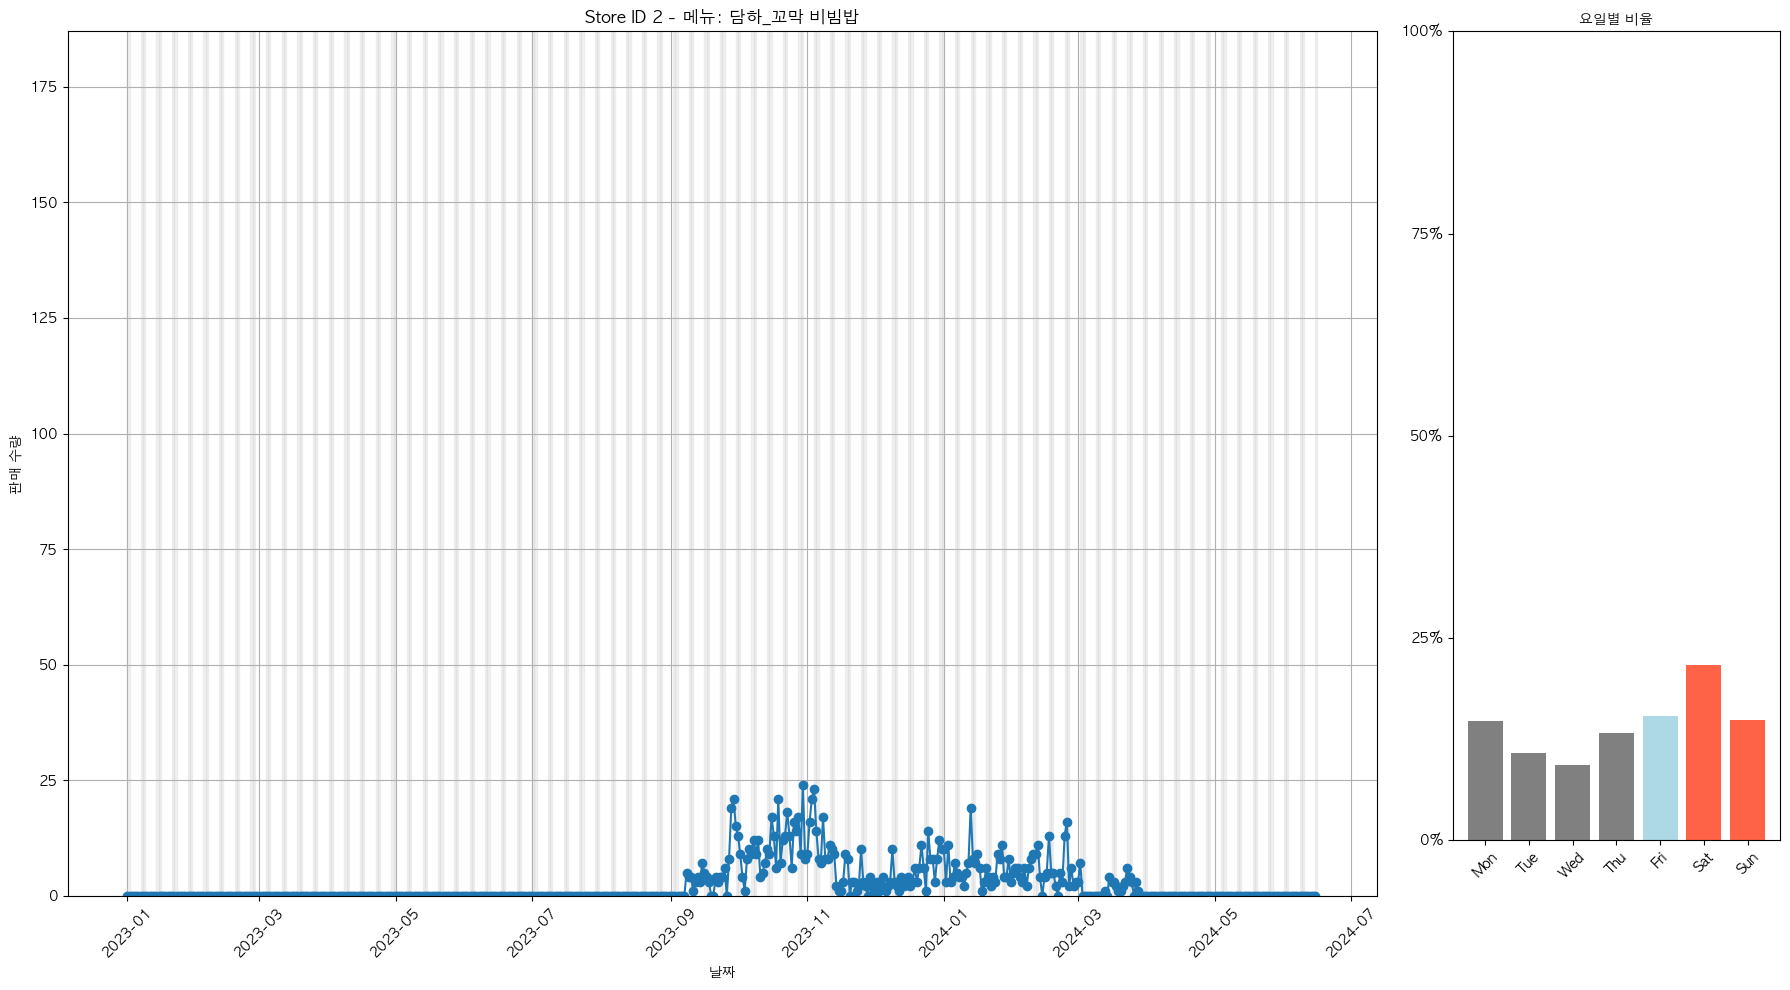

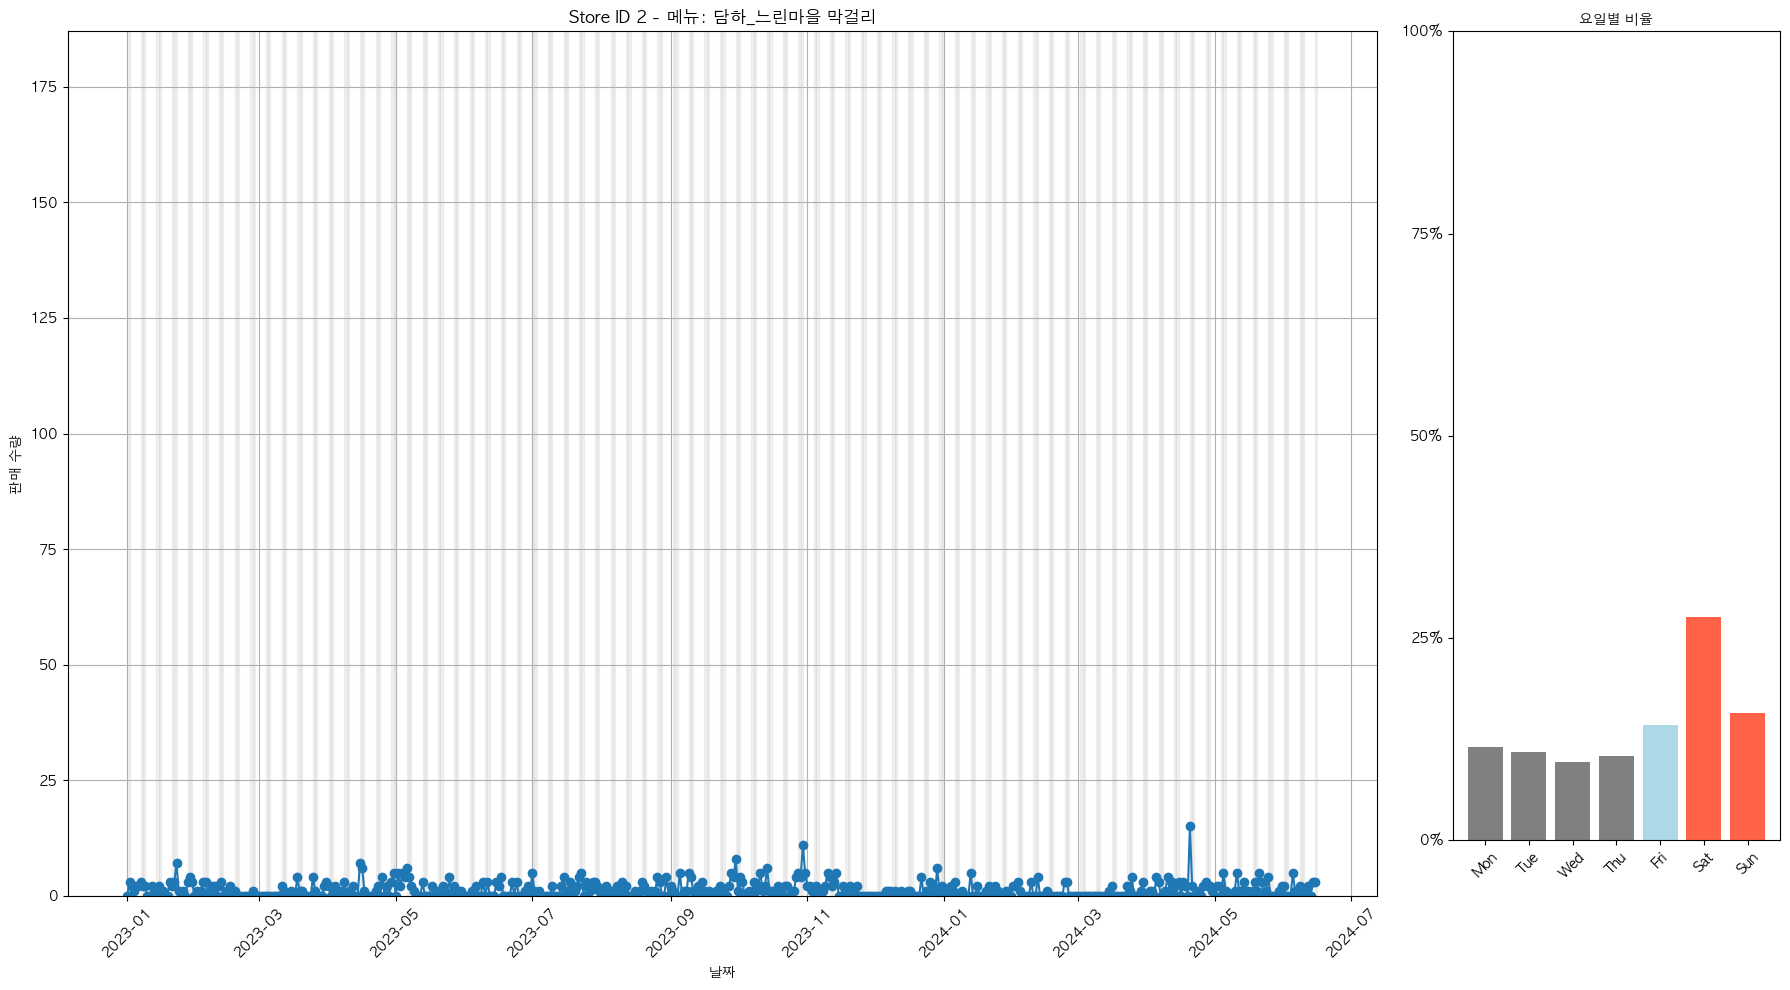

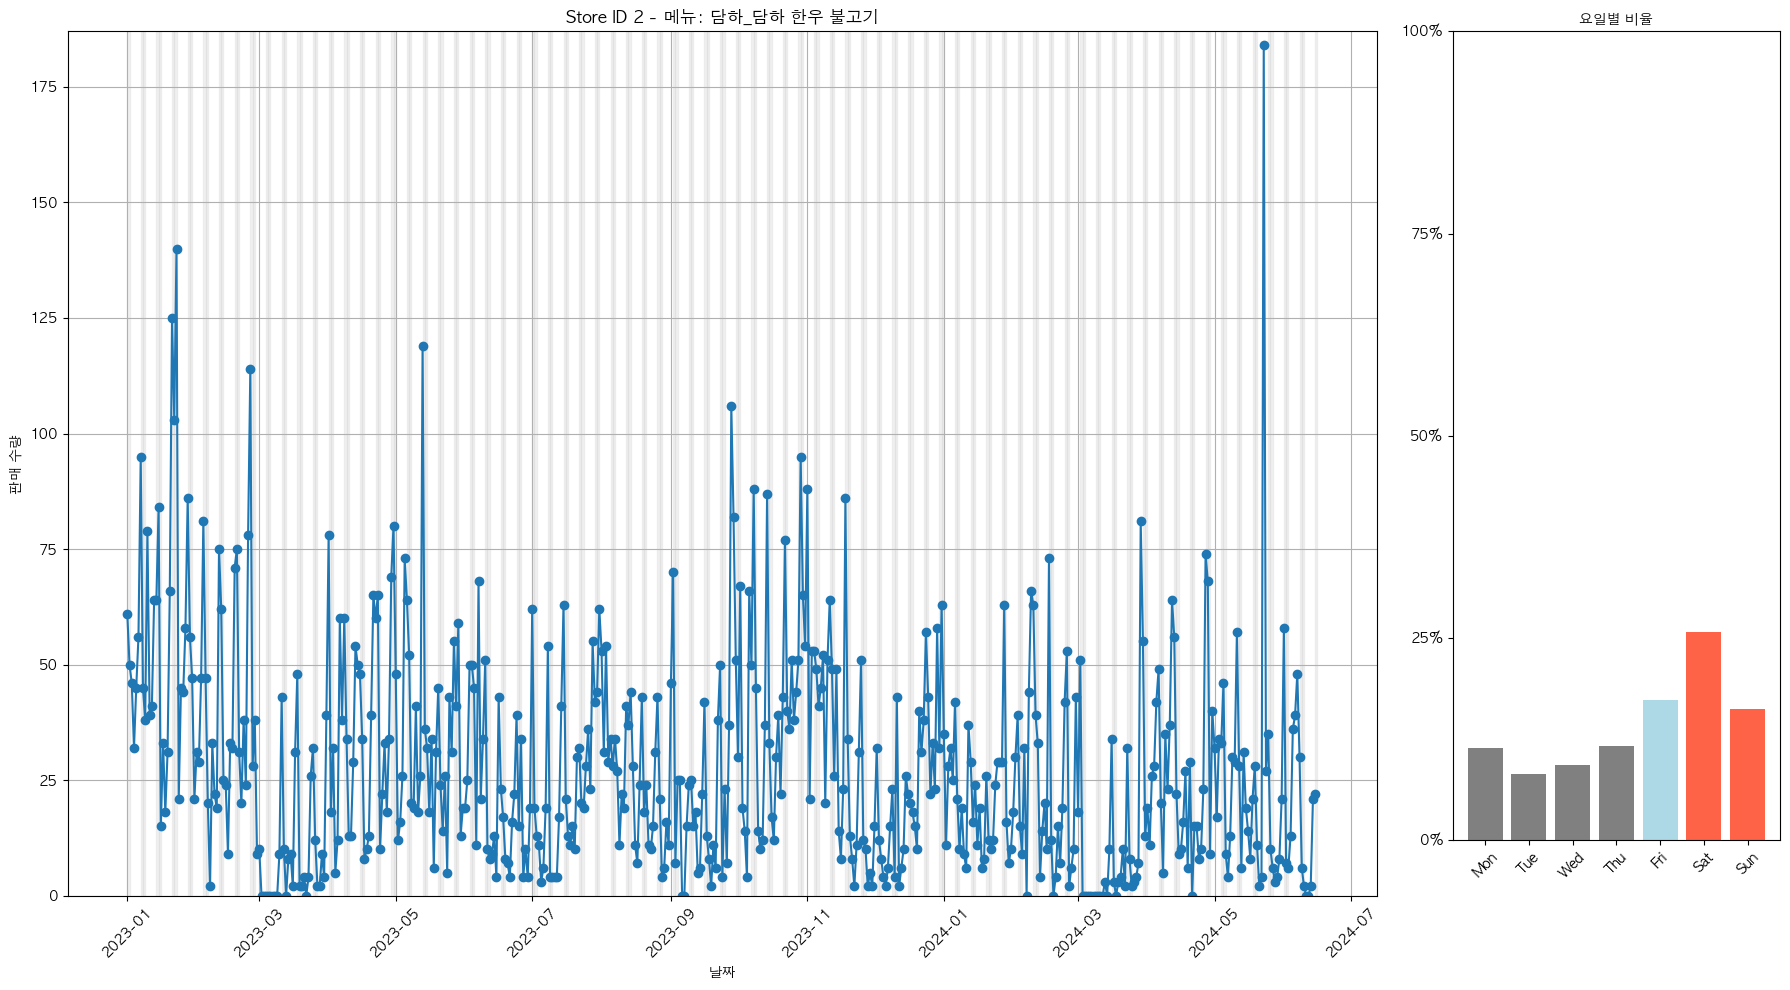

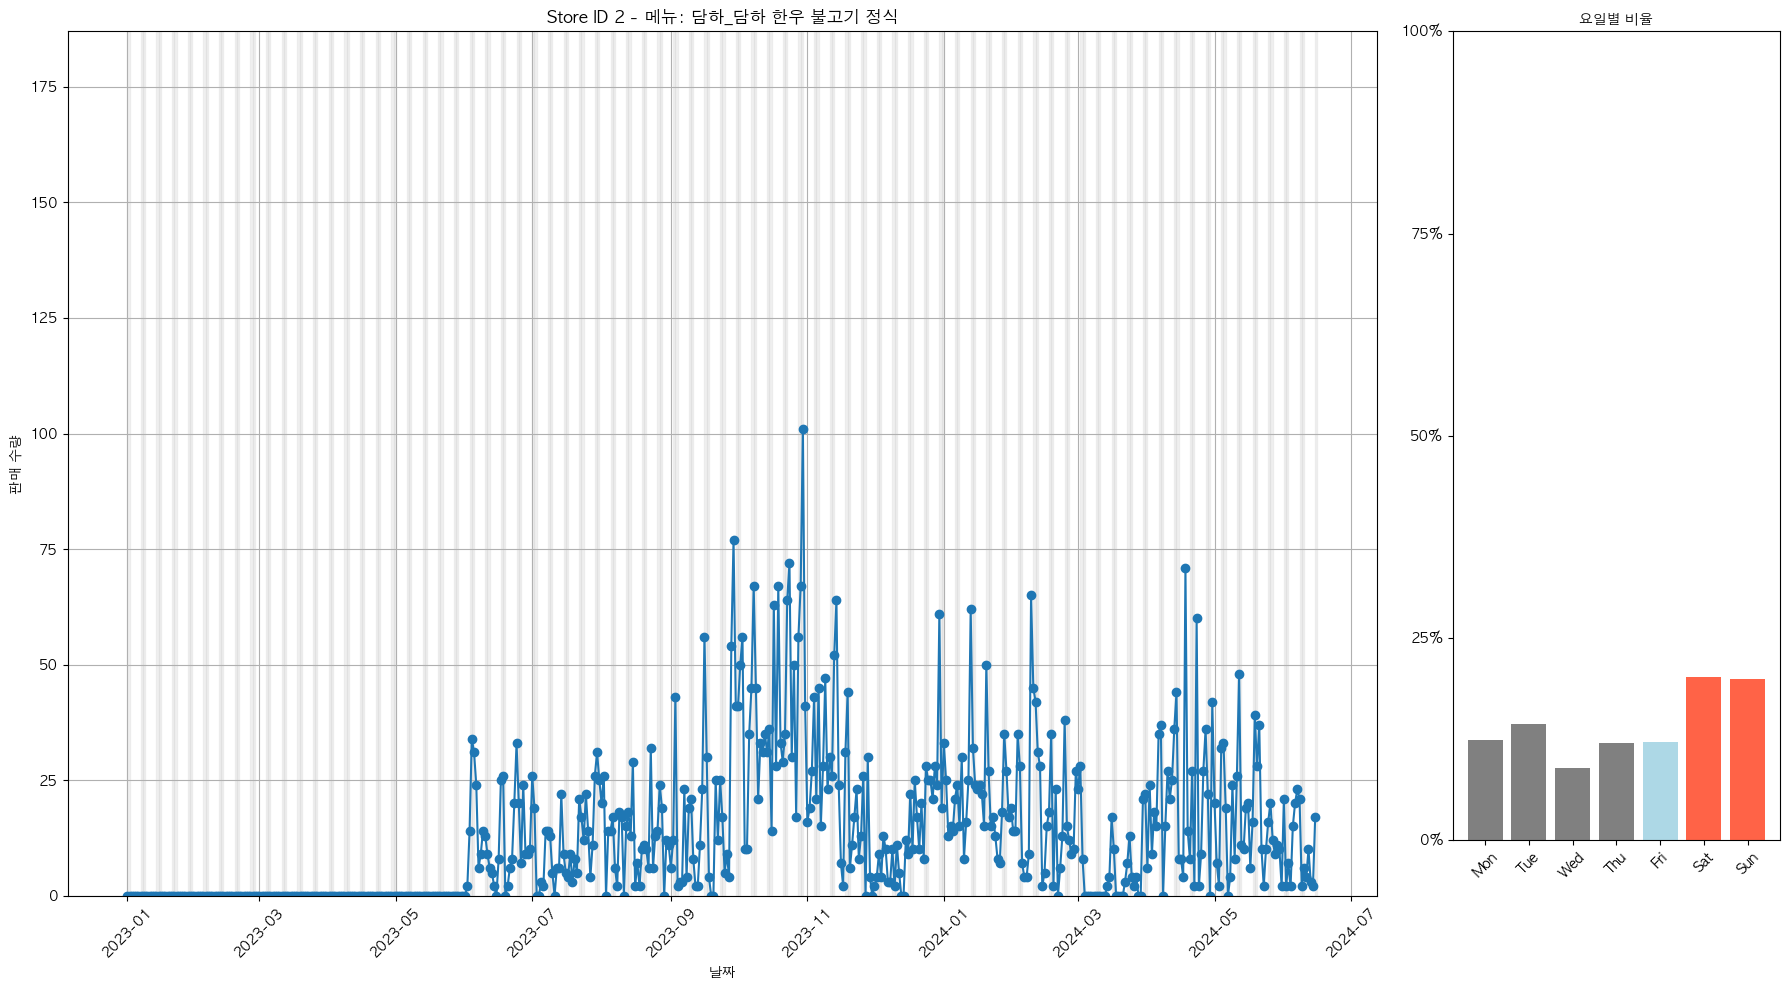

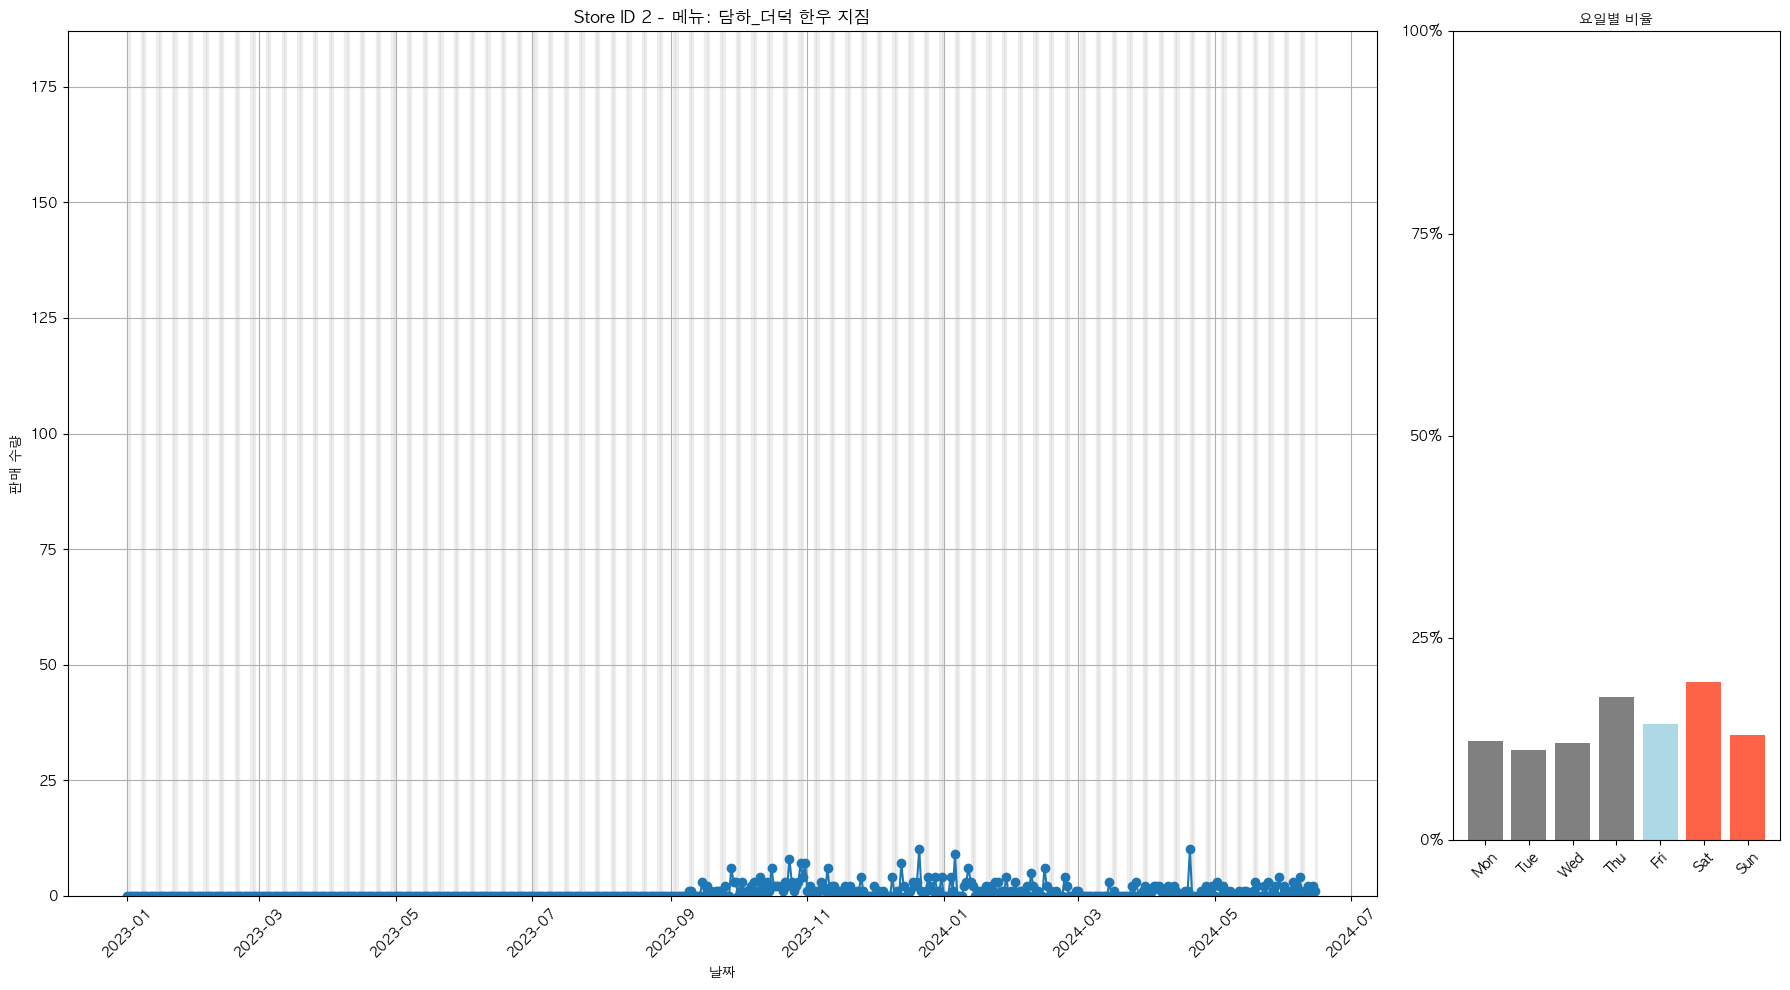

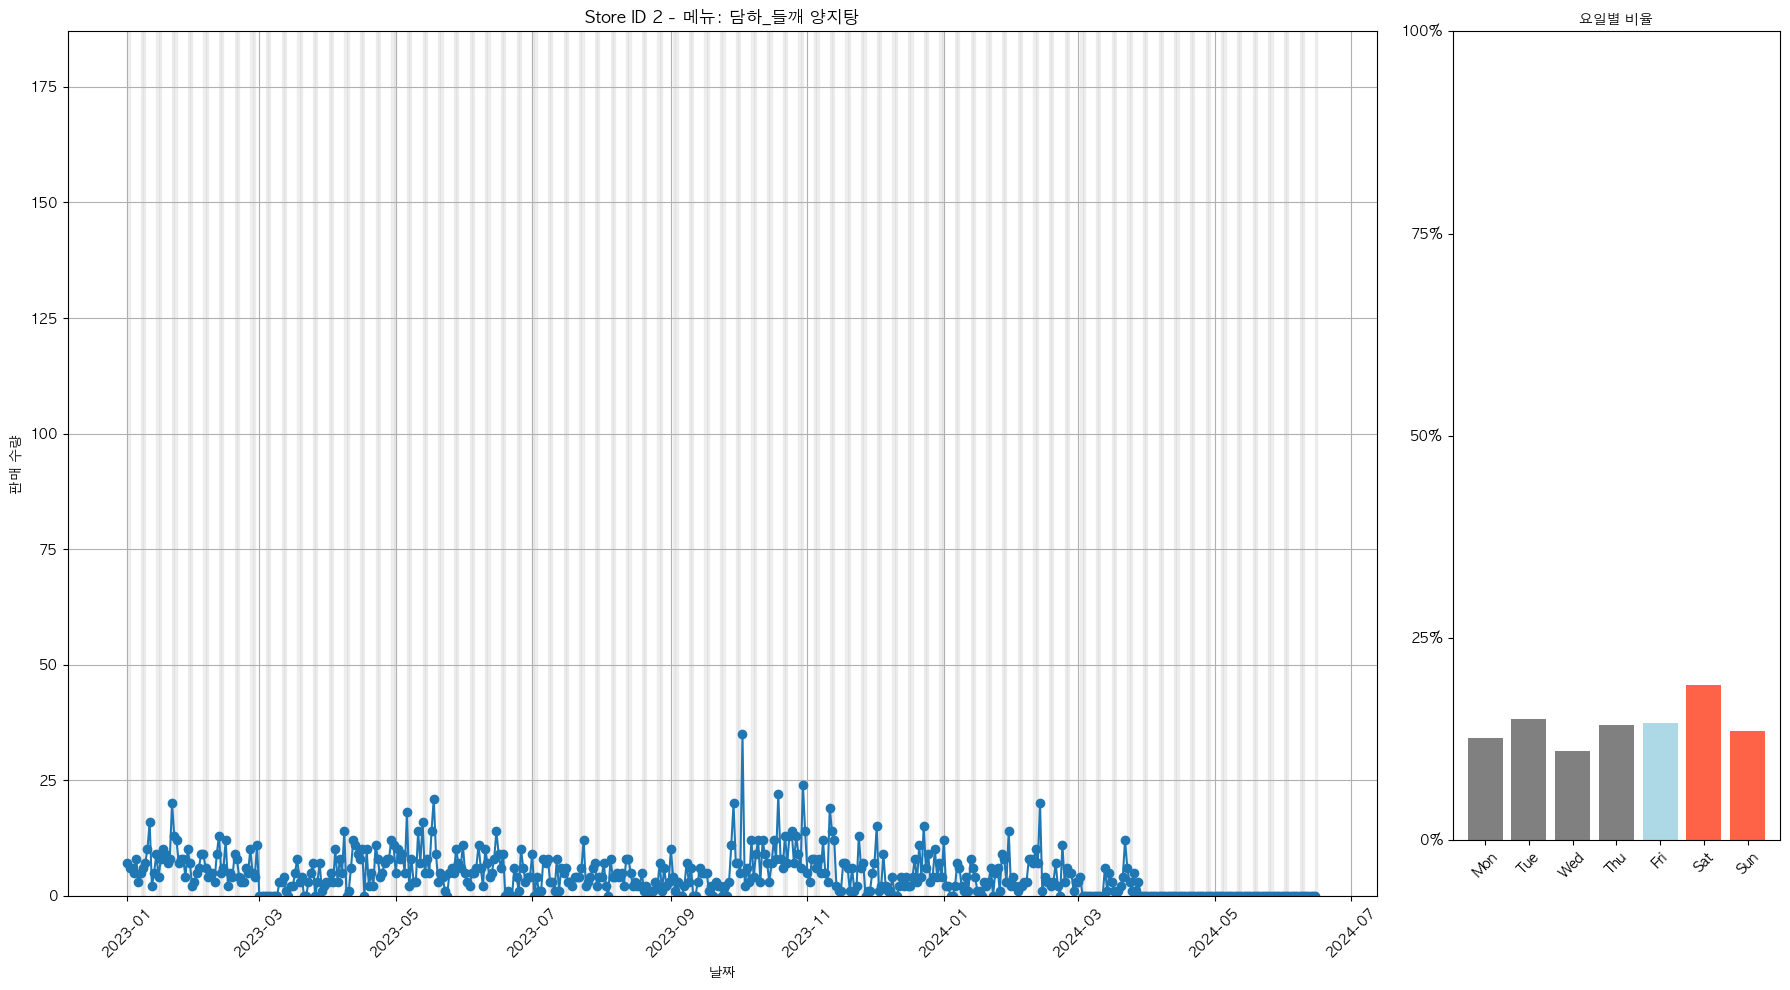

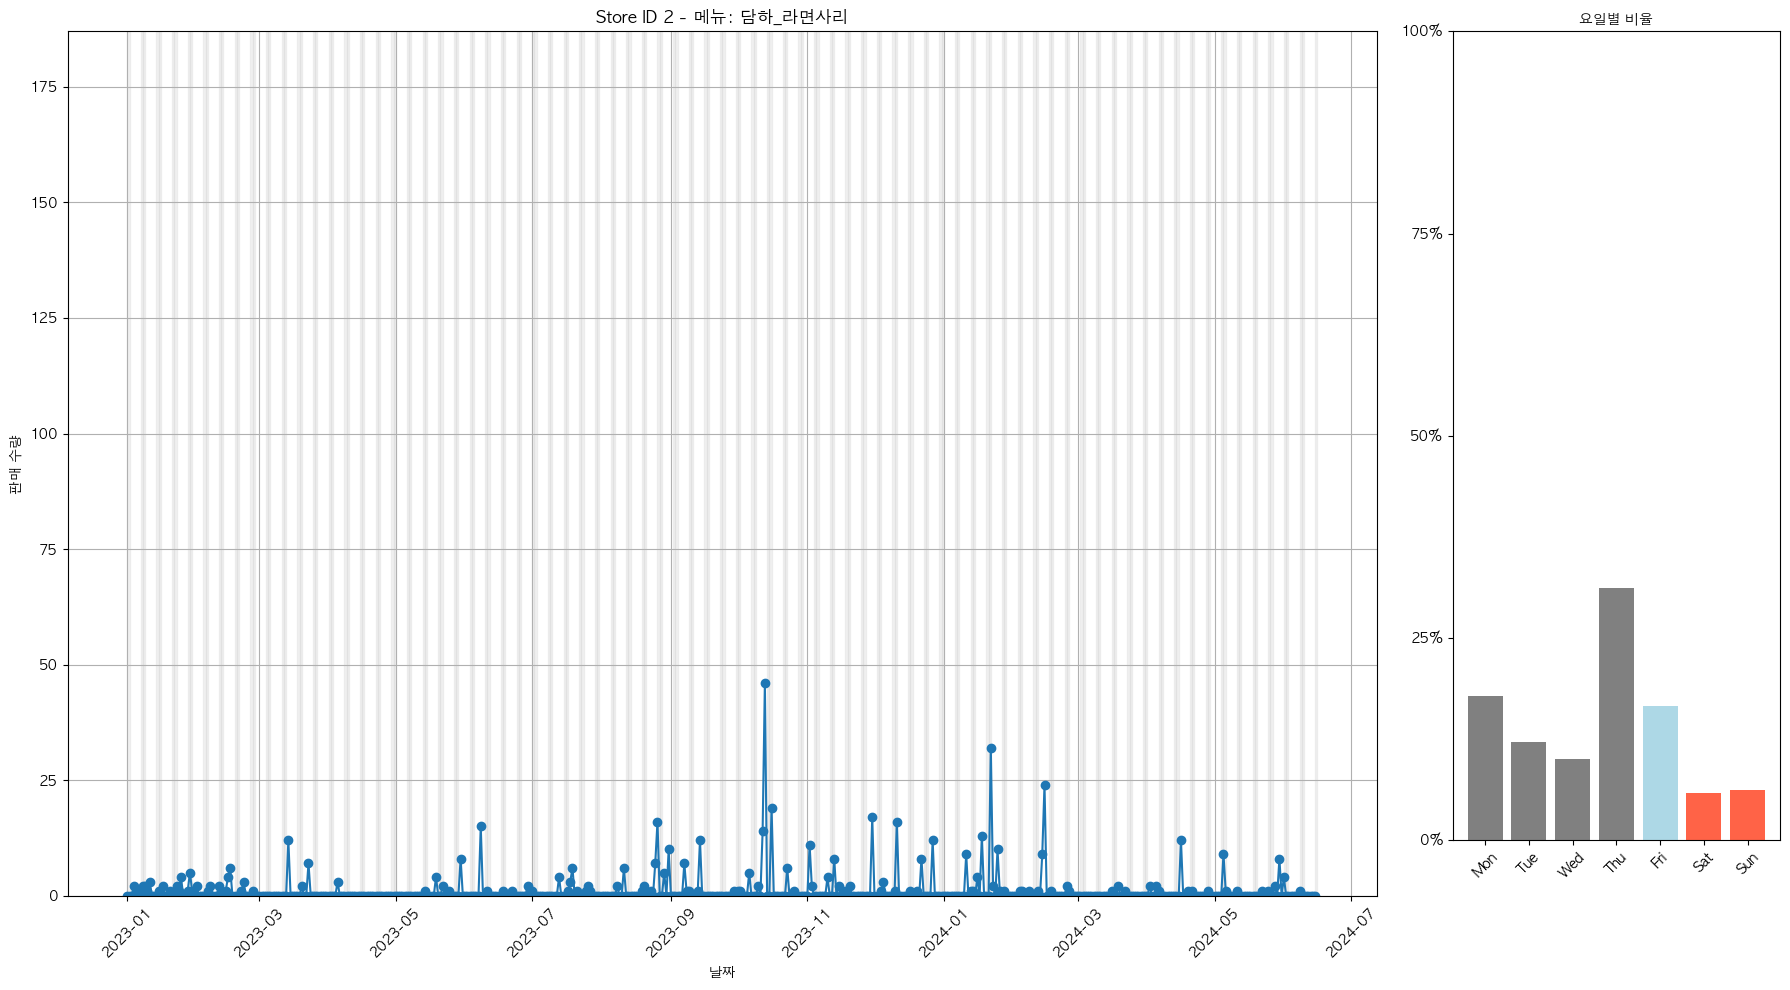

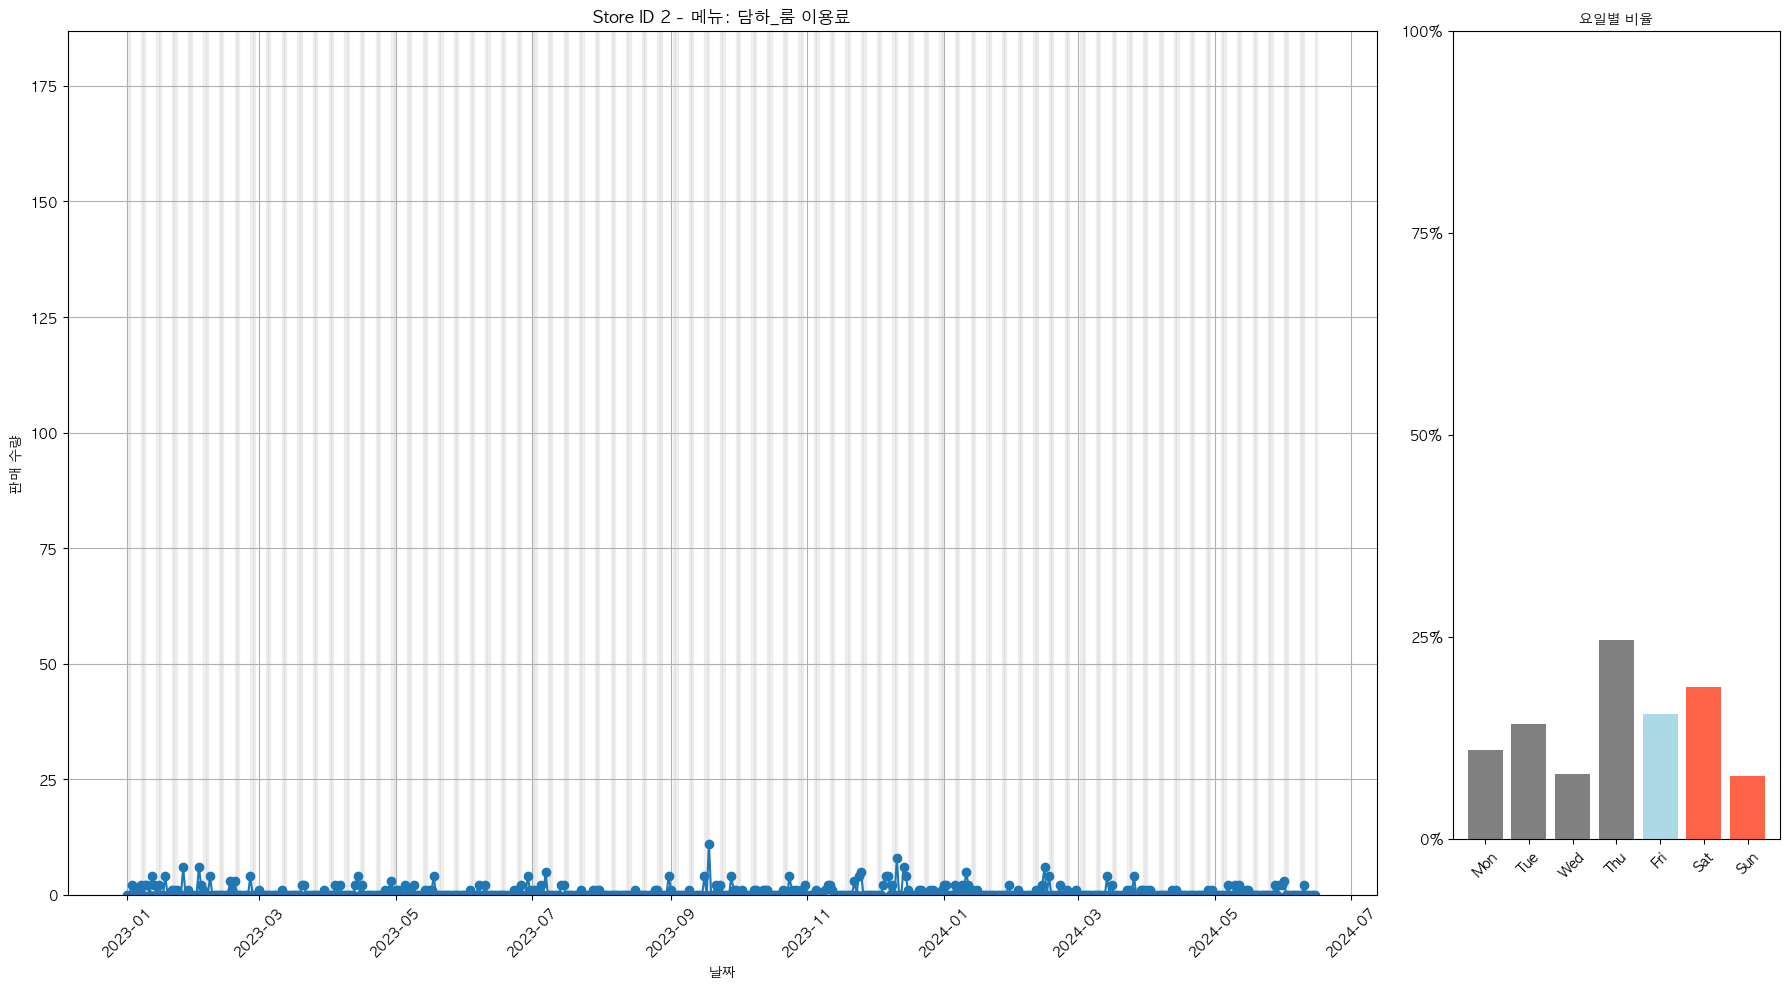

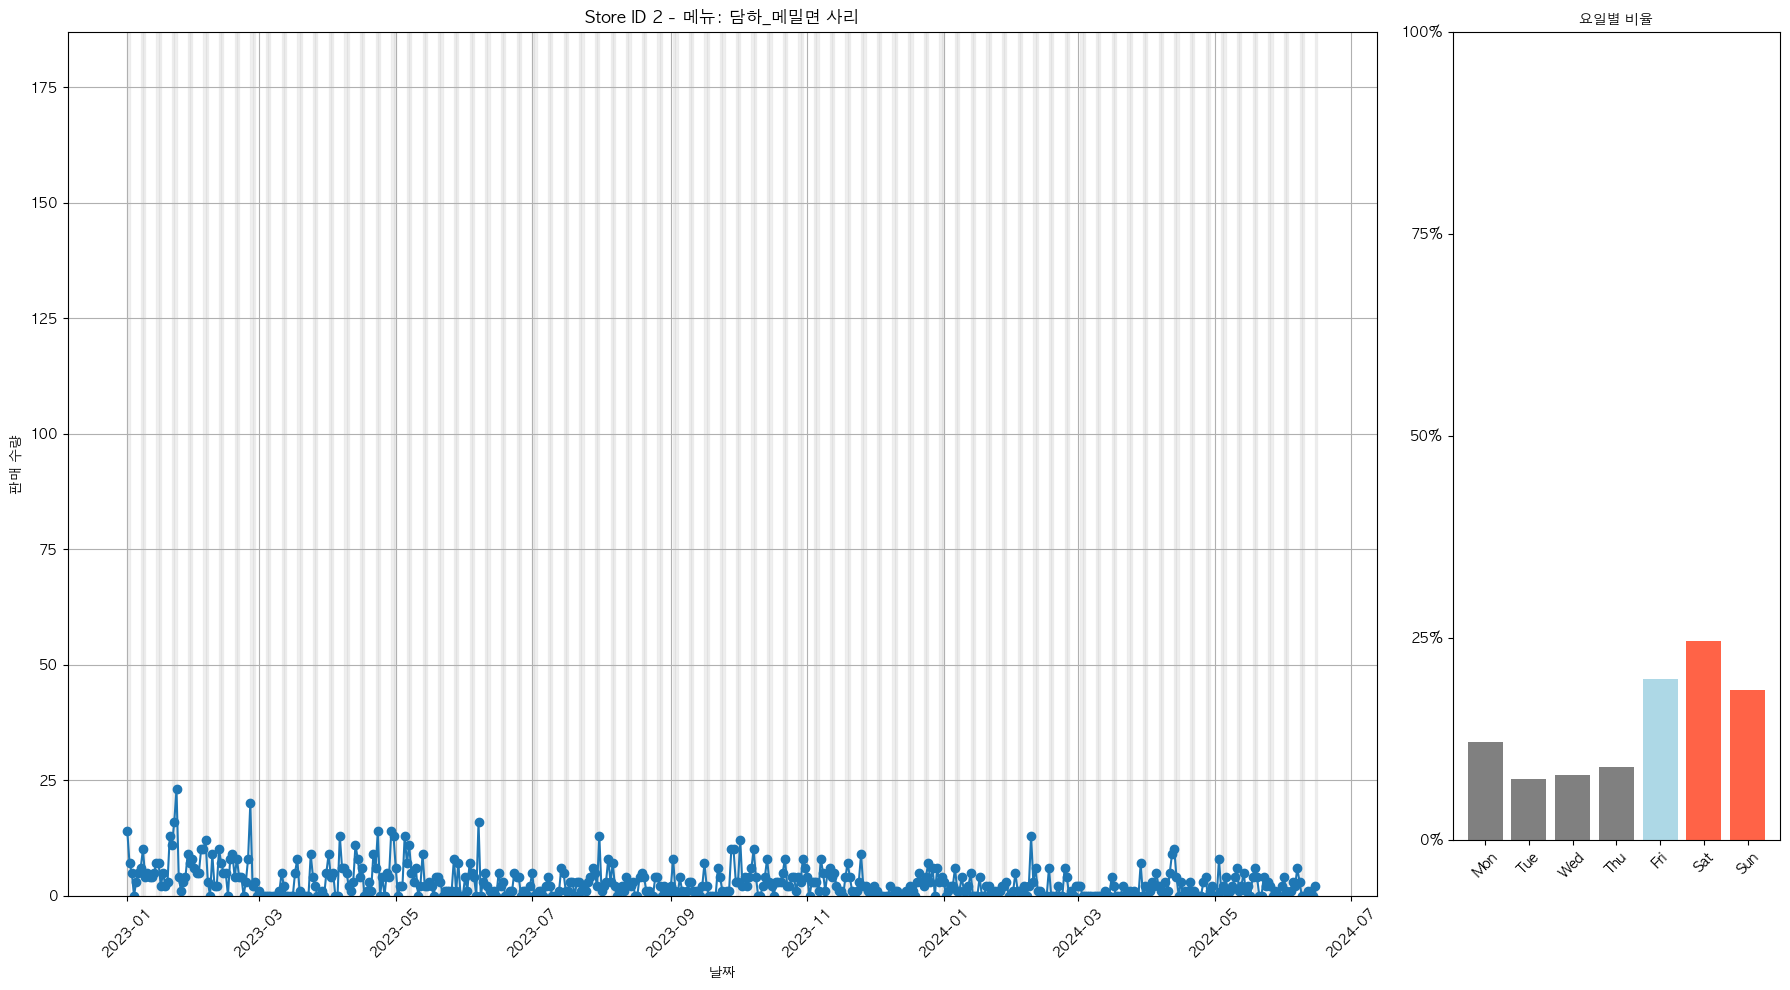

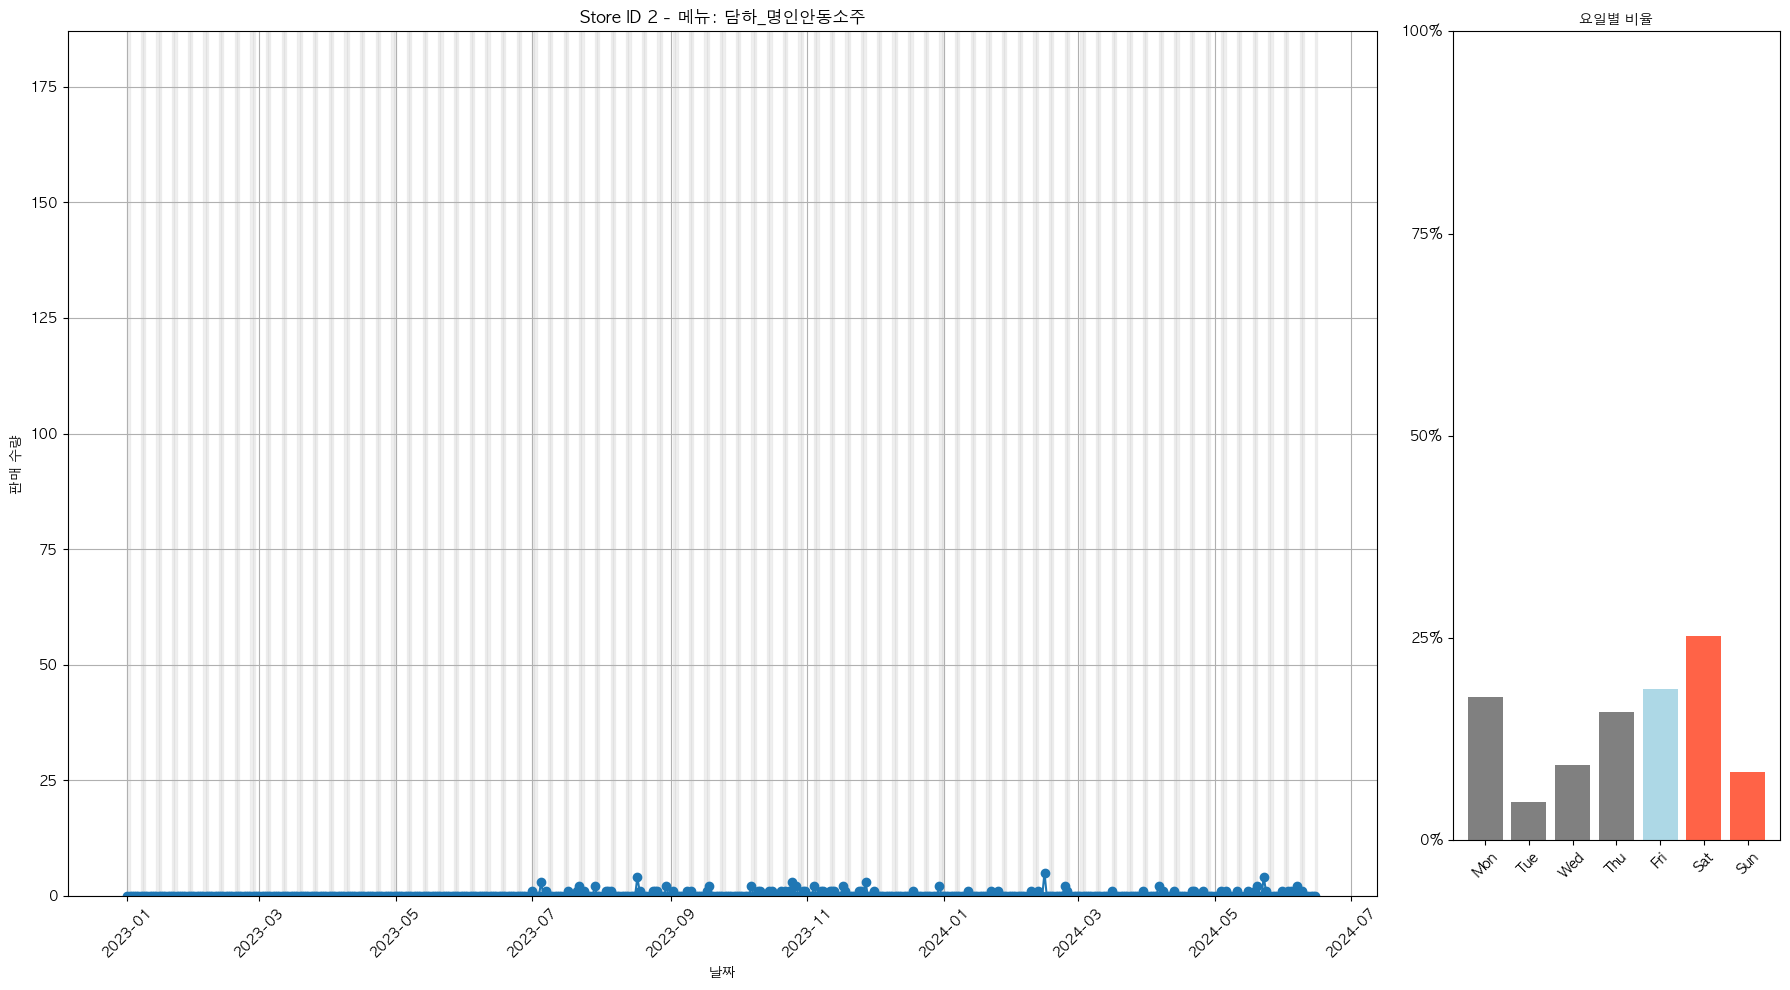

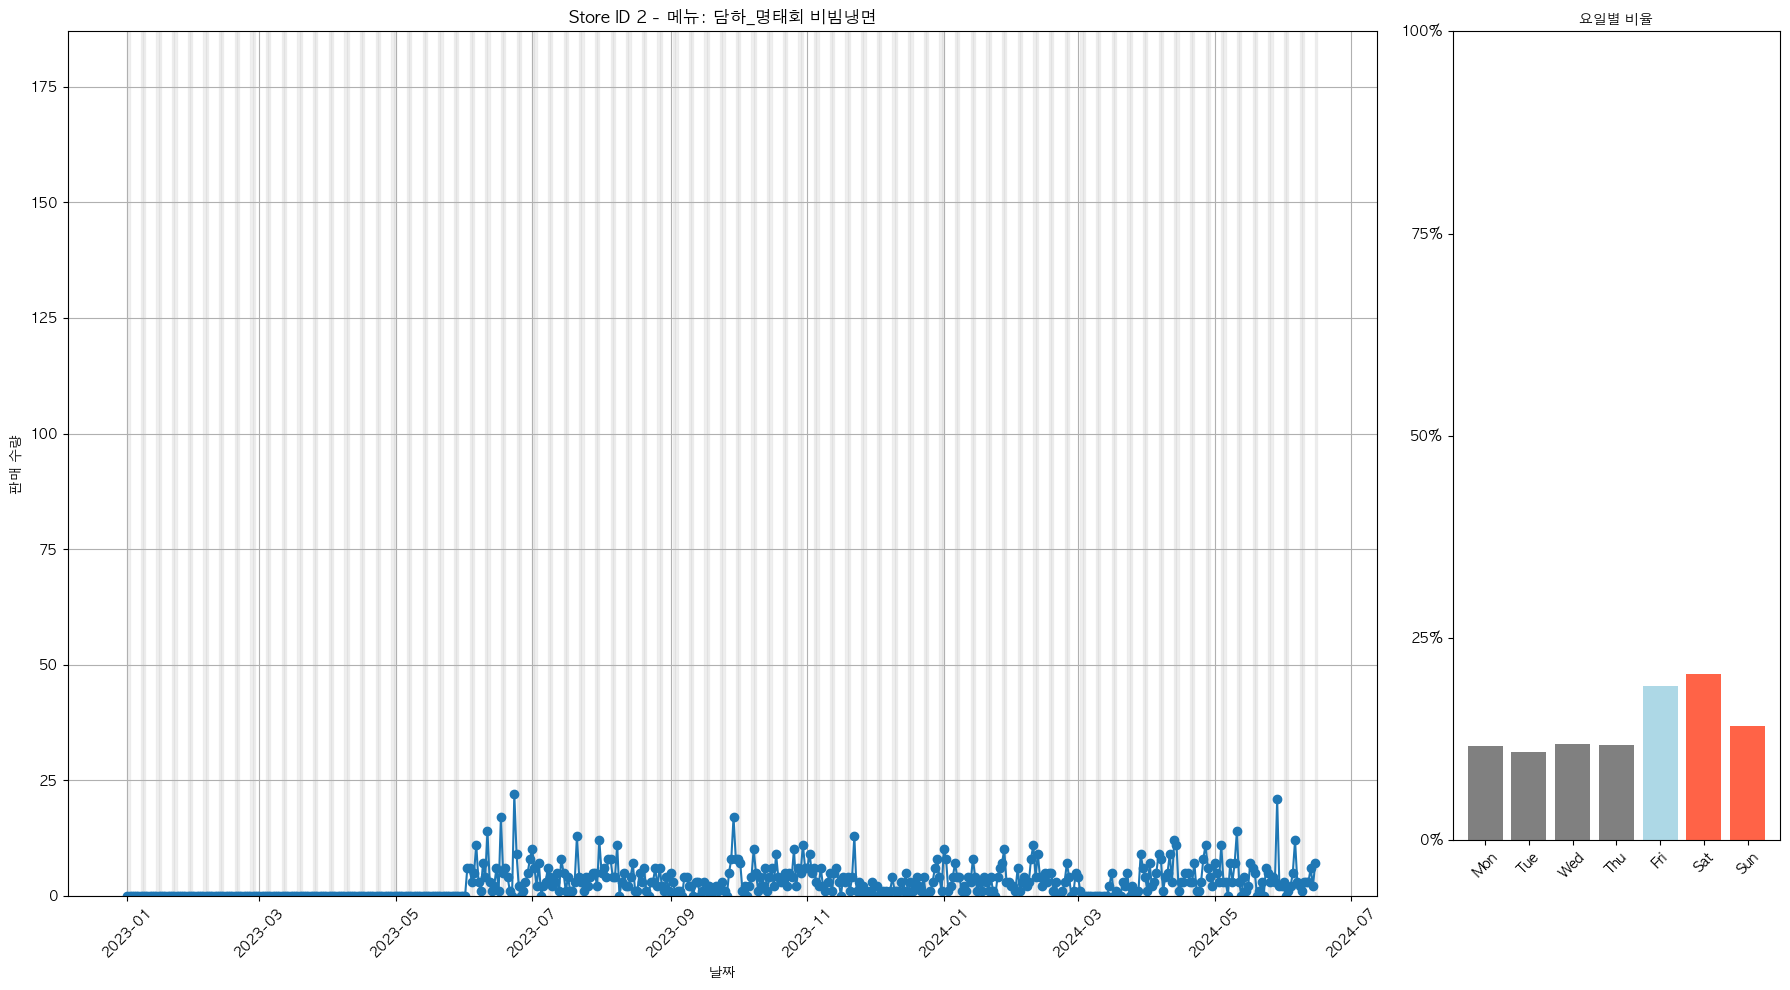

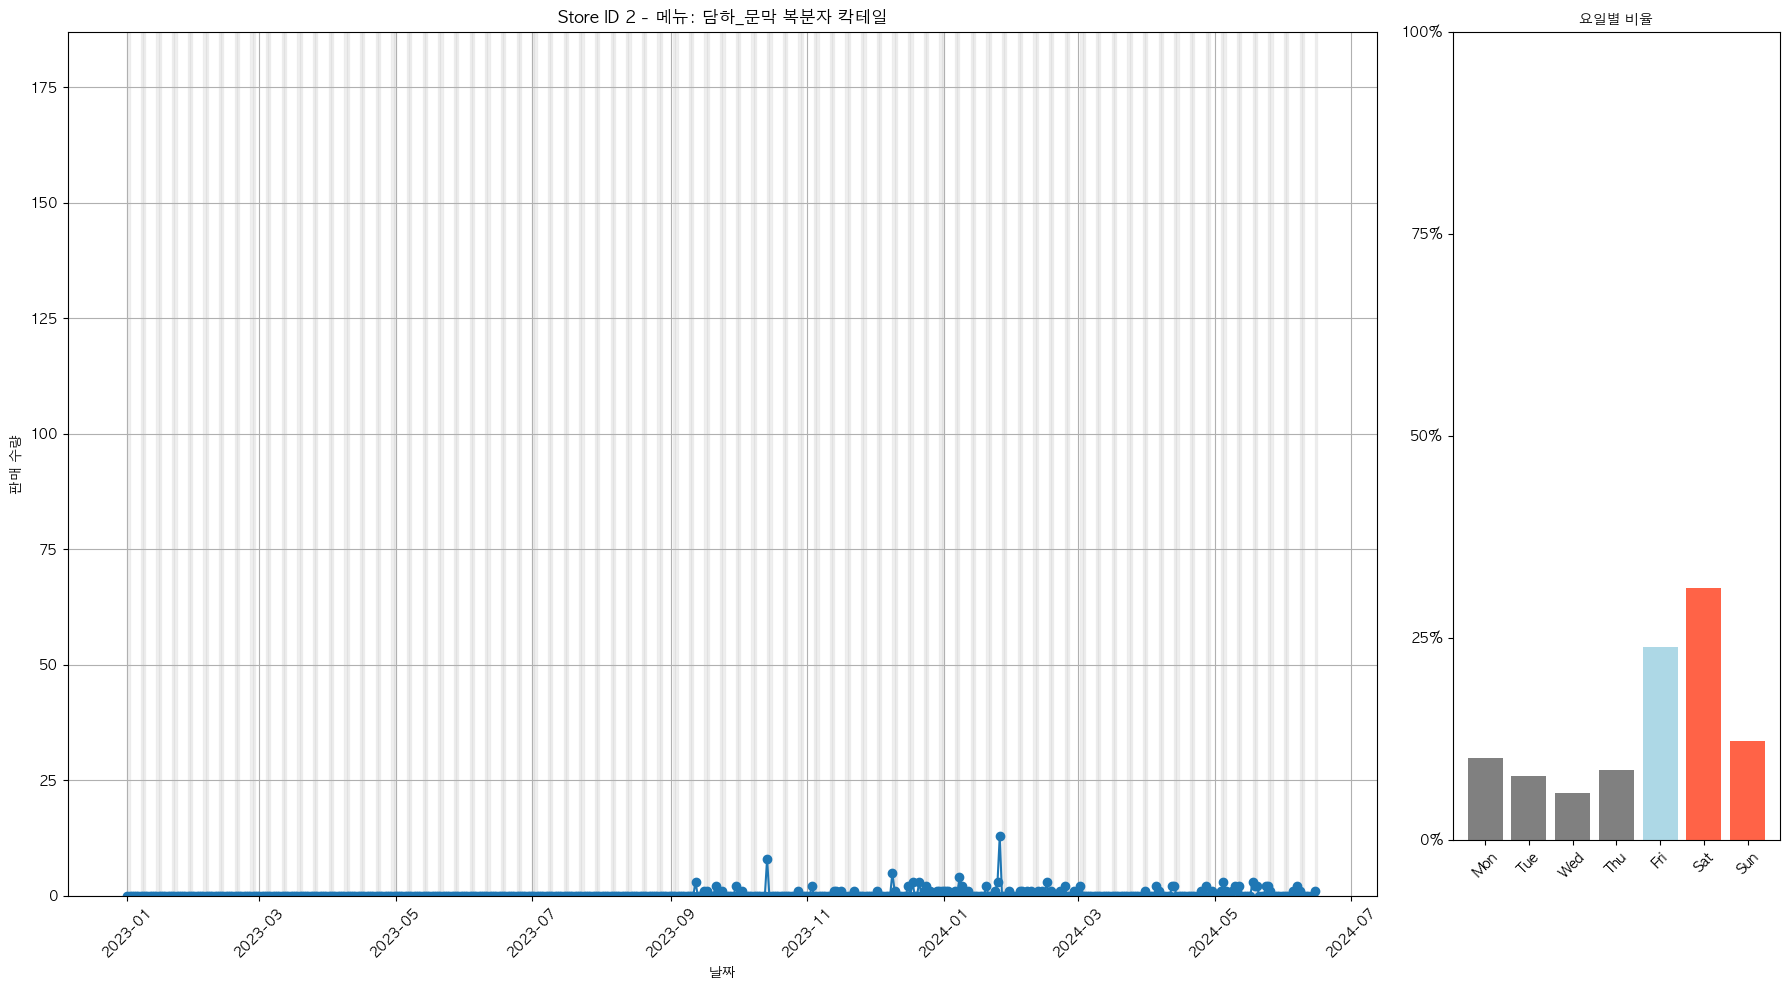

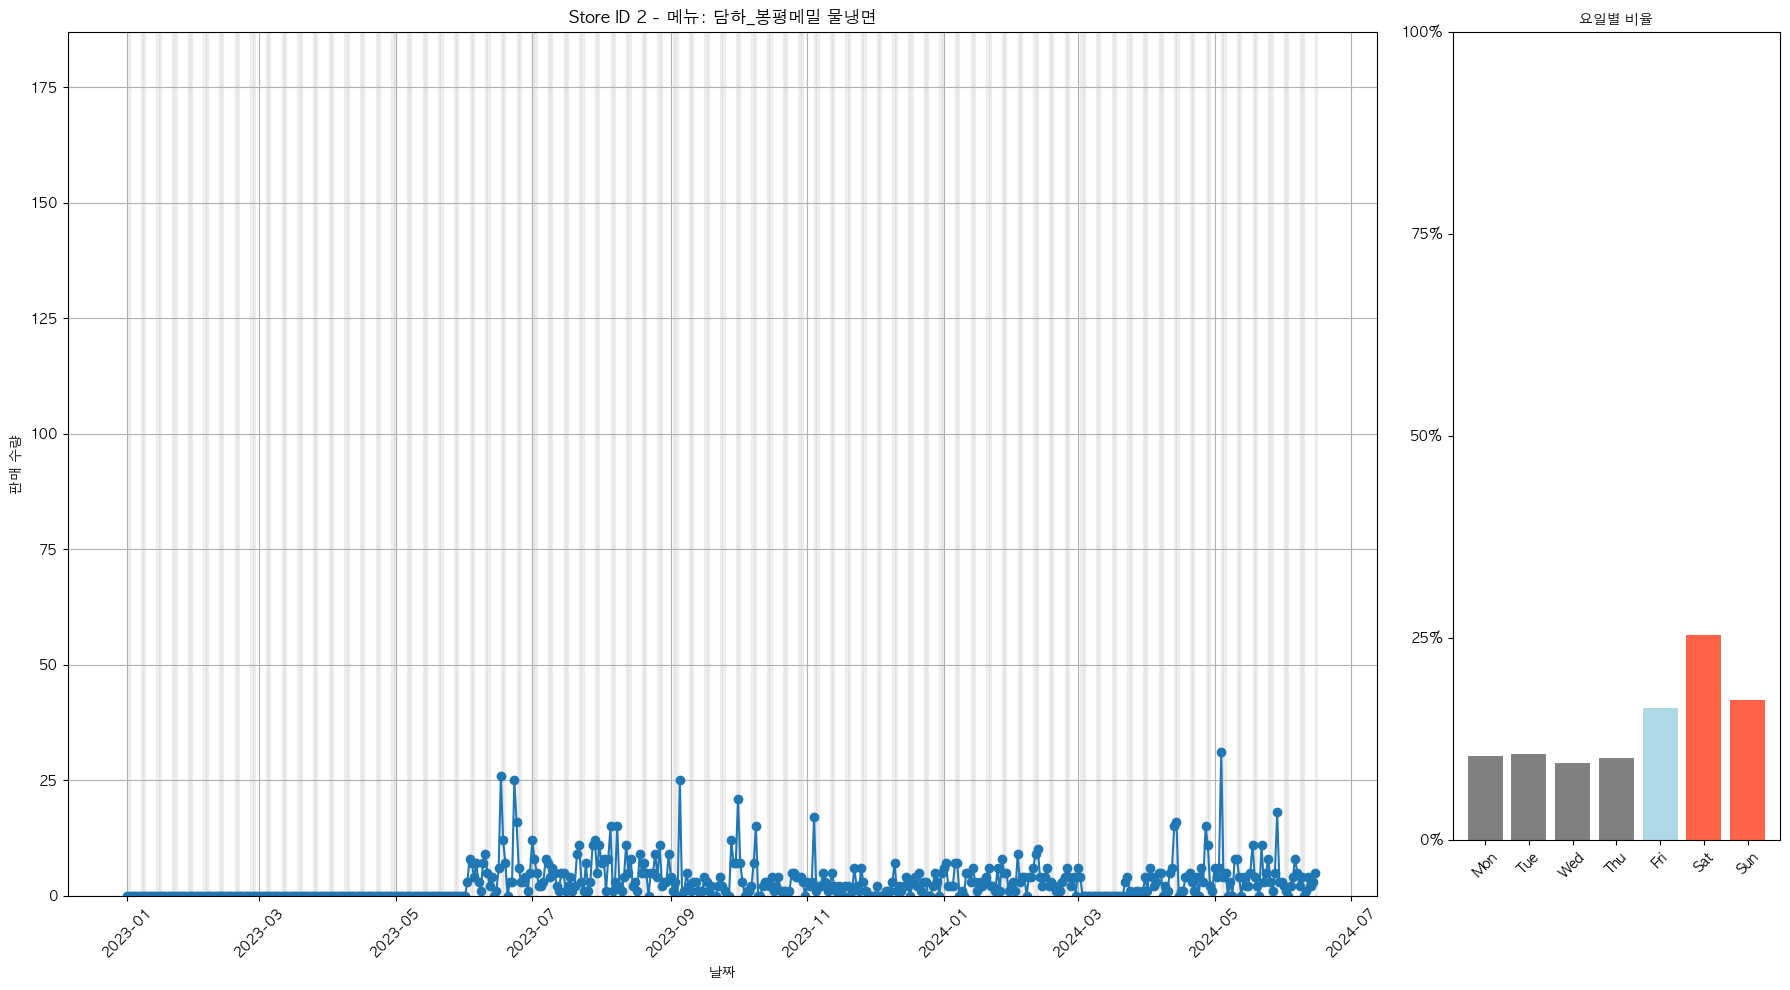

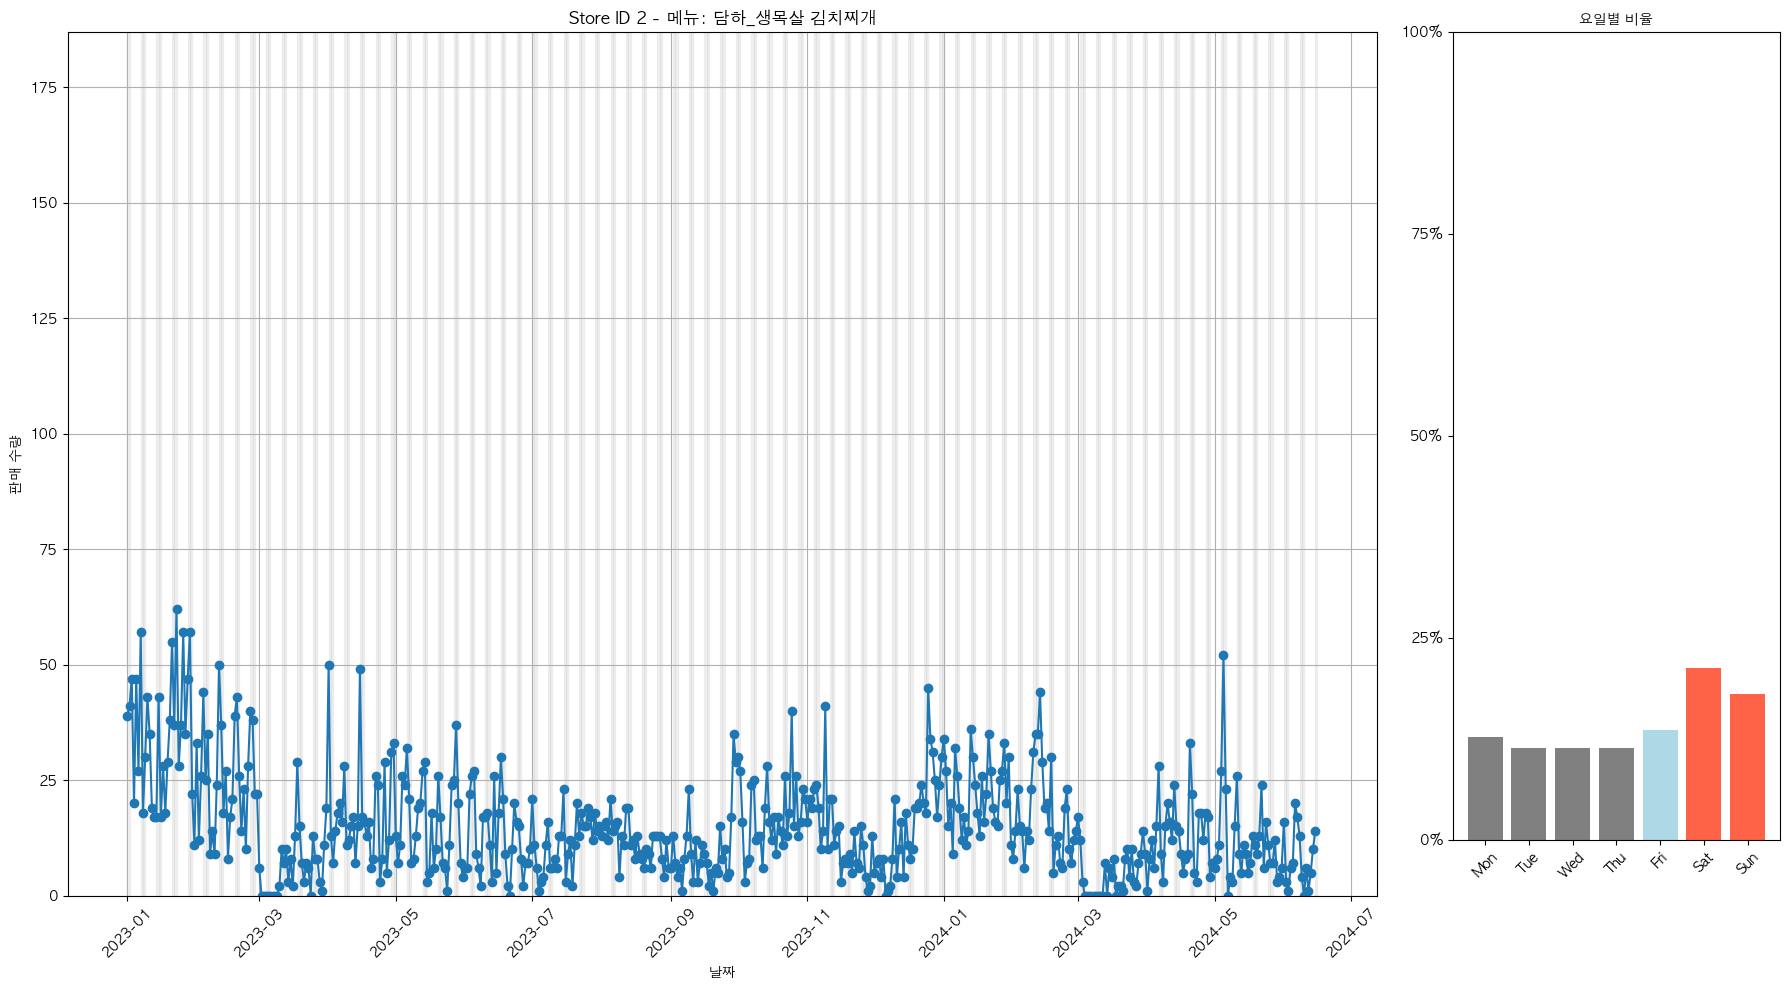

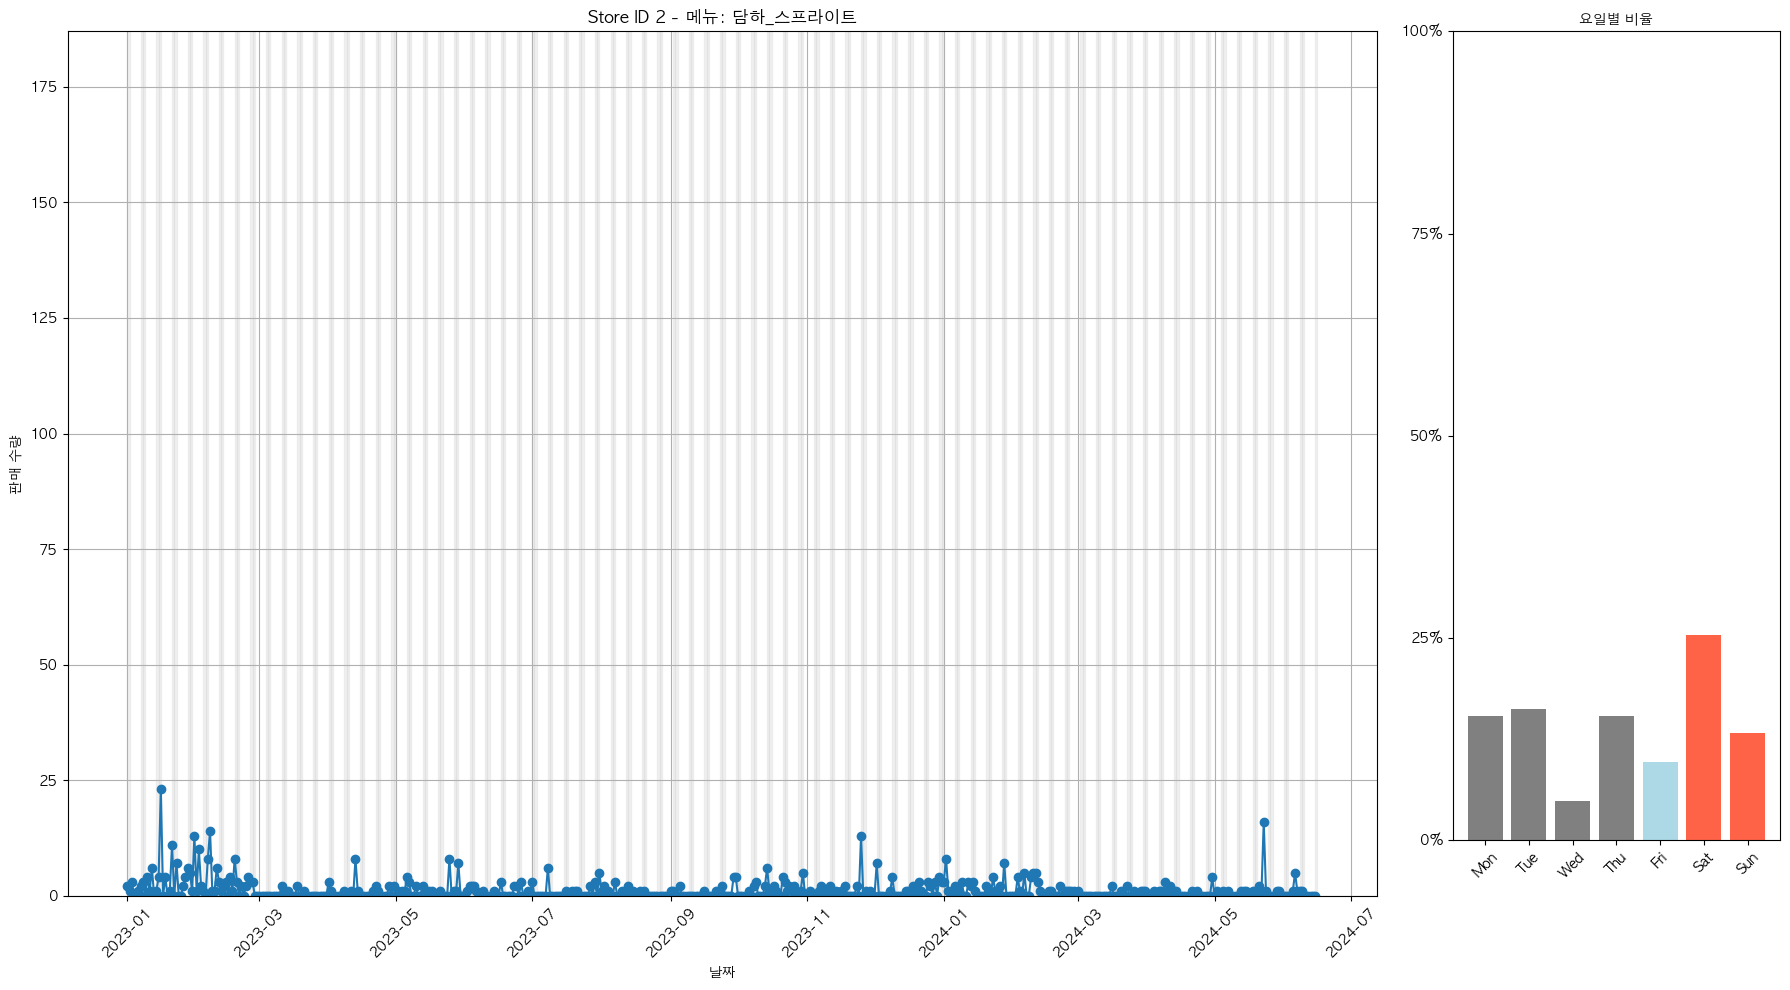

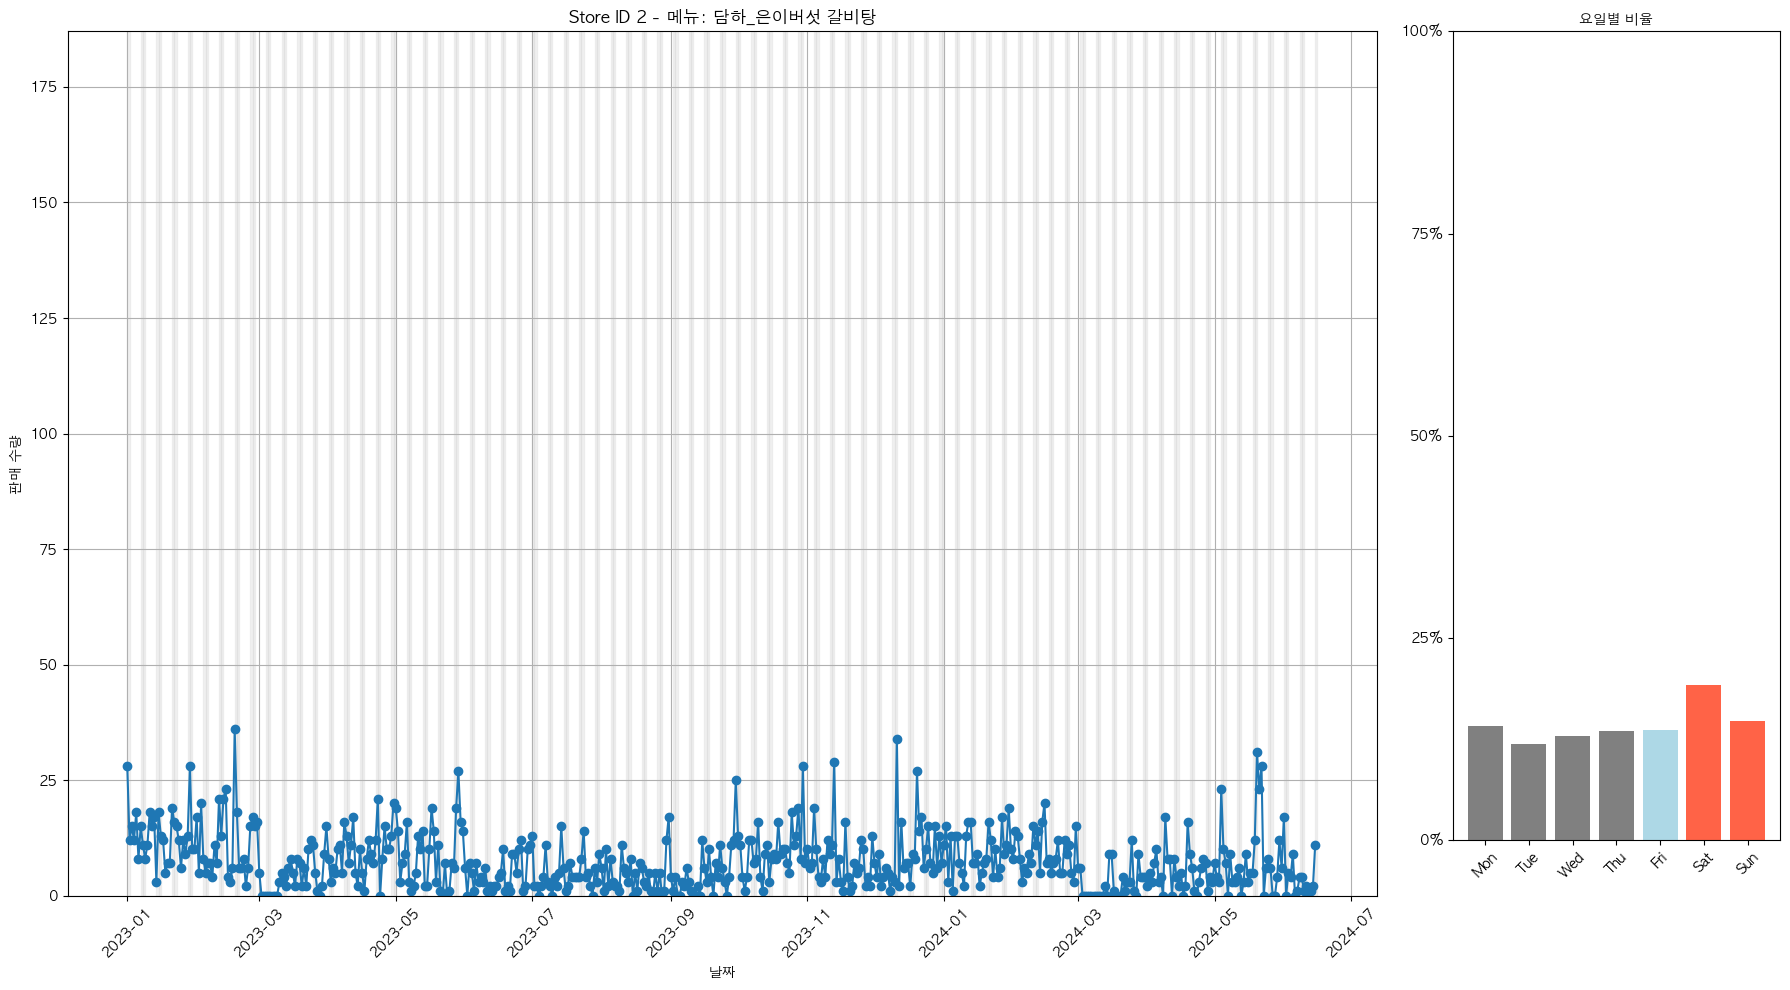

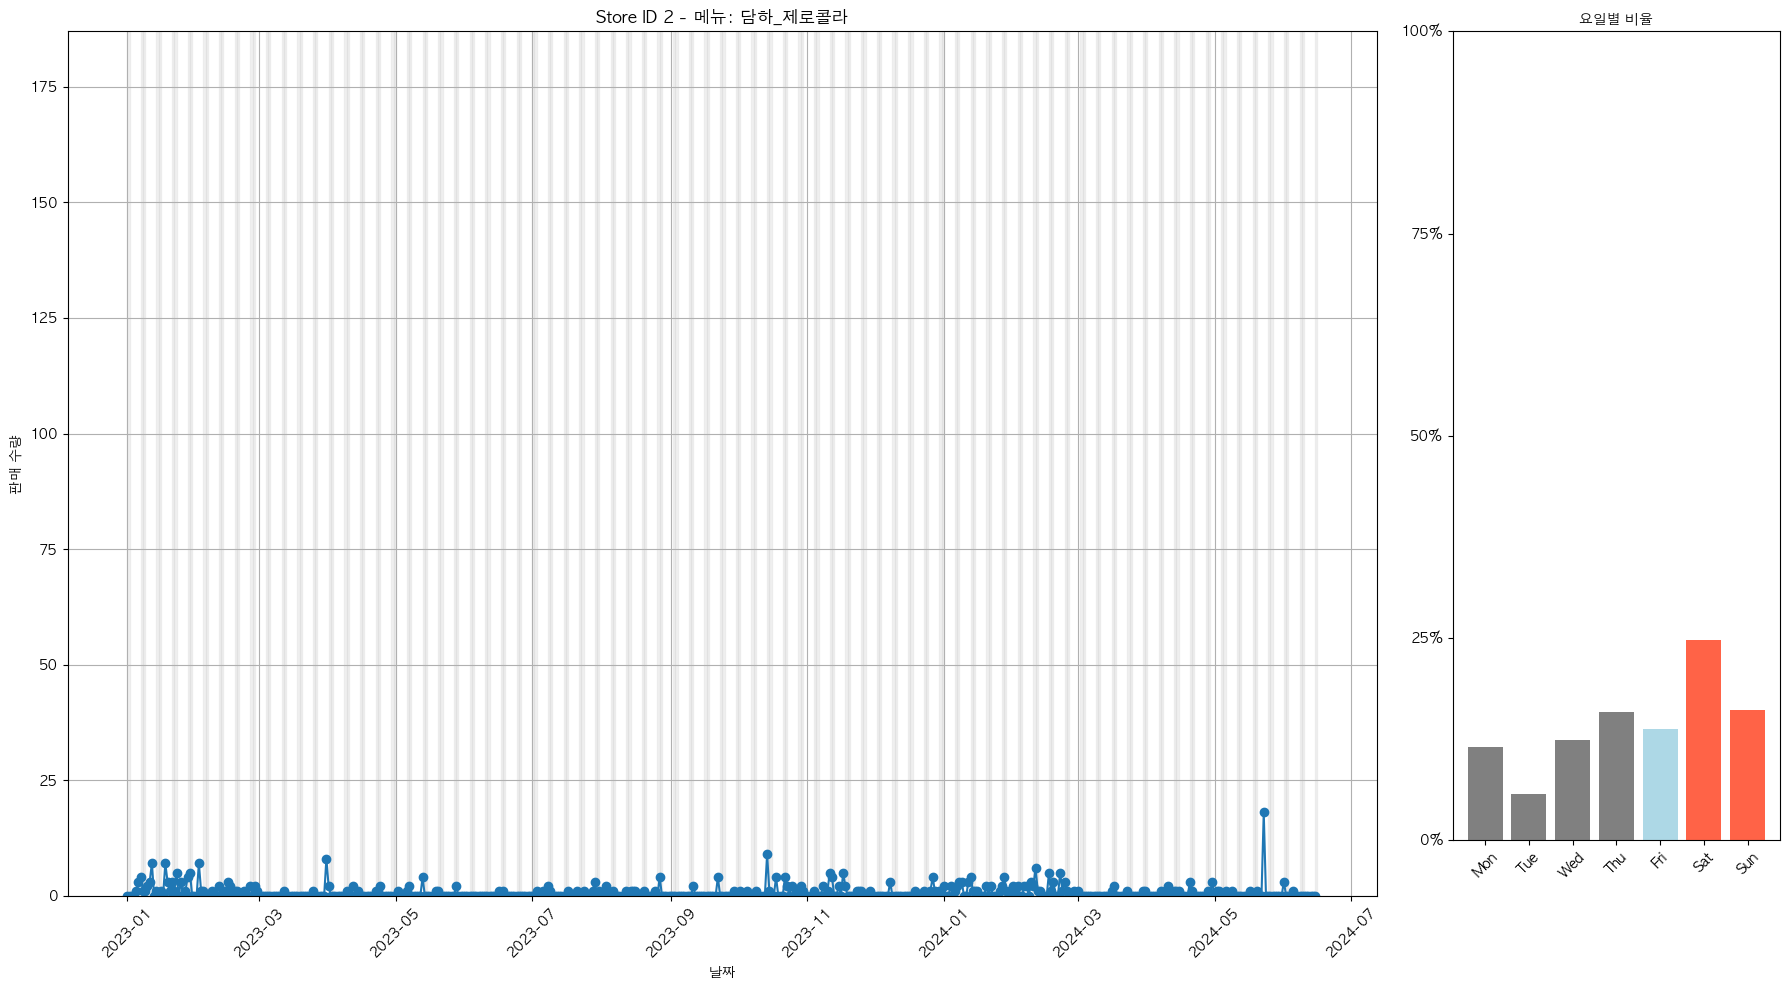

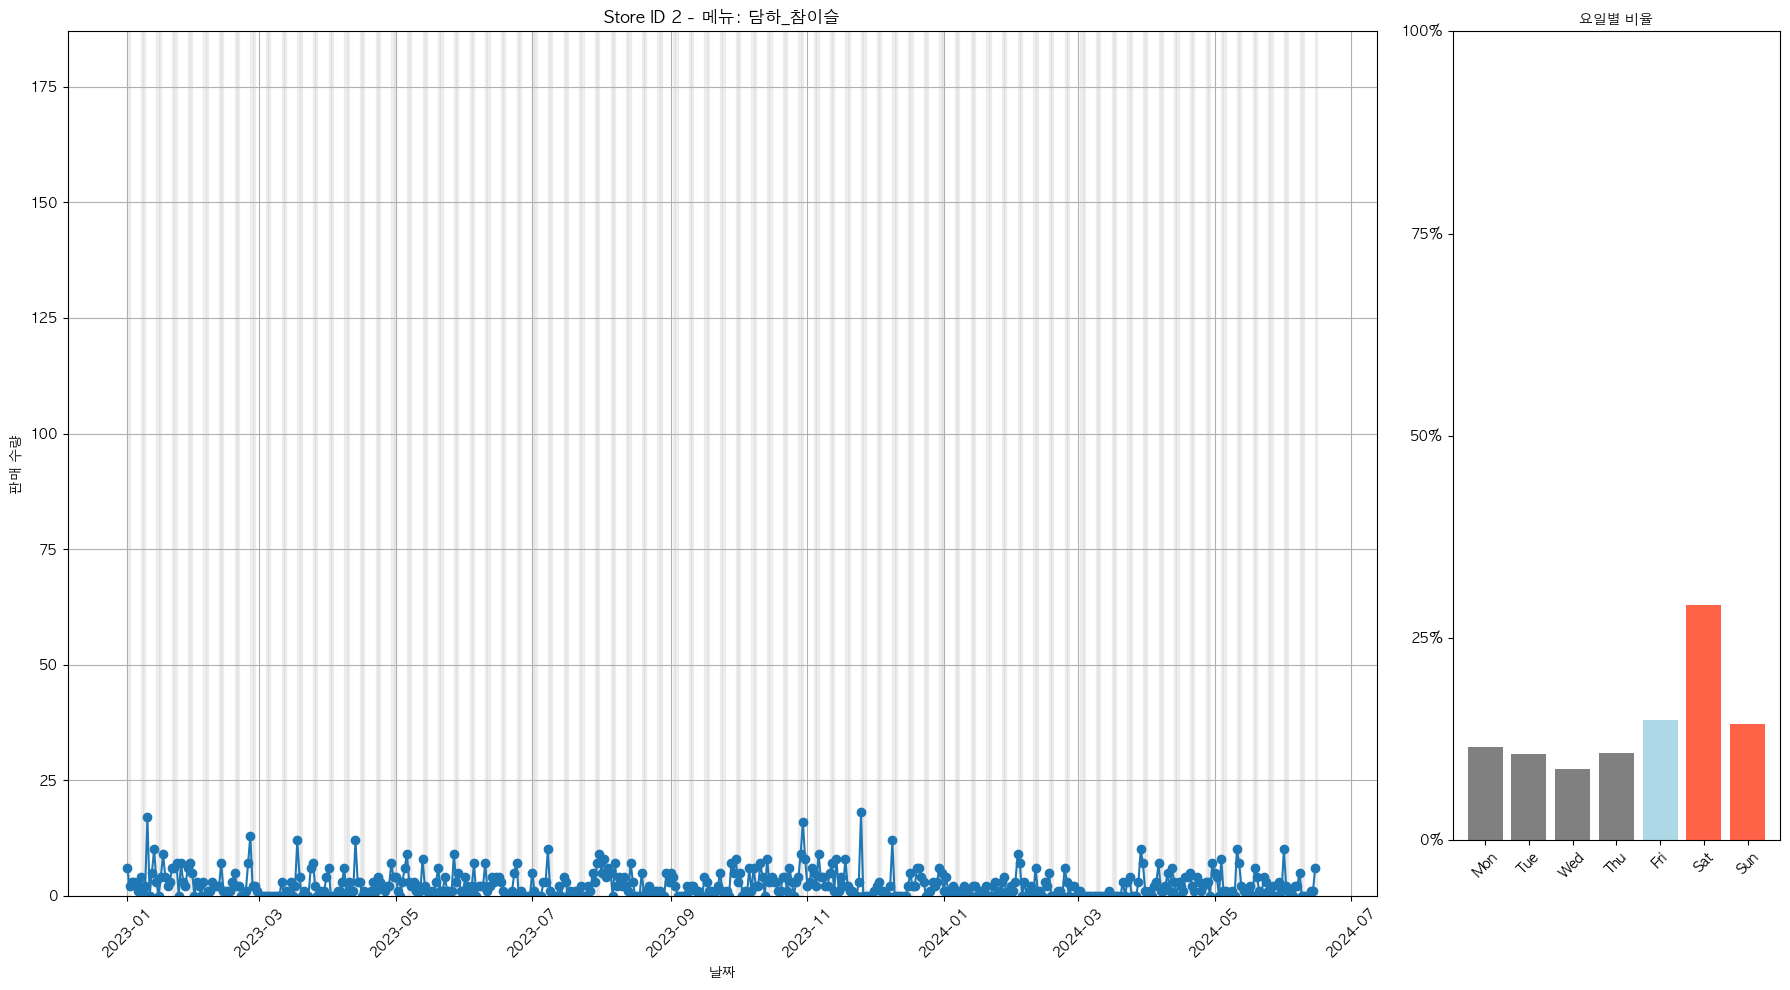

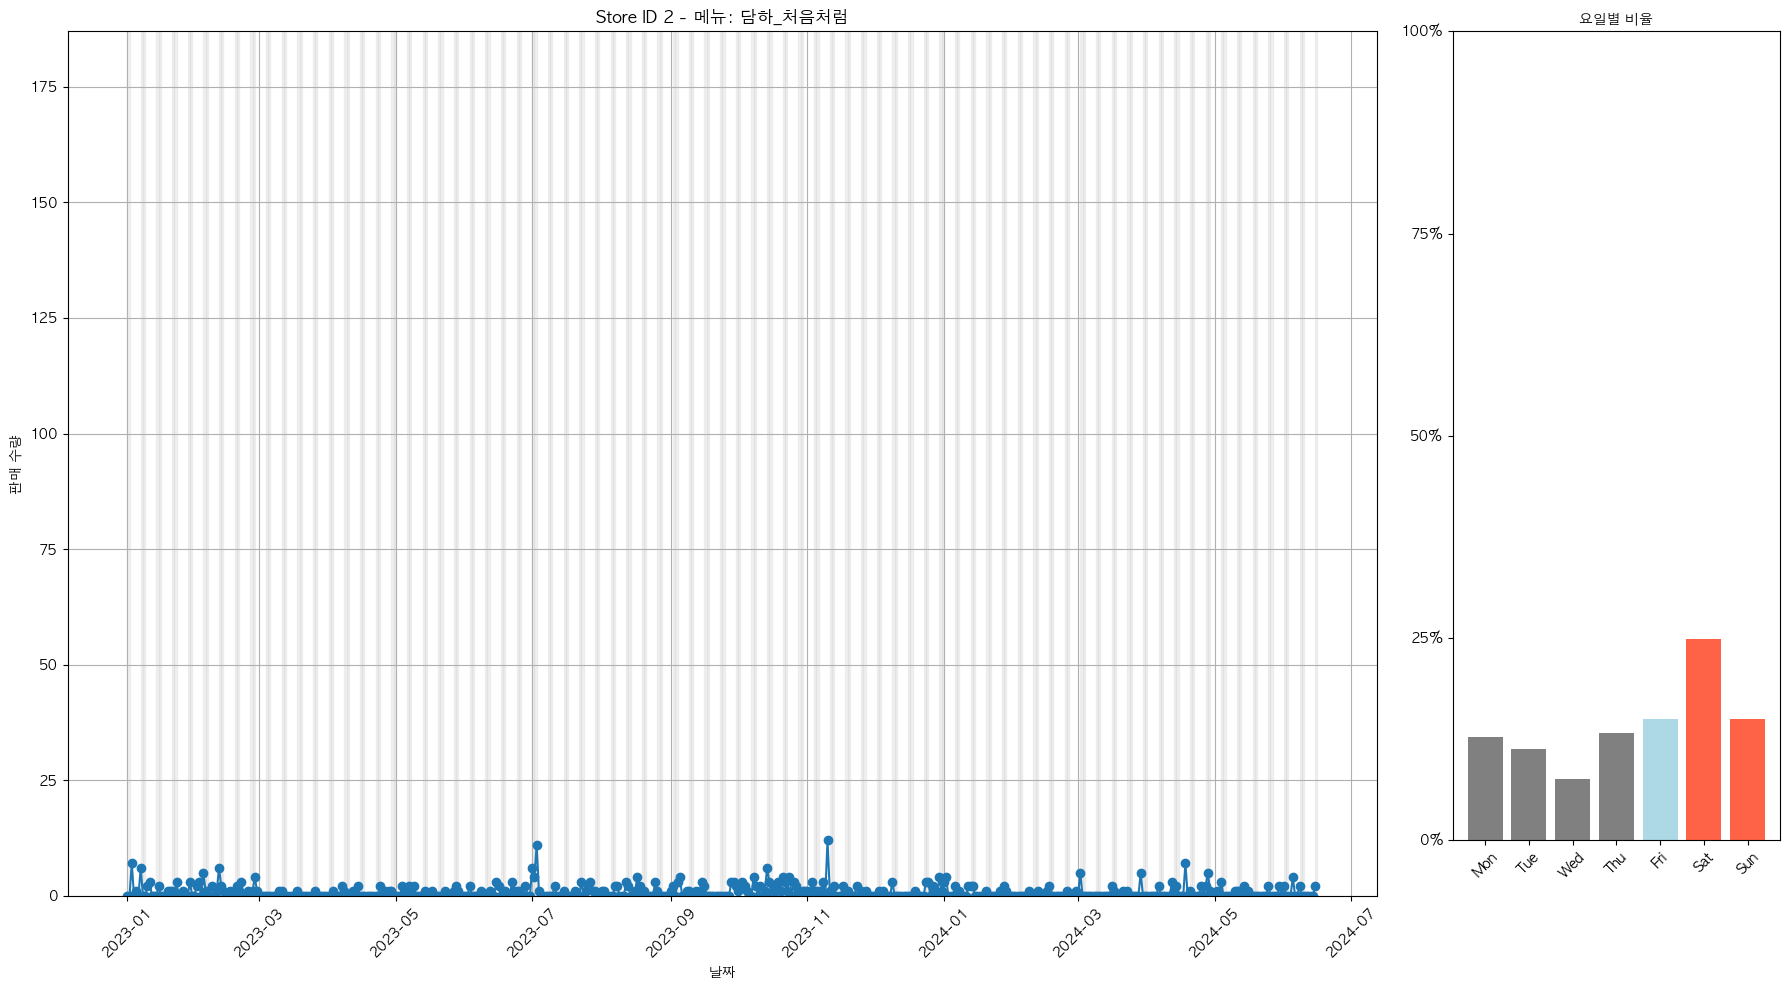

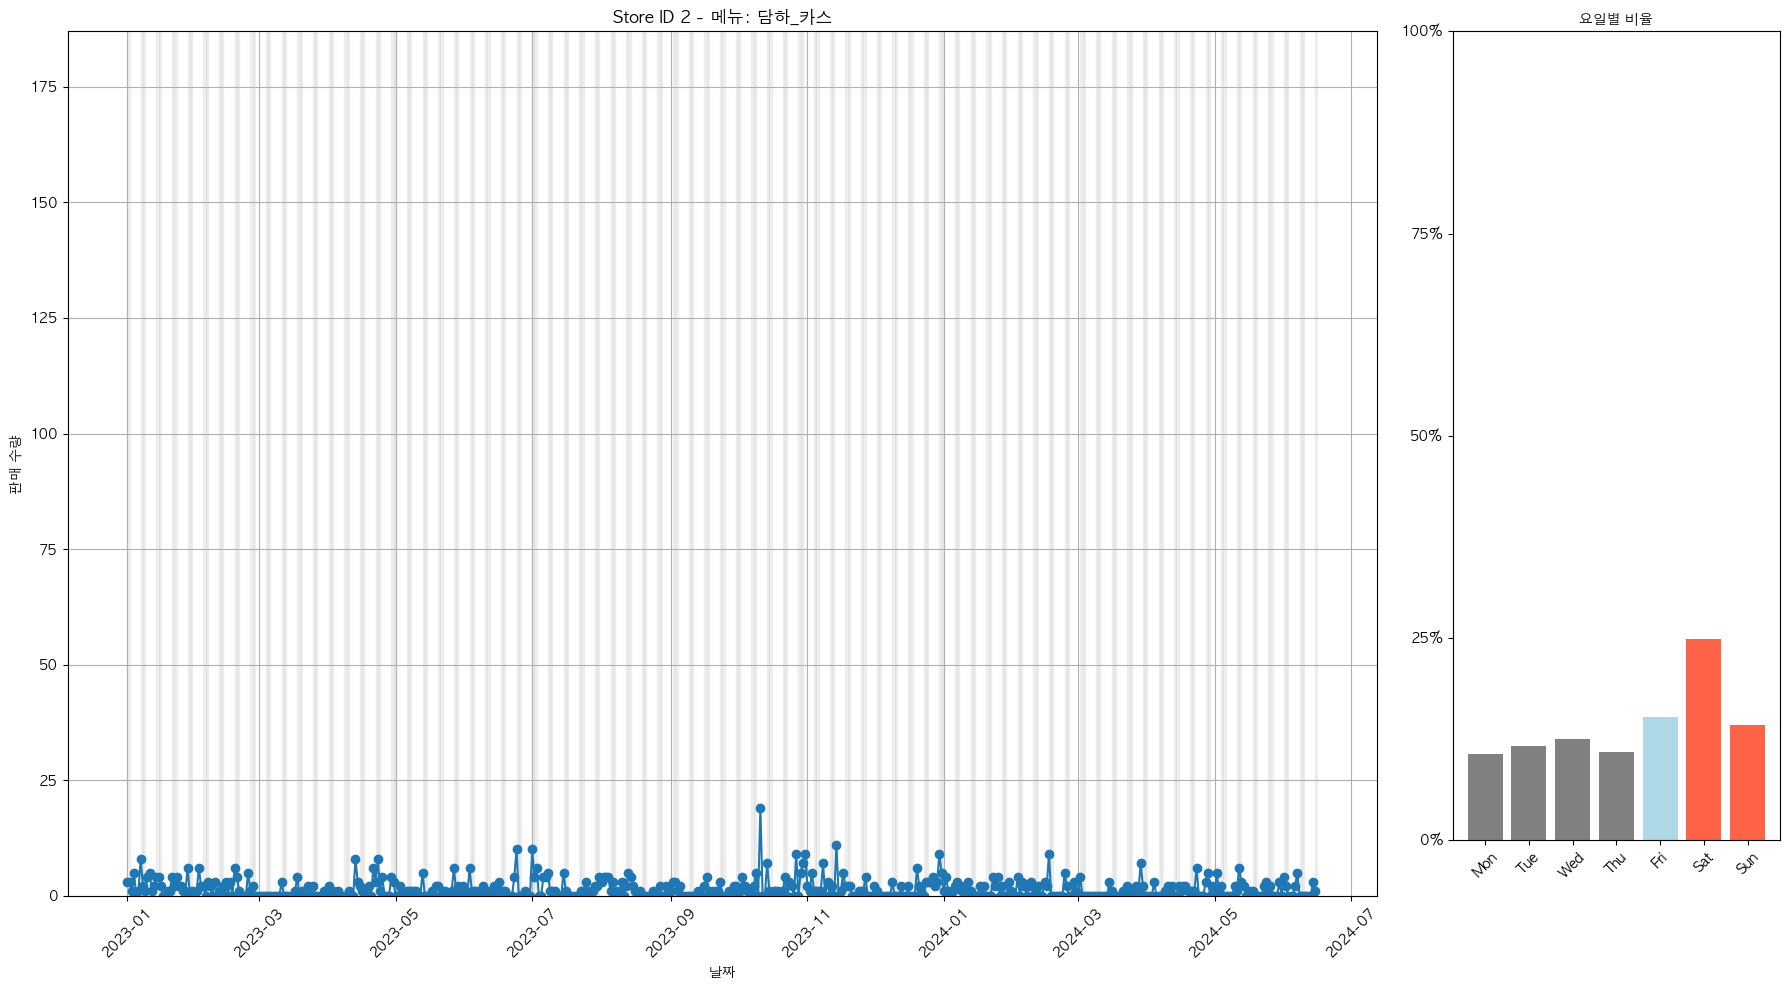

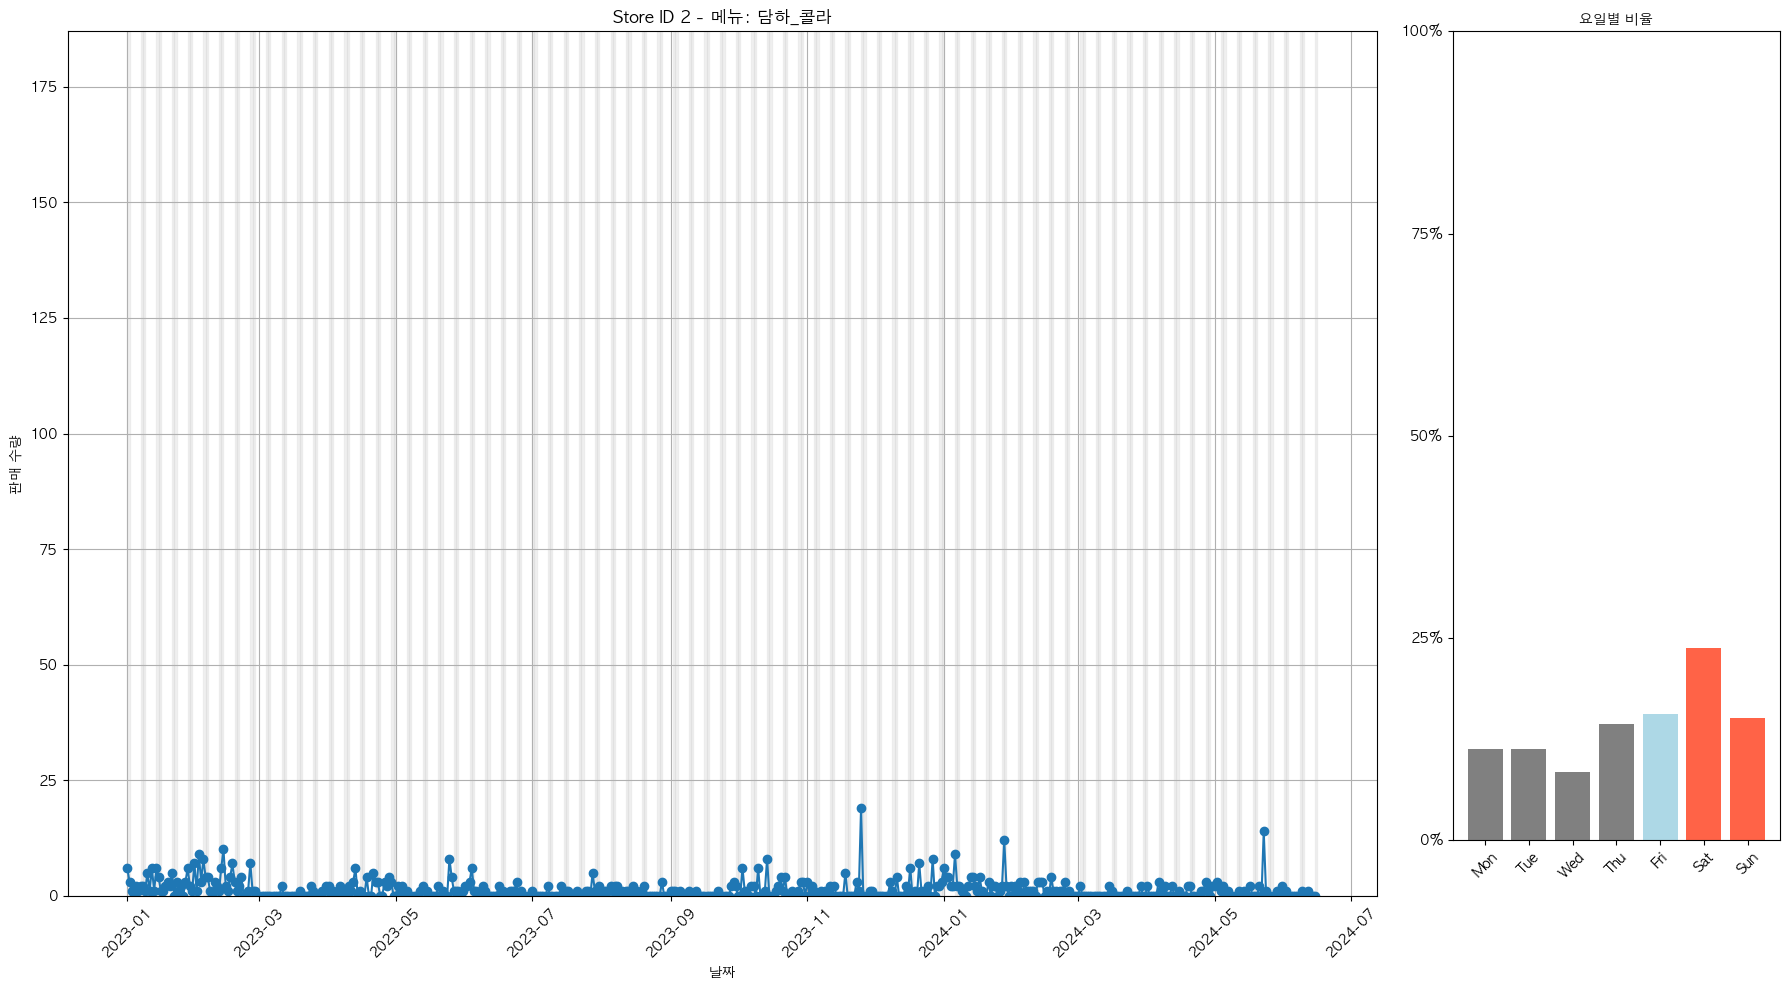

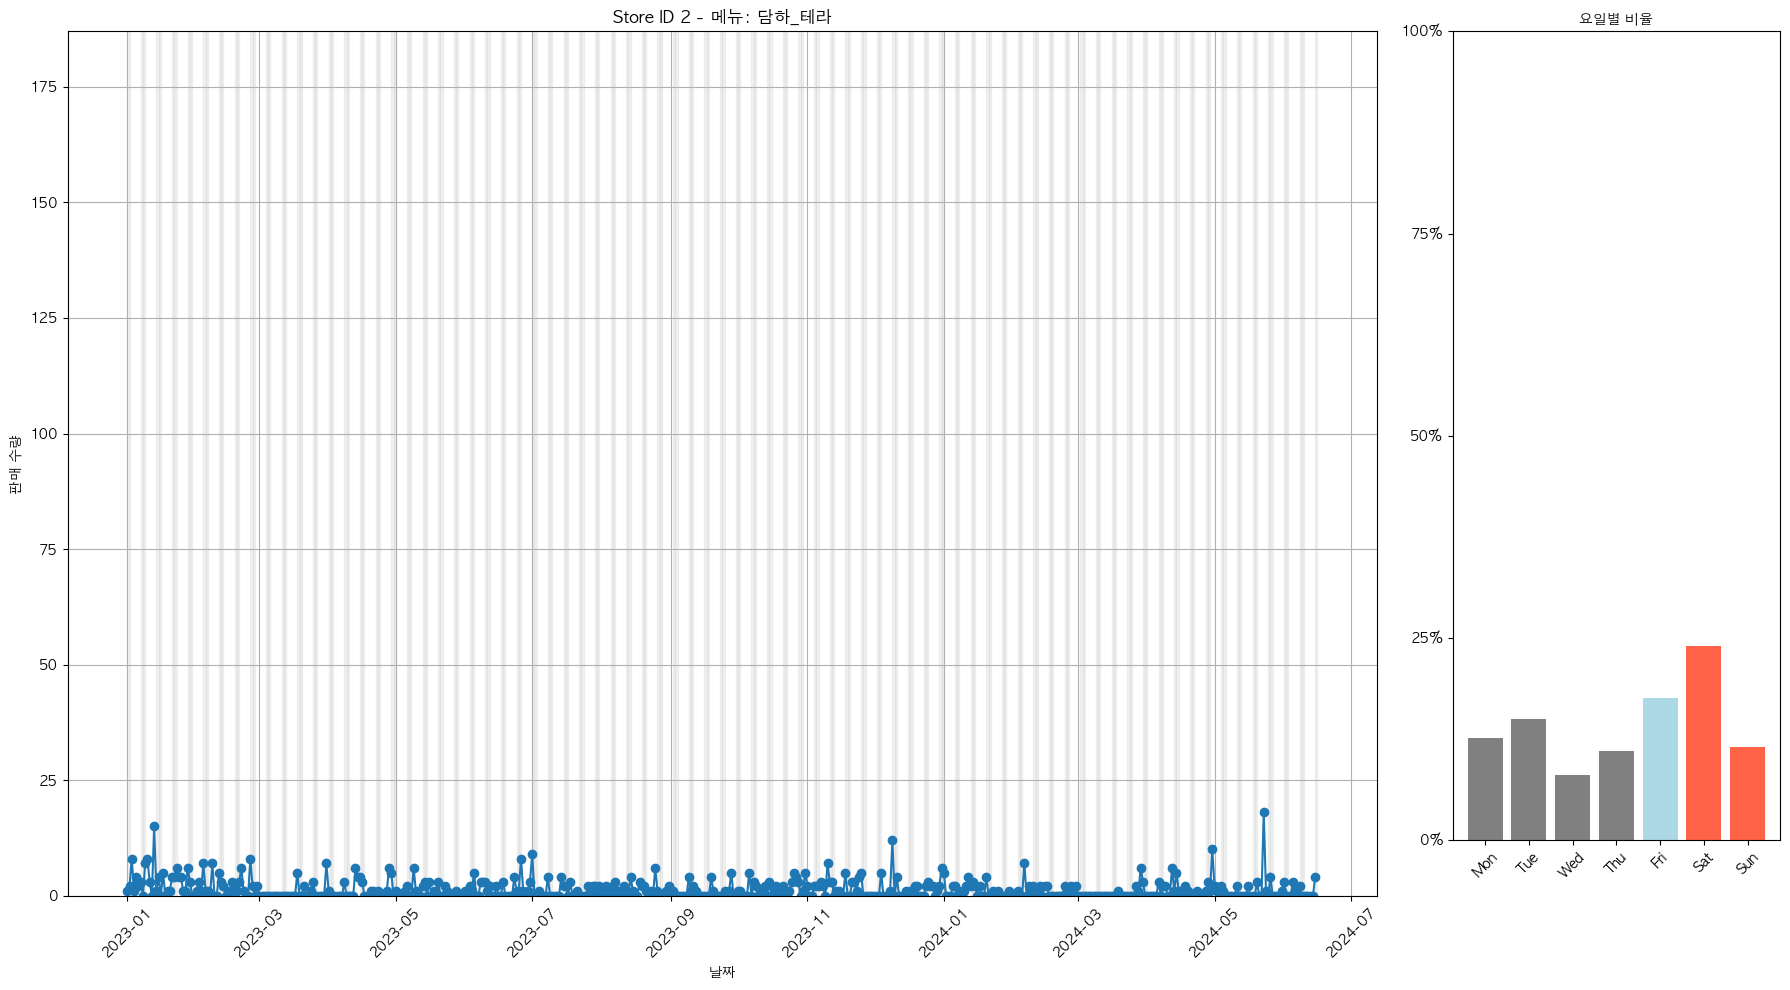

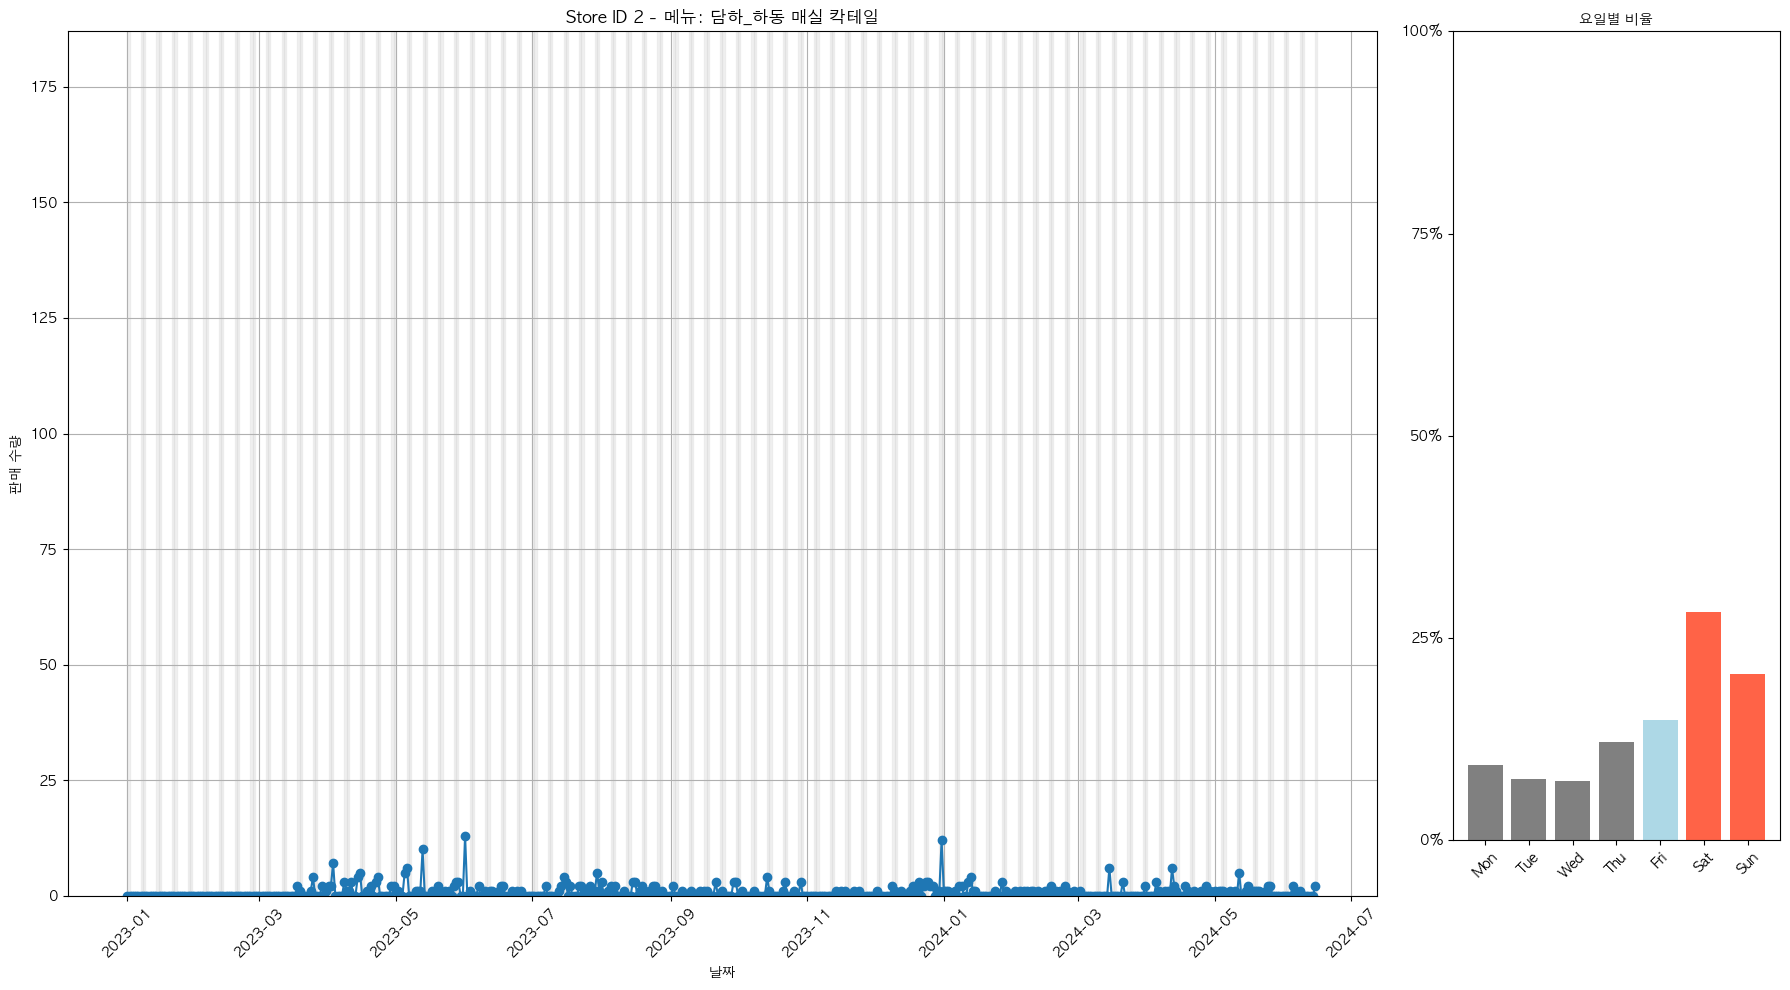

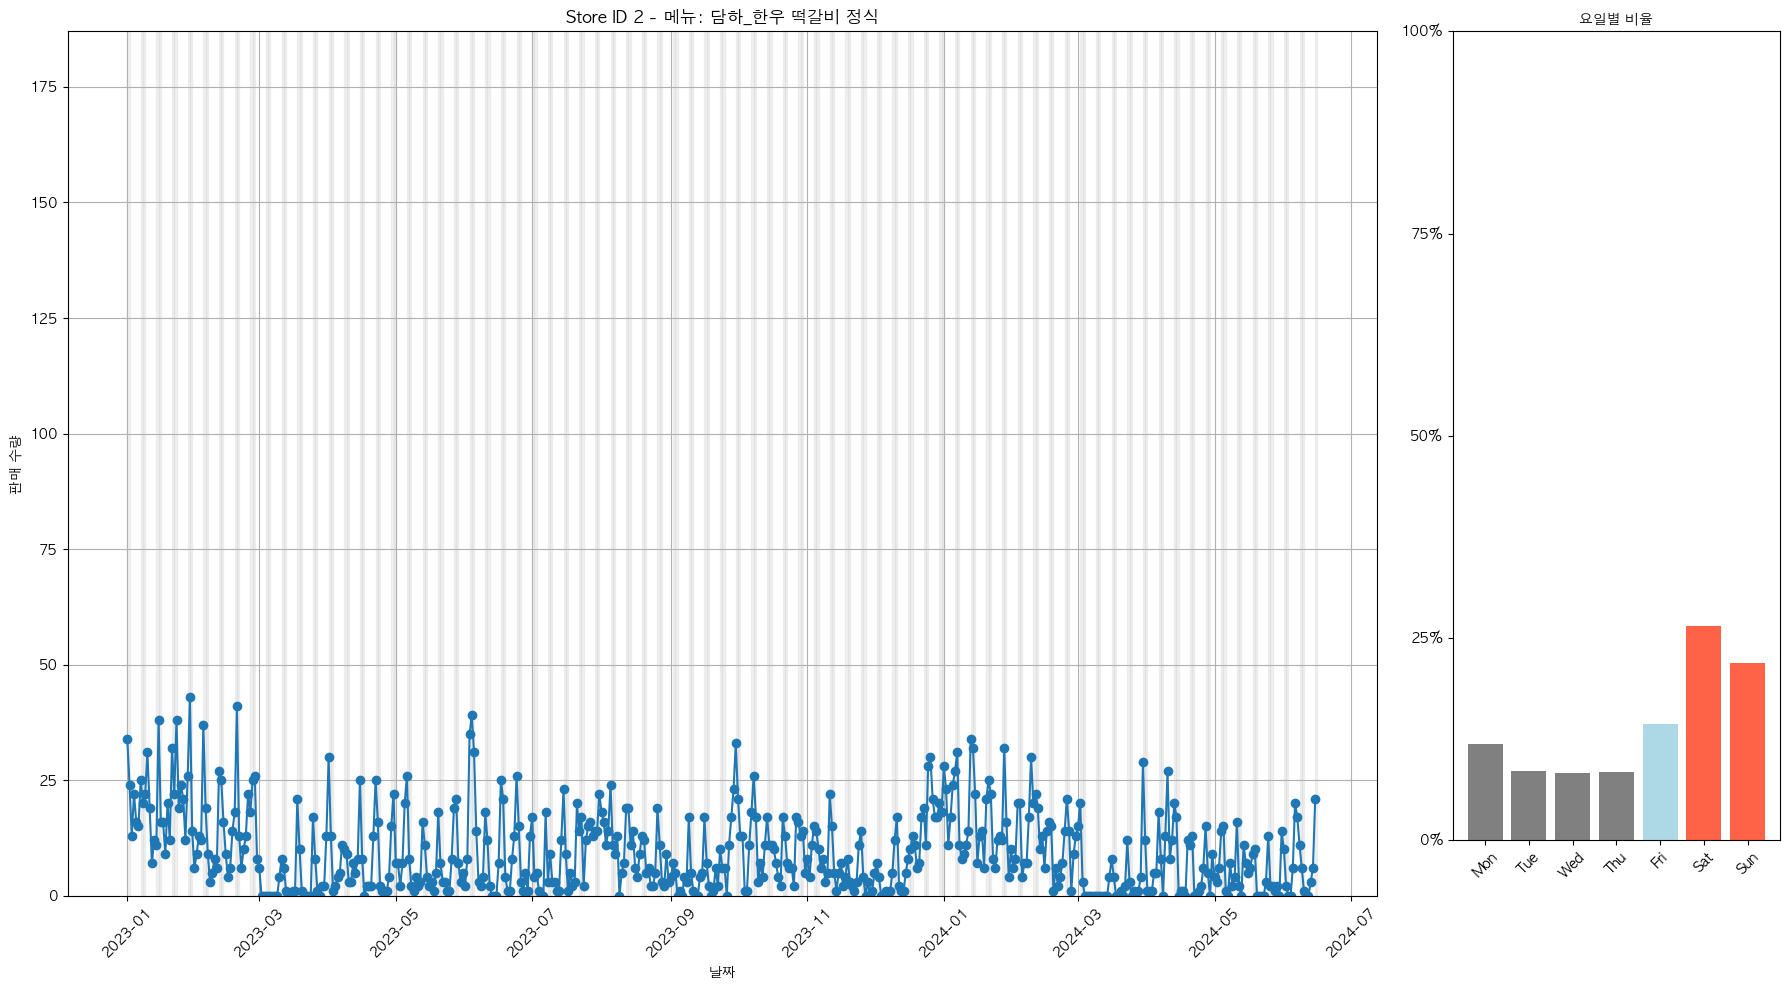

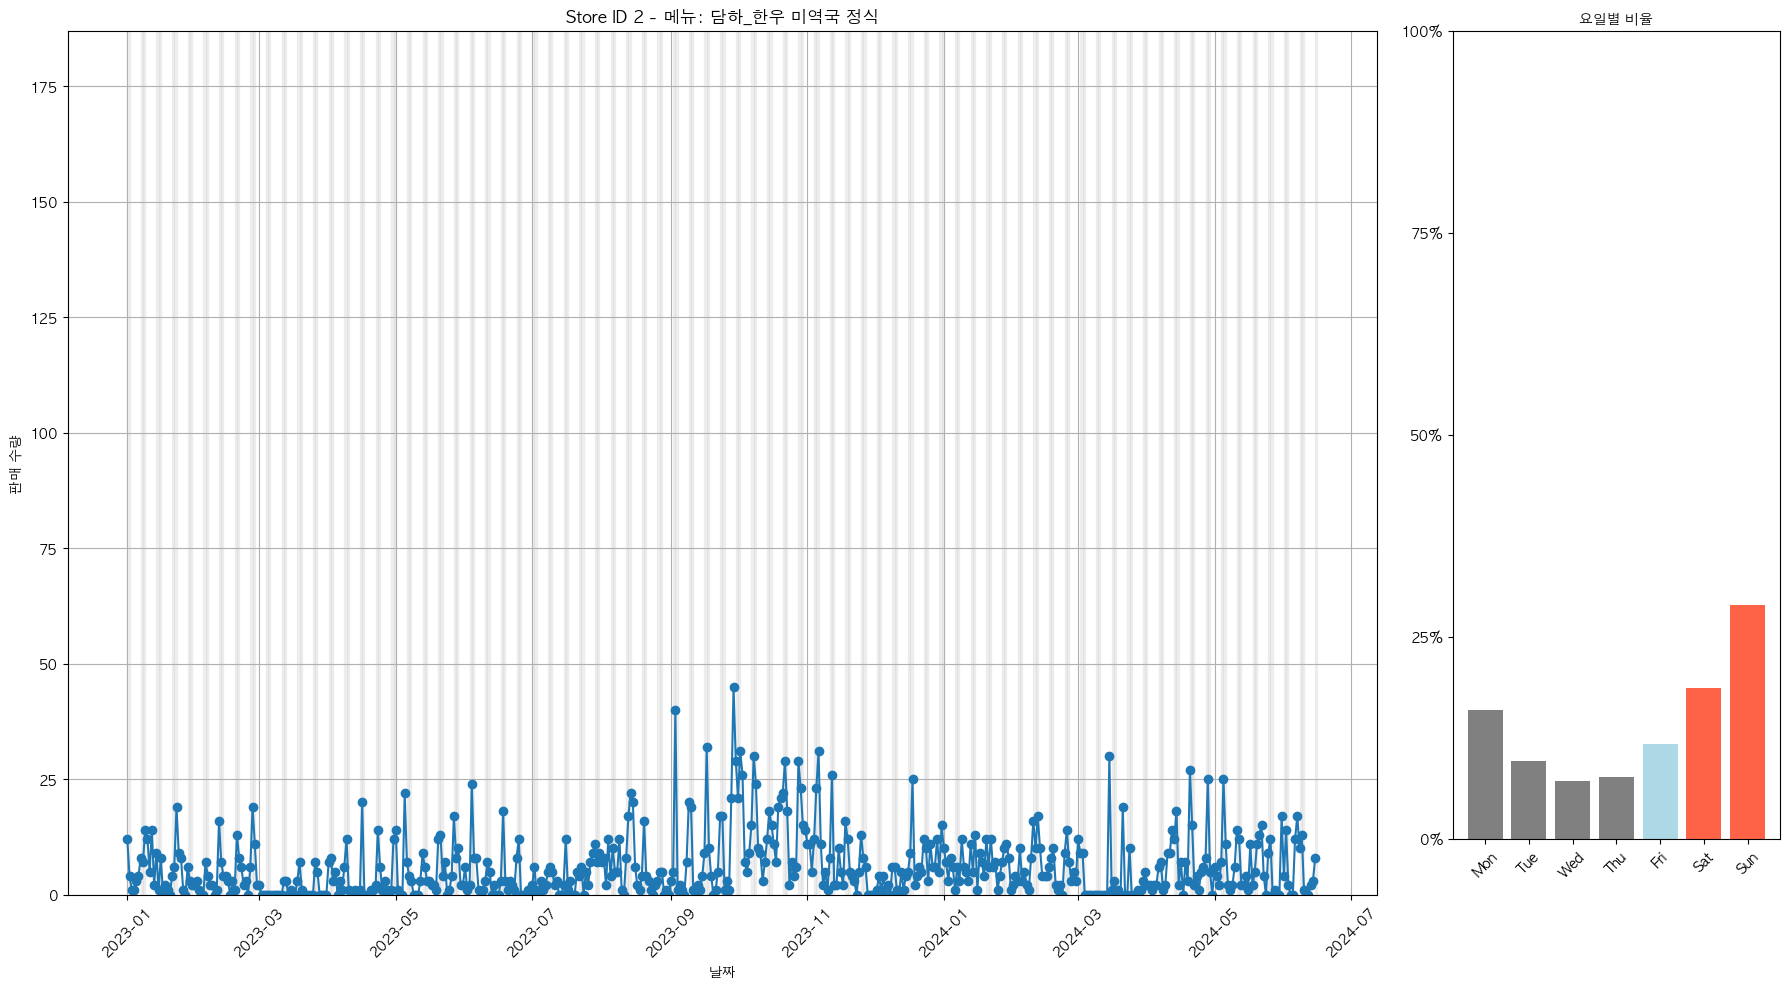

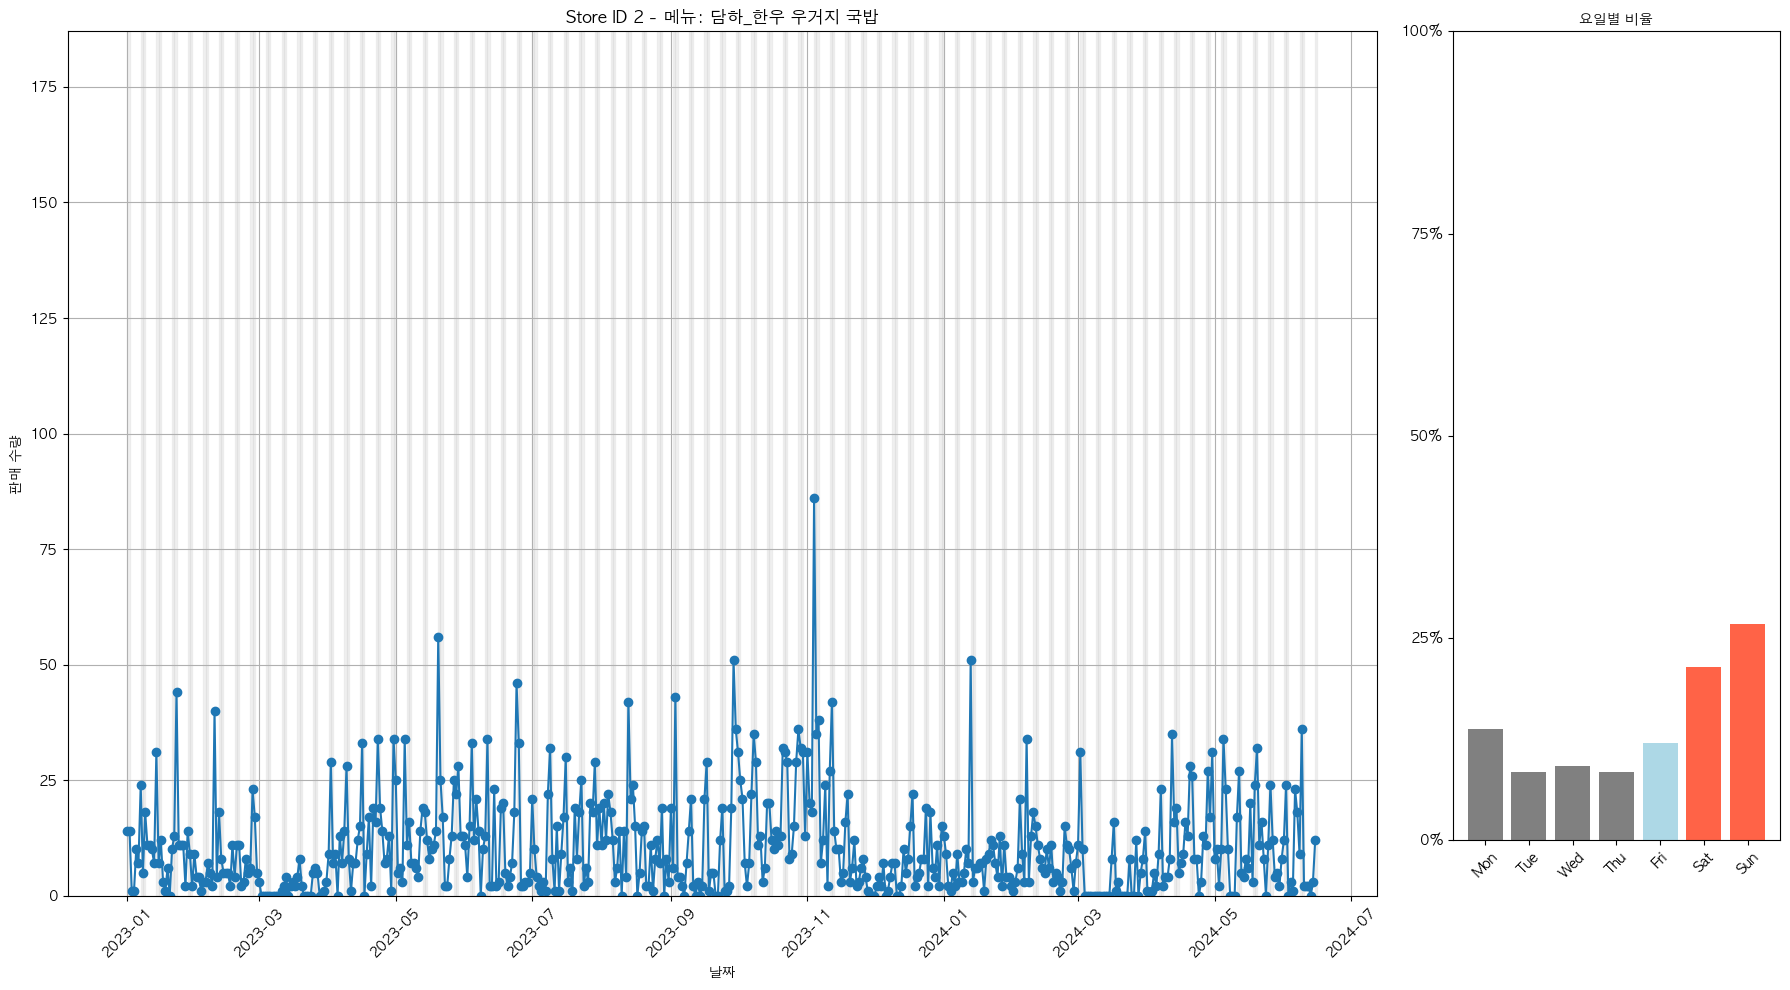

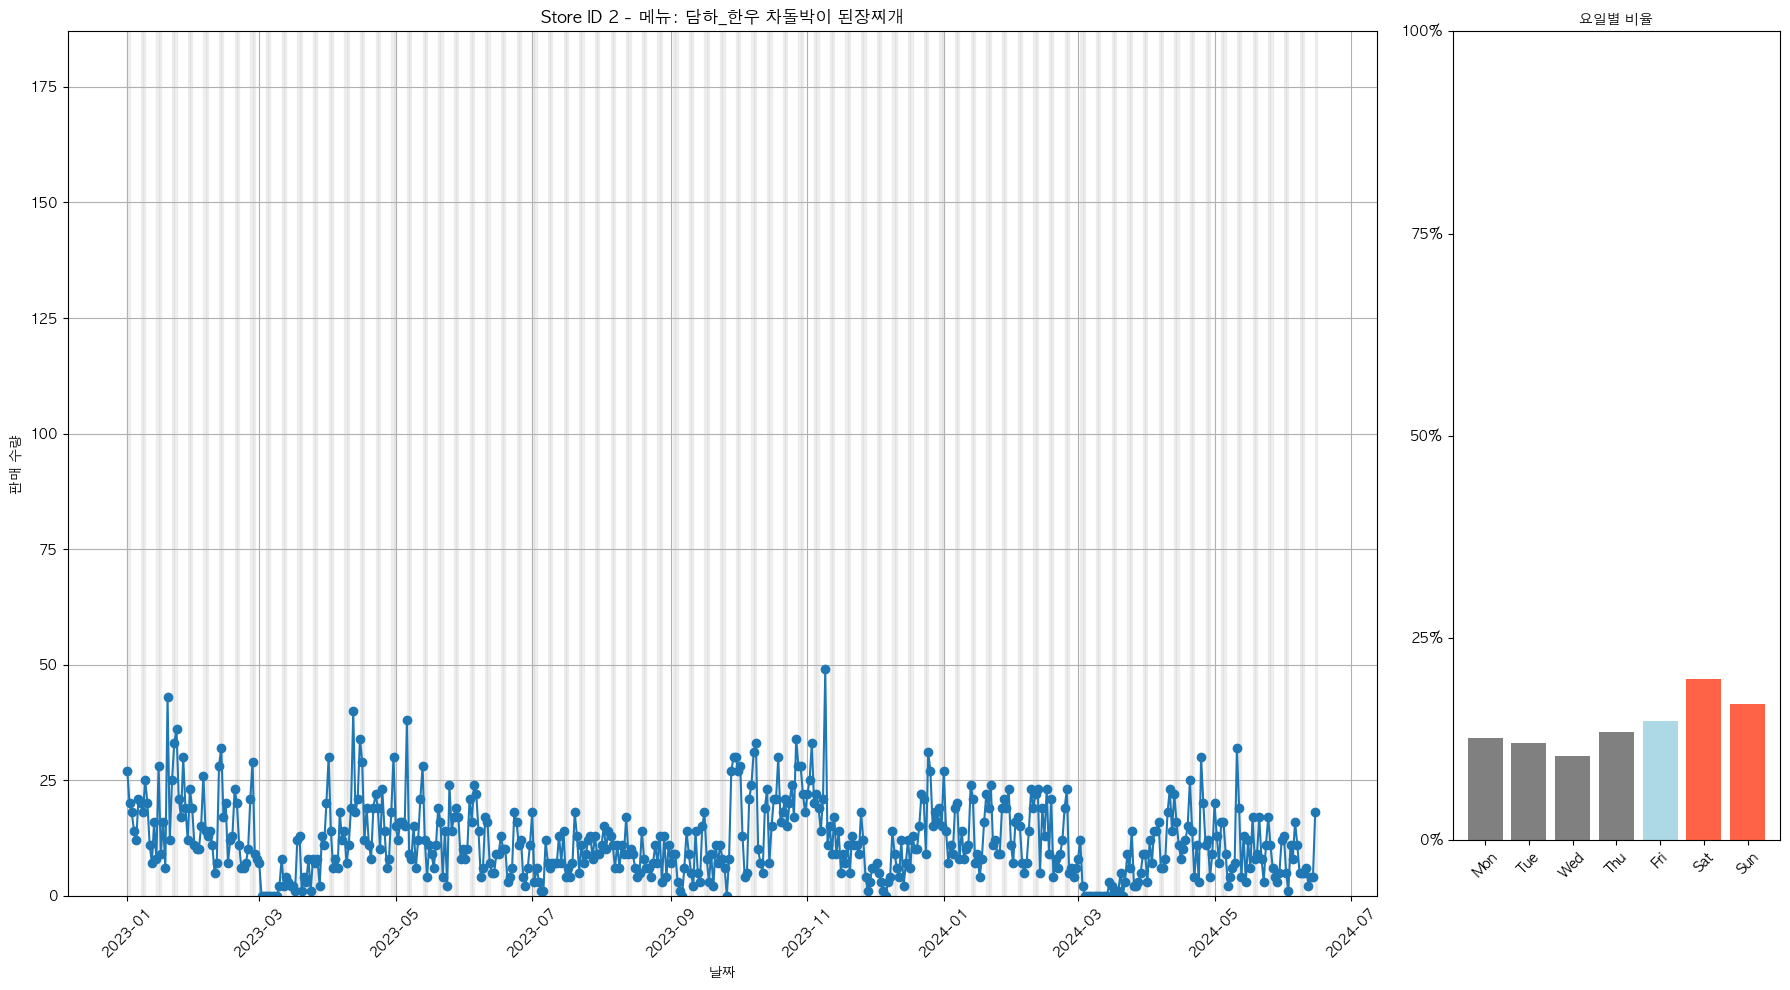

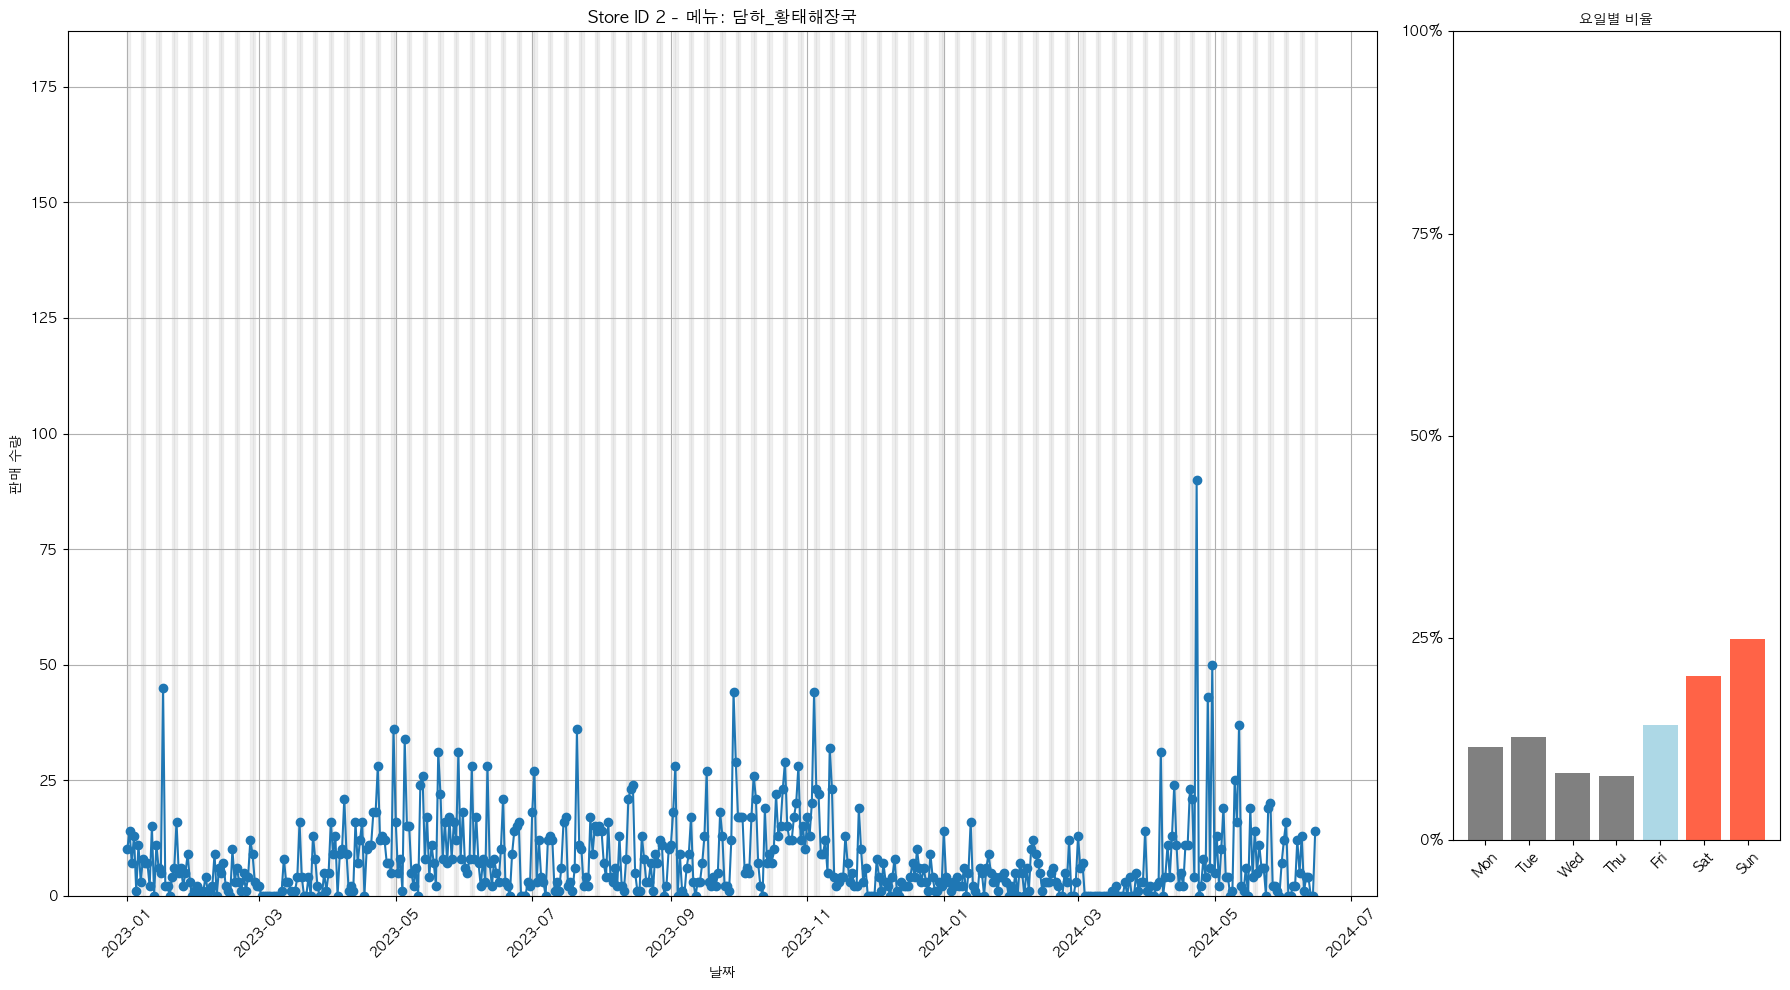

In [31]:
display(train_df.head())
min_idx = 2
max_idx = 3
visualization_of_stores(train_df, list(range(min_idx, max_idx)),'split')